# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm

# Import test data

In [2]:
# Provide the file name of the test file in CSV format below. An example file "validation.csv" has been provided for reference.
test_data = pd.read_csv('validation.csv')

In [3]:
test_data.head()

,geohash6,day,timestamp,demand
0,qp02yc,58,2:45,0.011352
1,qp02yc,58,2:30,0.030095
2,qp02yc,61,4:45,0.014507
3,qp02yc,59,5:15,0.008128
4,qp02yc,55,9:0,0.012851


# Define Data class

The Data class defined below is identical to the Data class defined in the model_train.ipynb file. The reason for redefining the Data class in the test file is to resolve the AttributeError issue raised during the unpickling of the data_objects.pkl file.

In [4]:
class Data:
    def __init__(self, train_data, geohash):
        """
        Initialises the Data object by taking in a dataframe (which serve as the training data) together with its corresponding geohash (which serve as a unique identifier) as input. 
        The function preprocesses the training data and decodes the geohash before storing them as object attributes.
        
        :param data: A dataframe containing the unprocessed training data.
        :type data: dataframe
        
        :param geohash: A six-character unique identifier that encodes the coodinates of particular location.
        :type geohash: string
        """
        self.geohash = geohash
        self.latitude, self.longitude = Geohash.decode(self.geohash)
        temp = self.extract_hour_minute(train_data[['day','timestamp','demand']])
        self.train_data = self.impute_zero_demand(temp)
        self.test_data = None
    
    
    def extract_hour_minute(self, data):
        """
        Extracts the hour and minute information from the timestamp and stores them in separate columns.
        Returns a dataframe (sorted in chronological order) with two additional columns: "hour" and "minute".
        
        : param data: A dataframe containing the unprocessed training/validation/test data.
        : type data: dataframe
        """
        hour, minute = zip(*[timestamp.split(':') for timestamp in data['timestamp']])
        data['hour'] = [int(item) for item in hour]
        data['minute'] = [int(item) for item in minute]
        data.drop(columns=['timestamp'], inplace=True)
        
        return data.sort_values(by=['day','hour','minute']).reset_index(drop=True)
    
    
    def impute_zero_demand(self, data):
        """
        As the unprocessed data is assumed to only store instances where demand is greater than 0, the demand for the other timestamps are imputed (with a zero value) and arranged in chronological order.
        Returns a dataframe containing the demand value for every timestamp in 15 minutes intervals (0, 15, 30, 45).
        
        : param data: A dataframe containing the unprocessed training/validation/test data with the "hour" and "minute" information stored in separate columns.
        : type data: dataframe
        """
        day_list = list(data.groupby('day').groups.keys())
        hour_list = list(range(0, 24, 1))
        minute_list = list(range(0, 60, 15))
        
        time_interval = np.asarray([[day,hour,minute] for day in day_list for hour in hour_list for minute in minute_list], dtype=np.int32)
        new_data = np.hstack((time_interval, np.zeros(shape=(time_interval.shape[0],1))))
        
        for i in range(len(data)):
            index = np.where((new_data[:,0] == data.loc[i,'day']) & (new_data[:,1] == data.loc[i,'hour']) & (new_data[:,2] == data.loc[i,'minute']))
            new_data[index, 3] = data.loc[i,'demand']
            
        return pd.DataFrame(data=new_data, columns=['day','hour','minute','demand'])
    
    
    def plot_demand(self, day):
        """
        Plots the demand of a given day against time in the form of a line plot. 
        In the case where the day of interest cannot be found in the dataset, the demand graph is not plotted.
        
        : param day: An integer value indicating the day of interest.
        : type day: integer
        """
        tick_loc = list(range(0,97,4))
        tick_label = list(range(0,25))
        try:
            grouped_data = self.train_data.groupby('day').get_group(day)
            sns.lineplot(x=list(range(len(grouped_data))), y=grouped_data['demand'])
            plt.xlabel('Time')
            plt.ylabel('Normalised Demand')
            plt.title('Demand VS Time')
            plt.xticks(tick_loc, tick_label)
        except KeyError:
            pass
        
        
    def data_by_time(self, days):
        """
        Extracts the demand information for each day of interest and stores them in a dataframe.
        Returns a dataframe where each row corresponds to the demand for a particular day of interest and each column corresponds to a particular timestamp of the day.
        
        : param days: A list of integer values indicating the days of interest.
        : type days: list
        """
        hour_list = list(range(0, 24, 1))
        minute_list = list(range(0, 60, 15))
        time_interval = [[hour,minute] for hour in hour_list for minute in minute_list]
        
        for day in days:
            try:
                data_array = np.vstack((data_array, self.train_data.groupby('day').get_group(day).values))
            except KeyError:
                pass
            except NameError:
                try:
                    data_array = self.train_data.groupby('day').get_group(day).values
                except KeyError:
                    pass
    
        for hour, minute in time_interval:
            index = np.where((data_array[:,1] == hour) & (data_array[:,2] == minute))
            
            if hour == 0 and minute == 0:
                data_by_time = data_array[index,3].reshape(-1,1)
            else: 
                data_by_time = np.hstack((data_by_time, data_array[index,3].reshape(-1,1)))
        
        return pd.DataFrame(data_by_time, columns=[str(time[0])+':'+str(time[1]) for time in time_interval])
        
        
    def set_test_data(self, test_data):
        """
        Sets the input dataframe as the test data (attribute) of the Data object.
        
        : param test_data: A dataframe containing the validation/test data.
        : type test_data: dataframe
        """
        temp = self.extract_hour_minute(test_data[['day','timestamp','demand']])
        self.test_data = self.impute_zero_demand(temp)
        
        
    def next_batch(self, batch_size, num_time_steps, steps_ahead, training=True):
        """
        Randomly select a few starting points (= batch_size) from the dataset (pre-arranged in chronological order) and store the subsequent data points (= num_time_steps + steps_ahead) ahead in time.
        Returns two 3D arrays where the first 3D array contains the model input and the second 3D array contains the true output for evaluation purposes.
        Shape of both 3D arrays = [batch_size, num_time_steps, 1].
        
        : param batch_size: Indicates the batch size of output.
        : type batch_size: integer
        
        : param num_time_steps: Indicates the number of time steps 
        : type num_time_steps: integer
        
        : param steps_ahead: Indicates the number of time steps the model should predict ahead in time.
        : type steps_ahead: integer
        
        : param training: Indicates whether the data will be used for training or validation/testing purposes. If True, the data will be sampled from the training data. Else, the data will be sampled from the validation/test data.
        : type training: bool
        """
        if training:
            data = self.train_data
        else:
            data = self.test_data
            
        input_columns = ['demand']
        input_dim = len(input_columns)
        rand_start = random.choices(population=range(len(data)-num_time_steps-steps_ahead), k=batch_size) ## randomly initialise the starting point between the first index to the (last index - num_time_steps - steps_ahead)
        y_batch = data[input_columns].values.transpose()
        y_batch = np.asarray([y_batch[:,i:i+num_time_steps+steps_ahead].reshape(num_time_steps+steps_ahead,input_dim) for i in rand_start])

        return y_batch[:,:-steps_ahead,:], y_batch[:,steps_ahead:,:]
        
        
    def test_batch(self, num_time_steps, steps_ahead):
        """
        Splits the entire validation/test dataset (pre-arranged in chronological order) into equal parts of length = (num_time_steps + steps_ahead).
        Returns two 3D arrays where the first 3D array contains the model input and the second 3D array contains the true output for evaluation purposes.
        Shape of both 3D arrays = [?, num_time_steps, 1].
        
        : param num_time_steps: Indicates the number of time steps 
        : type num_time_steps: integer
        
        : param steps_ahead: Indicates the number of time steps the model should predict ahead in time.
        : type steps_ahead: integer
        """
        if self.test_data is None:
            raise ValueError('Test data is not initialised.')
           
        input_columns = ['demand']
        input_dim = len(input_columns)
        start_index = list(range(0, len(self.test_data)-num_time_steps-steps_ahead, num_time_steps+steps_ahead))
        start_index.append(len(self.test_data)-num_time_steps-steps_ahead)  # this ensures that the last few data points are predicted as well
        test_batch = self.test_data[input_columns].values.transpose()
        test_batch = np.asarray([test_batch[:,i:i+num_time_steps+steps_ahead].reshape(num_time_steps+steps_ahead,input_dim) for i in start_index])
        
        return test_batch[:,:-steps_ahead,:], test_batch[:,steps_ahead:,:] 

# Define Model class

The Model class defined below is identical to the Model class defined in the model_train.ipynb file. The reason for redefining the Model class in the test file is to resolve the AttributeError issue raised during the unpickling of the model_objects.pkl file.

In [5]:
class Model:
    def __init__(self, data, geohash):
        """
        Initalises the Model object by taking in a Data object together with its corresponding geohash (which serve as a unique identifier) as input. 
        At the same time, the function initialises the hyperparameters of the neural network.
        
        :param data: A Data object containing both the training data and validation/test data sets as attributes.
        :type data: Data object
        
        :param geohash: A six-character unique identifier that encodes the coodinates of particular location.
        :type geohash: string
        """
        self.geohash = geohash
        self.data = data
        self.batch_size = 100
        self.num_time_steps = 20
        self.steps_ahead = 5  # the model predicts up to 5 time steps forward in time
        self.num_neurons = self.num_time_steps
        self.input_dim = 1
        self.output_dim = 1
        self.learning_rate = 0.001
        self.epoch = 10000
        self.num_layers = 3
        
    
    def train_model(self):
        """
        Sets up the architecture of the neural network and begin training the neural network based on the training set in the Data object.
        """
        tf.reset_default_graph()
        
        # Define the variables of the neural network
        X = tf.placeholder(tf.float32, [None, self.num_time_steps, self.input_dim])
        y = tf.placeholder(tf.float32, [None, self.num_time_steps, self.output_dim])
        
        # Define the operations of the neural network
        cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_units=self.num_neurons) for layer in range(self.num_layers)])
        outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        final_outputs = tf.nn.relu(tf.reshape(outputs[:,-1,:], [self.batch_size,self.num_time_steps,self.output_dim]))
        
        # Define loss function (based on MSE)
        loss = tf.reduce_mean(tf.square(final_outputs-y))
        
        # Initialise the optimiser
        optimiser = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)
        
        # Initialise the global variables and begin training
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        train_mse_list = []
        test_mse_list = []

        for iteration in tqdm(range(self.epoch)):
            X_train_batch, y_train_batch = self.data.next_batch(batch_size=self.batch_size, num_time_steps=self.num_time_steps, steps_ahead=self.steps_ahead)
            sess.run(optimiser, feed_dict={X:X_train_batch, y:y_train_batch})
                
            # Track the training progress
            if iteration % 100 == 0:
                train_mse = loss.eval(feed_dict={X:X_train_batch, y:y_train_batch})
                train_mse_list.append(train_mse)
                
                X_test_batch, y_test_batch = self.data.next_batch(batch_size=self.batch_size, num_time_steps=self.num_time_steps, steps_ahead=self.steps_ahead, training=False)
                test_prediction, test_mse = sess.run([final_outputs,loss],feed_dict={X:X_test_batch, y:y_test_batch})
                test_mse_list.append(test_mse)
            
        # Save the pre-train model for future testing
        saver.save(sess, './models/' + self.geohash)
        sess.close()
        
        # Plot the training progress based on MSE
        sns.lineplot(x=list(range(len(train_mse_list))), y=train_mse_list, label='Training')
        sns.lineplot(x=list(range(len(test_mse_list))), y=test_mse_list, label='Test')
        plt.show()
        
        
    def test_model(self):
        """
        Sets up the architecture of the neural network and loads the pre-trained model for testing based on the validation/test set in the Data object. 
        Returns a float value containing the test results (MSE score).
        """
        tf.reset_default_graph()
        
        # Define the variables of the neural network
        X = tf.placeholder(tf.float32, [None, self.num_time_steps, self.input_dim])
        y = tf.placeholder(tf.float32, [None, self.num_time_steps, self.output_dim])
        
        # Define the operations of the neural network
        cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_units=self.num_neurons) for layer in range(self.num_layers)])
        outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        final_outputs = tf.nn.relu(tf.reshape(outputs[:,-1,:], [-1,self.num_time_steps,self.output_dim]))
        
        # Define loss function (based on MSE)
        loss = tf.reduce_mean(tf.square(final_outputs-y))
        
        # Initialise the optimiser
        optimiser = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)
        
        # Initialise the global variables and reload the pre-train model
        sess = tf.InteractiveSession()
        saver = tf.train.Saver()
        saver.restore(sess, './models/' + self.geohash)
        sess.run(tf.global_variables_initializer())
        
        # Begin testing
        X_test_batch, y_test_batch = self.data.test_batch(num_time_steps=self.num_time_steps, steps_ahead=self.steps_ahead)
        test_mse = loss.eval(feed_dict={X:X_test_batch, y:y_test_batch})

        sess.close()
        
        return test_mse

# Load the Data and Model objects created during the model training step

In [6]:
with open('data_objects.pkl', 'rb') as input_file:
    data_list = pickle.load(input_file)

In [7]:
with open('model_objects.pkl', 'rb') as input_file:
    model_list = pickle.load(input_file)

In [8]:
with open('geohash_list.pkl', 'rb') as output_file:
    geohash_list = pickle.load(output_file)

# Segment the test data based on geolocation and perform model testing for each geolocation

In [9]:
test_geohash_list = list(test_data.groupby('geohash6').groups.keys())
test_gb = test_data.groupby('geohash6')
test_mse_list = []

for i in tqdm(range(len(test_geohash_list))):
    try:
        # Segment the test data based on geolocation (using the geohash information) and store it in its respective Data object
        index = geohash_list.index(test_geohash_list[i])
        data_list[index].set_test_data(test_gb.get_group(test_geohash_list[i]))
        
        # Perform model testing on the test data and output the test results
        test_mse = model_list[index].test_model()
        test_mse_list.append(test_mse)
        print('Test MSE for {}: {}'.format(test_geohash_list[i], test_mse))
        
    except ValueError:
        # Test data from geohashes that are not found in the training data are excluded from the evaluation
        print('{} is not included in the training data.'.format(test_geohash_list[i]))
        pass

  0%|          | 0/1329 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./models/qp02yc


  0%|          | 1/1329 [00:06<2:22:16,  6.43s/it]

Test MSE for qp02yc: 0.00016346648044418544
INFO:tensorflow:Restoring parameters from ./models/qp02yf


  0%|          | 2/1329 [00:07<1:45:47,  4.78s/it]

Test MSE for qp02yf: 8.319783773913514e-06
INFO:tensorflow:Restoring parameters from ./models/qp02yu


  0%|          | 3/1329 [00:08<1:20:20,  3.64s/it]

Test MSE for qp02yu: 2.128890628227964e-05
INFO:tensorflow:Restoring parameters from ./models/qp02yv


  0%|          | 4/1329 [00:09<1:02:34,  2.83s/it]

Test MSE for qp02yv: 1.5580484387101023e-06
INFO:tensorflow:Restoring parameters from ./models/qp02yy


  0%|          | 5/1329 [00:10<50:11,  2.27s/it]  

Test MSE for qp02yy: 2.617165819174261e-06
INFO:tensorflow:Restoring parameters from ./models/qp02yz


  0%|          | 6/1329 [00:11<41:26,  1.88s/it]

Test MSE for qp02yz: 0.00023090311151463538
INFO:tensorflow:Restoring parameters from ./models/qp02z1


  1%|          | 7/1329 [00:12<35:49,  1.63s/it]

Test MSE for qp02z1: 0.0004687929467763752
INFO:tensorflow:Restoring parameters from ./models/qp02z3


  1%|          | 8/1329 [00:13<31:31,  1.43s/it]

Test MSE for qp02z3: 1.6511594367329963e-05
INFO:tensorflow:Restoring parameters from ./models/qp02z4


  1%|          | 9/1329 [00:14<28:51,  1.31s/it]

Test MSE for qp02z4: 9.611100540496409e-05
INFO:tensorflow:Restoring parameters from ./models/qp02z5


  1%|          | 10/1329 [00:15<26:53,  1.22s/it]

Test MSE for qp02z5: 0.000736783433239907
INFO:tensorflow:Restoring parameters from ./models/qp02z6


  1%|          | 11/1329 [00:16<25:45,  1.17s/it]

Test MSE for qp02z6: 0.0017722544725984335
INFO:tensorflow:Restoring parameters from ./models/qp02z7


  1%|          | 12/1329 [00:17<24:58,  1.14s/it]

Test MSE for qp02z7: 0.004912281408905983
INFO:tensorflow:Restoring parameters from ./models/qp02z9


  1%|          | 13/1329 [00:18<23:58,  1.09s/it]

Test MSE for qp02z9: 0.00027486379258334637
INFO:tensorflow:Restoring parameters from ./models/qp02zc


  1%|          | 14/1329 [00:19<23:33,  1.07s/it]

Test MSE for qp02zc: 0.0016176562057808042
INFO:tensorflow:Restoring parameters from ./models/qp02zd


  1%|          | 15/1329 [00:20<23:24,  1.07s/it]

Test MSE for qp02zd: 0.0017777911853045225
INFO:tensorflow:Restoring parameters from ./models/qp02ze


  1%|          | 16/1329 [00:21<23:22,  1.07s/it]

Test MSE for qp02ze: 0.005266524851322174
INFO:tensorflow:Restoring parameters from ./models/qp02zf


  1%|▏         | 17/1329 [00:22<23:13,  1.06s/it]

Test MSE for qp02zf: 0.025974944233894348
INFO:tensorflow:Restoring parameters from ./models/qp02zg


  1%|▏         | 18/1329 [00:23<23:00,  1.05s/it]

Test MSE for qp02zg: 0.0018734547775238752
INFO:tensorflow:Restoring parameters from ./models/qp02zh


  1%|▏         | 19/1329 [00:24<22:57,  1.05s/it]

Test MSE for qp02zh: 0.012885604053735733
INFO:tensorflow:Restoring parameters from ./models/qp02zj


  2%|▏         | 20/1329 [00:25<23:14,  1.06s/it]

Test MSE for qp02zj: 0.050255730748176575
INFO:tensorflow:Restoring parameters from ./models/qp02zk


  2%|▏         | 21/1329 [00:26<22:39,  1.04s/it]

Test MSE for qp02zk: 0.0016709247138351202
INFO:tensorflow:Restoring parameters from ./models/qp02zm


  2%|▏         | 22/1329 [00:27<22:49,  1.05s/it]

Test MSE for qp02zm: 0.0074682943522930145
INFO:tensorflow:Restoring parameters from ./models/qp02zn


  2%|▏         | 23/1329 [00:28<22:29,  1.03s/it]

Test MSE for qp02zn: 0.019946636632084846
INFO:tensorflow:Restoring parameters from ./models/qp02zp


  2%|▏         | 24/1329 [00:29<22:21,  1.03s/it]

Test MSE for qp02zp: 0.004030511248856783
INFO:tensorflow:Restoring parameters from ./models/qp02zq


  2%|▏         | 25/1329 [00:30<22:23,  1.03s/it]

Test MSE for qp02zq: 0.0049414183013141155
INFO:tensorflow:Restoring parameters from ./models/qp02zr


  2%|▏         | 26/1329 [00:31<22:21,  1.03s/it]

Test MSE for qp02zr: 0.014283180236816406
INFO:tensorflow:Restoring parameters from ./models/qp02zs


  2%|▏         | 27/1329 [00:32<22:14,  1.02s/it]

Test MSE for qp02zs: 0.005546338390558958
INFO:tensorflow:Restoring parameters from ./models/qp02zt


  2%|▏         | 28/1329 [00:33<22:11,  1.02s/it]

Test MSE for qp02zt: 0.04302870109677315
INFO:tensorflow:Restoring parameters from ./models/qp02zu


  2%|▏         | 29/1329 [00:34<21:53,  1.01s/it]

Test MSE for qp02zu: 0.0013753001112490892
INFO:tensorflow:Restoring parameters from ./models/qp02zv


  2%|▏         | 30/1329 [00:35<21:41,  1.00s/it]

Test MSE for qp02zv: 0.006153417285531759
INFO:tensorflow:Restoring parameters from ./models/qp02zw


  2%|▏         | 31/1329 [00:36<21:37,  1.00it/s]

Test MSE for qp02zw: 0.4731234014034271
INFO:tensorflow:Restoring parameters from ./models/qp02zx


  2%|▏         | 32/1329 [00:37<21:44,  1.01s/it]

Test MSE for qp02zx: 0.1377391368150711
INFO:tensorflow:Restoring parameters from ./models/qp02zy


  2%|▏         | 33/1329 [00:38<21:55,  1.02s/it]

Test MSE for qp02zy: 0.020176351070404053
INFO:tensorflow:Restoring parameters from ./models/qp02zz


  3%|▎         | 34/1329 [00:39<21:54,  1.01s/it]

Test MSE for qp02zz: 0.4637896716594696
INFO:tensorflow:Restoring parameters from ./models/qp03jq


  3%|▎         | 35/1329 [00:40<21:52,  1.01s/it]

Test MSE for qp03jq: 0.0007467542891390622
INFO:tensorflow:Restoring parameters from ./models/qp03jr


  3%|▎         | 36/1329 [00:41<21:53,  1.02s/it]

Test MSE for qp03jr: 0.000698209973052144
INFO:tensorflow:Restoring parameters from ./models/qp03jw


  3%|▎         | 37/1329 [00:43<21:55,  1.02s/it]

Test MSE for qp03jw: 0.0009220399078913033
INFO:tensorflow:Restoring parameters from ./models/qp03jx


  3%|▎         | 38/1329 [00:44<21:52,  1.02s/it]

Test MSE for qp03jx: 0.0005625986959785223
INFO:tensorflow:Restoring parameters from ./models/qp03jy


  3%|▎         | 39/1329 [00:45<21:47,  1.01s/it]

Test MSE for qp03jy: 0.0007614233763888478
INFO:tensorflow:Restoring parameters from ./models/qp03jz


  3%|▎         | 40/1329 [00:46<21:49,  1.02s/it]

Test MSE for qp03jz: 0.0007385077769868076
INFO:tensorflow:Restoring parameters from ./models/qp03m2


  3%|▎         | 41/1329 [00:47<21:47,  1.02s/it]

Test MSE for qp03m2: 0.00020583752484526485
INFO:tensorflow:Restoring parameters from ./models/qp03m3


  3%|▎         | 42/1329 [00:48<21:43,  1.01s/it]

Test MSE for qp03m3: 3.838652264676057e-05
INFO:tensorflow:Restoring parameters from ./models/qp03m6


  3%|▎         | 43/1329 [00:49<21:45,  1.01s/it]

Test MSE for qp03m6: 0.0037898956798017025
INFO:tensorflow:Restoring parameters from ./models/qp03m7


  3%|▎         | 44/1329 [00:50<21:38,  1.01s/it]

Test MSE for qp03m7: 0.0003562892379704863
INFO:tensorflow:Restoring parameters from ./models/qp03m8


  3%|▎         | 45/1329 [00:51<21:39,  1.01s/it]

Test MSE for qp03m8: 0.0006597536848857999
INFO:tensorflow:Restoring parameters from ./models/qp03m9


  3%|▎         | 46/1329 [00:52<21:30,  1.01s/it]

Test MSE for qp03m9: 0.0004360165912657976
INFO:tensorflow:Restoring parameters from ./models/qp03mb


  4%|▎         | 47/1329 [00:53<21:35,  1.01s/it]

Test MSE for qp03mb: 0.03205303102731705
INFO:tensorflow:Restoring parameters from ./models/qp03mc


  4%|▎         | 48/1329 [00:54<21:44,  1.02s/it]

Test MSE for qp03mc: 0.004393984097987413
INFO:tensorflow:Restoring parameters from ./models/qp03md


  4%|▎         | 49/1329 [00:55<21:30,  1.01s/it]

Test MSE for qp03md: 0.00024192997079808265
INFO:tensorflow:Restoring parameters from ./models/qp03me


  4%|▍         | 50/1329 [00:56<21:27,  1.01s/it]

Test MSE for qp03me: 0.0023128727916628122
INFO:tensorflow:Restoring parameters from ./models/qp03mf


  4%|▍         | 51/1329 [00:57<21:25,  1.01s/it]

Test MSE for qp03mf: 0.0014827194390818477
INFO:tensorflow:Restoring parameters from ./models/qp03mg


  4%|▍         | 52/1329 [00:58<21:31,  1.01s/it]

Test MSE for qp03mg: 0.044400040060281754
INFO:tensorflow:Restoring parameters from ./models/qp03mk


  4%|▍         | 53/1329 [00:59<21:31,  1.01s/it]

Test MSE for qp03mk: 0.0001252888614544645
INFO:tensorflow:Restoring parameters from ./models/qp03mm


  4%|▍         | 54/1329 [01:00<21:25,  1.01s/it]

Test MSE for qp03mm: 4.153961708652787e-05
INFO:tensorflow:Restoring parameters from ./models/qp03mq


  4%|▍         | 55/1329 [01:01<21:12,  1.00it/s]

Test MSE for qp03mq: 7.32041007722728e-05
INFO:tensorflow:Restoring parameters from ./models/qp03mr


  4%|▍         | 56/1329 [01:02<21:04,  1.01it/s]

Test MSE for qp03mr: 4.018091203761287e-05
INFO:tensorflow:Restoring parameters from ./models/qp03ms


  4%|▍         | 57/1329 [01:03<21:09,  1.00it/s]

Test MSE for qp03ms: 0.00024029552878346294
INFO:tensorflow:Restoring parameters from ./models/qp03mt


  4%|▍         | 58/1329 [01:04<21:15,  1.00s/it]

Test MSE for qp03mt: 0.0007656580419279635
INFO:tensorflow:Restoring parameters from ./models/qp03mu


  4%|▍         | 59/1329 [01:05<21:13,  1.00s/it]

Test MSE for qp03mu: 0.0021095569245517254
INFO:tensorflow:Restoring parameters from ./models/qp03mv


  5%|▍         | 60/1329 [01:06<21:17,  1.01s/it]

Test MSE for qp03mv: 0.0026594887021929026
INFO:tensorflow:Restoring parameters from ./models/qp03mw


  5%|▍         | 61/1329 [01:07<21:16,  1.01s/it]

Test MSE for qp03mw: 0.001138664549216628
INFO:tensorflow:Restoring parameters from ./models/qp03mx


  5%|▍         | 62/1329 [01:08<21:07,  1.00s/it]

Test MSE for qp03mx: 1.5680750948376954e-05
INFO:tensorflow:Restoring parameters from ./models/qp03my


  5%|▍         | 63/1329 [01:09<21:10,  1.00s/it]

Test MSE for qp03my: 0.004137006588280201
INFO:tensorflow:Restoring parameters from ./models/qp03mz


  5%|▍         | 64/1329 [01:10<21:10,  1.00s/it]

Test MSE for qp03mz: 0.001473122974857688
INFO:tensorflow:Restoring parameters from ./models/qp03nb


  5%|▍         | 65/1329 [01:11<21:05,  1.00s/it]

Test MSE for qp03nb: 0.00526957493275404
INFO:tensorflow:Restoring parameters from ./models/qp03nd


  5%|▍         | 66/1329 [01:12<21:16,  1.01s/it]

Test MSE for qp03nd: 0.0004492647130973637
INFO:tensorflow:Restoring parameters from ./models/qp03nf


  5%|▌         | 67/1329 [01:13<21:20,  1.01s/it]

Test MSE for qp03nf: 0.0050747692584991455
INFO:tensorflow:Restoring parameters from ./models/qp03nn


  5%|▌         | 68/1329 [01:14<21:13,  1.01s/it]

Test MSE for qp03nn: 1.30380549308029e-05
INFO:tensorflow:Restoring parameters from ./models/qp03np


  5%|▌         | 69/1329 [01:15<21:02,  1.00s/it]

Test MSE for qp03np: 3.797592216869816e-05
INFO:tensorflow:Restoring parameters from ./models/qp03nq


  5%|▌         | 70/1329 [01:16<21:07,  1.01s/it]

Test MSE for qp03nq: 0.009524691849946976
INFO:tensorflow:Restoring parameters from ./models/qp03nr


  5%|▌         | 71/1329 [01:17<21:16,  1.01s/it]

Test MSE for qp03nr: 0.014643027447164059
INFO:tensorflow:Restoring parameters from ./models/qp03nw


  5%|▌         | 72/1329 [01:18<21:19,  1.02s/it]

Test MSE for qp03nw: 0.004256995860487223
INFO:tensorflow:Restoring parameters from ./models/qp03nx


  5%|▌         | 73/1329 [01:19<21:10,  1.01s/it]

Test MSE for qp03nx: 0.003940930124372244
INFO:tensorflow:Restoring parameters from ./models/qp03ny


  6%|▌         | 74/1329 [01:20<21:08,  1.01s/it]

Test MSE for qp03ny: 0.02718326821923256
INFO:tensorflow:Restoring parameters from ./models/qp03nz


  6%|▌         | 75/1329 [01:21<21:10,  1.01s/it]

Test MSE for qp03nz: 0.0329713299870491
INFO:tensorflow:Restoring parameters from ./models/qp03p0


  6%|▌         | 76/1329 [01:22<20:58,  1.00s/it]

Test MSE for qp03p0: 0.00149440485984087
INFO:tensorflow:Restoring parameters from ./models/qp03p1


  6%|▌         | 77/1329 [01:23<20:47,  1.00it/s]

Test MSE for qp03p1: 0.0003392597718629986
INFO:tensorflow:Restoring parameters from ./models/qp03p2


  6%|▌         | 78/1329 [01:24<20:47,  1.00it/s]

Test MSE for qp03p2: 0.180279940366745
INFO:tensorflow:Restoring parameters from ./models/qp03p3


  6%|▌         | 79/1329 [01:25<20:58,  1.01s/it]

Test MSE for qp03p3: 0.005652353633195162
INFO:tensorflow:Restoring parameters from ./models/qp03p4


  6%|▌         | 80/1329 [01:26<20:49,  1.00s/it]

Test MSE for qp03p4: 0.0004397042212076485
INFO:tensorflow:Restoring parameters from ./models/qp03p5


  6%|▌         | 81/1329 [01:27<20:42,  1.00it/s]

Test MSE for qp03p5: 5.266403604764491e-05
INFO:tensorflow:Restoring parameters from ./models/qp03p6


  6%|▌         | 82/1329 [01:28<20:43,  1.00it/s]

Test MSE for qp03p6: 0.017772935330867767
INFO:tensorflow:Restoring parameters from ./models/qp03p7


  6%|▌         | 83/1329 [01:29<20:55,  1.01s/it]

Test MSE for qp03p7: 0.06795202940702438
INFO:tensorflow:Restoring parameters from ./models/qp03p8


  6%|▋         | 84/1329 [01:30<21:05,  1.02s/it]

Test MSE for qp03p8: 0.011844765394926071
INFO:tensorflow:Restoring parameters from ./models/qp03p9


  6%|▋         | 85/1329 [01:31<21:13,  1.02s/it]

Test MSE for qp03p9: 0.011050727218389511
INFO:tensorflow:Restoring parameters from ./models/qp03pb


  6%|▋         | 86/1329 [01:32<21:24,  1.03s/it]

Test MSE for qp03pb: 0.04471203684806824
INFO:tensorflow:Restoring parameters from ./models/qp03pc


  7%|▋         | 87/1329 [01:33<21:38,  1.05s/it]

Test MSE for qp03pc: 0.009181700646877289
INFO:tensorflow:Restoring parameters from ./models/qp03pd


  7%|▋         | 88/1329 [01:34<21:56,  1.06s/it]

Test MSE for qp03pd: 0.008662992157042027
INFO:tensorflow:Restoring parameters from ./models/qp03pe


  7%|▋         | 89/1329 [01:35<22:15,  1.08s/it]

Test MSE for qp03pe: 0.012844053097069263
INFO:tensorflow:Restoring parameters from ./models/qp03pf


  7%|▋         | 90/1329 [01:36<21:53,  1.06s/it]

Test MSE for qp03pf: 0.0018785615684464574
INFO:tensorflow:Restoring parameters from ./models/qp03pg


  7%|▋         | 91/1329 [01:37<21:38,  1.05s/it]

Test MSE for qp03pg: 2.4684079107828438e-05
INFO:tensorflow:Restoring parameters from ./models/qp03pj


  7%|▋         | 92/1329 [01:38<21:27,  1.04s/it]

Test MSE for qp03pj: 3.443297100602649e-05
INFO:tensorflow:Restoring parameters from ./models/qp03pk


  7%|▋         | 93/1329 [01:39<21:16,  1.03s/it]

Test MSE for qp03pk: 0.002032126532867551
INFO:tensorflow:Restoring parameters from ./models/qp03pm


  7%|▋         | 94/1329 [01:40<21:18,  1.04s/it]

Test MSE for qp03pm: 0.0003094510466326028
INFO:tensorflow:Restoring parameters from ./models/qp03pn


  7%|▋         | 95/1329 [01:41<21:07,  1.03s/it]

Test MSE for qp03pn: 0.0034969388507306576
INFO:tensorflow:Restoring parameters from ./models/qp03pp


  7%|▋         | 96/1329 [01:42<21:09,  1.03s/it]

Test MSE for qp03pp: 0.038532573729753494
INFO:tensorflow:Restoring parameters from ./models/qp03pq


  7%|▋         | 97/1329 [01:43<21:19,  1.04s/it]

Test MSE for qp03pq: 0.0017348091350868344
INFO:tensorflow:Restoring parameters from ./models/qp03pr


  7%|▋         | 98/1329 [01:44<21:12,  1.03s/it]

Test MSE for qp03pr: 0.036661546677351
INFO:tensorflow:Restoring parameters from ./models/qp03ps


  7%|▋         | 99/1329 [01:46<21:19,  1.04s/it]

Test MSE for qp03ps: 0.0031149922870099545
INFO:tensorflow:Restoring parameters from ./models/qp03pt


  8%|▊         | 100/1329 [01:47<21:06,  1.03s/it]

Test MSE for qp03pt: 0.0027979332953691483
INFO:tensorflow:Restoring parameters from ./models/qp03pu


  8%|▊         | 101/1329 [01:48<20:54,  1.02s/it]

Test MSE for qp03pu: 8.075000550888944e-06
INFO:tensorflow:Restoring parameters from ./models/qp03pv


  8%|▊         | 102/1329 [01:49<21:15,  1.04s/it]

Test MSE for qp03pv: 0.0006110419635660946
INFO:tensorflow:Restoring parameters from ./models/qp03pw


  8%|▊         | 103/1329 [01:50<21:04,  1.03s/it]

Test MSE for qp03pw: 0.0007186412694863975
INFO:tensorflow:Restoring parameters from ./models/qp03px


  8%|▊         | 104/1329 [01:51<20:57,  1.03s/it]

Test MSE for qp03px: 0.0029466154519468546
INFO:tensorflow:Restoring parameters from ./models/qp03py


  8%|▊         | 105/1329 [01:52<20:52,  1.02s/it]

Test MSE for qp03py: 0.0001655535161262378
INFO:tensorflow:Restoring parameters from ./models/qp03pz


  8%|▊         | 106/1329 [01:53<20:52,  1.02s/it]

Test MSE for qp03pz: 0.0016342197777703404
INFO:tensorflow:Restoring parameters from ./models/qp03q0


  8%|▊         | 107/1329 [01:54<20:57,  1.03s/it]

Test MSE for qp03q0: 0.0008488138555549085
INFO:tensorflow:Restoring parameters from ./models/qp03q1


  8%|▊         | 108/1329 [01:55<21:18,  1.05s/it]

Test MSE for qp03q1: 0.0021613207645714283
INFO:tensorflow:Restoring parameters from ./models/qp03q2


  8%|▊         | 109/1329 [01:56<21:34,  1.06s/it]

Test MSE for qp03q2: 0.014478355646133423
INFO:tensorflow:Restoring parameters from ./models/qp03q3


  8%|▊         | 110/1329 [01:57<21:49,  1.07s/it]

Test MSE for qp03q3: 0.007692517712712288
INFO:tensorflow:Restoring parameters from ./models/qp03q4


  8%|▊         | 111/1329 [01:58<21:55,  1.08s/it]

Test MSE for qp03q4: 0.00992990005761385
INFO:tensorflow:Restoring parameters from ./models/qp03q5


  8%|▊         | 112/1329 [01:59<21:47,  1.07s/it]

Test MSE for qp03q5: 0.007889987900853157
INFO:tensorflow:Restoring parameters from ./models/qp03q6


  9%|▊         | 113/1329 [02:00<21:44,  1.07s/it]

Test MSE for qp03q6: 0.0032538489904254675
INFO:tensorflow:Restoring parameters from ./models/qp03q7


  9%|▊         | 114/1329 [02:01<21:34,  1.07s/it]

Test MSE for qp03q7: 0.0026362286880612373
INFO:tensorflow:Restoring parameters from ./models/qp03q8


  9%|▊         | 115/1329 [02:02<21:26,  1.06s/it]

Test MSE for qp03q8: 0.00431082071736455
INFO:tensorflow:Restoring parameters from ./models/qp03q9


  9%|▊         | 116/1329 [02:03<21:33,  1.07s/it]

Test MSE for qp03q9: 0.013175980187952518
INFO:tensorflow:Restoring parameters from ./models/qp03qb


  9%|▉         | 117/1329 [02:04<21:32,  1.07s/it]

Test MSE for qp03qb: 0.009839233011007309
INFO:tensorflow:Restoring parameters from ./models/qp03qc


  9%|▉         | 118/1329 [02:06<21:49,  1.08s/it]

Test MSE for qp03qc: 0.008047496899962425
INFO:tensorflow:Restoring parameters from ./models/qp03qd


  9%|▉         | 119/1329 [02:07<21:31,  1.07s/it]

Test MSE for qp03qd: 0.014969882555305958
INFO:tensorflow:Restoring parameters from ./models/qp03qe


  9%|▉         | 120/1329 [02:08<21:31,  1.07s/it]

Test MSE for qp03qe: 0.010292540304362774
INFO:tensorflow:Restoring parameters from ./models/qp03qf


  9%|▉         | 121/1329 [02:09<21:21,  1.06s/it]

Test MSE for qp03qf: 0.06071179732680321
INFO:tensorflow:Restoring parameters from ./models/qp03qg


  9%|▉         | 122/1329 [02:10<21:24,  1.06s/it]

Test MSE for qp03qg: 0.3593331277370453
INFO:tensorflow:Restoring parameters from ./models/qp03qh


  9%|▉         | 123/1329 [02:11<21:26,  1.07s/it]

Test MSE for qp03qh: 0.0025682933628559113
INFO:tensorflow:Restoring parameters from ./models/qp03qj


  9%|▉         | 124/1329 [02:12<21:20,  1.06s/it]

Test MSE for qp03qj: 0.055980097502470016
INFO:tensorflow:Restoring parameters from ./models/qp03qk


  9%|▉         | 125/1329 [02:13<21:19,  1.06s/it]

Test MSE for qp03qk: 0.0007829811074770987
INFO:tensorflow:Restoring parameters from ./models/qp03qm


  9%|▉         | 126/1329 [02:14<21:18,  1.06s/it]

Test MSE for qp03qm: 0.05548107251524925
INFO:tensorflow:Restoring parameters from ./models/qp03qn


 10%|▉         | 127/1329 [02:15<21:08,  1.06s/it]

Test MSE for qp03qn: 0.0018617170862853527
INFO:tensorflow:Restoring parameters from ./models/qp03qp


 10%|▉         | 128/1329 [02:16<20:49,  1.04s/it]

Test MSE for qp03qp: 1.546486782899592e-05
INFO:tensorflow:Restoring parameters from ./models/qp03qq


 10%|▉         | 129/1329 [02:17<20:56,  1.05s/it]

Test MSE for qp03qq: 0.0030650687403976917
INFO:tensorflow:Restoring parameters from ./models/qp03qr


 10%|▉         | 130/1329 [02:18<21:00,  1.05s/it]

Test MSE for qp03qr: 8.631526725366712e-05
INFO:tensorflow:Restoring parameters from ./models/qp03qs


 10%|▉         | 131/1329 [02:19<21:08,  1.06s/it]

Test MSE for qp03qs: 0.012007410638034344
INFO:tensorflow:Restoring parameters from ./models/qp03qt


 10%|▉         | 132/1329 [02:20<21:04,  1.06s/it]

Test MSE for qp03qt: 7.493126759072766e-05
INFO:tensorflow:Restoring parameters from ./models/qp03qu


 10%|█         | 133/1329 [02:21<21:10,  1.06s/it]

Test MSE for qp03qu: 0.016064250841736794
INFO:tensorflow:Restoring parameters from ./models/qp03qv


 10%|█         | 134/1329 [02:23<21:07,  1.06s/it]

Test MSE for qp03qv: 0.00888635404407978
INFO:tensorflow:Restoring parameters from ./models/qp03qw


 10%|█         | 135/1329 [02:24<20:50,  1.05s/it]

Test MSE for qp03qw: 4.100790465599857e-05
INFO:tensorflow:Restoring parameters from ./models/qp03qx


 10%|█         | 136/1329 [02:25<20:54,  1.05s/it]

Test MSE for qp03qx: 0.00039768690476194024
INFO:tensorflow:Restoring parameters from ./models/qp03qy


 10%|█         | 137/1329 [02:26<21:02,  1.06s/it]

Test MSE for qp03qy: 0.12041115015745163
INFO:tensorflow:Restoring parameters from ./models/qp03qz


 10%|█         | 138/1329 [02:27<21:03,  1.06s/it]

Test MSE for qp03qz: 0.003519133199006319
INFO:tensorflow:Restoring parameters from ./models/qp03r0


 10%|█         | 139/1329 [02:28<21:09,  1.07s/it]

Test MSE for qp03r0: 0.03195663169026375
INFO:tensorflow:Restoring parameters from ./models/qp03r1


 11%|█         | 140/1329 [02:29<21:10,  1.07s/it]

Test MSE for qp03r1: 0.031461700797080994
INFO:tensorflow:Restoring parameters from ./models/qp03r2


 11%|█         | 141/1329 [02:30<21:15,  1.07s/it]

Test MSE for qp03r2: 0.12428079545497894
INFO:tensorflow:Restoring parameters from ./models/qp03r3


 11%|█         | 142/1329 [02:31<21:06,  1.07s/it]

Test MSE for qp03r3: 0.02860584296286106
INFO:tensorflow:Restoring parameters from ./models/qp03r4


 11%|█         | 143/1329 [02:32<20:53,  1.06s/it]

Test MSE for qp03r4: 0.009786304086446762
INFO:tensorflow:Restoring parameters from ./models/qp03r5


 11%|█         | 144/1329 [02:33<20:37,  1.04s/it]

Test MSE for qp03r5: 0.00473352475091815
INFO:tensorflow:Restoring parameters from ./models/qp03r6


 11%|█         | 145/1329 [02:34<20:30,  1.04s/it]

Test MSE for qp03r6: 0.01705211214721203
INFO:tensorflow:Restoring parameters from ./models/qp03r7


 11%|█         | 146/1329 [02:35<20:36,  1.05s/it]

Test MSE for qp03r7: 0.0006785290315747261
INFO:tensorflow:Restoring parameters from ./models/qp03r8


 11%|█         | 147/1329 [02:36<20:35,  1.04s/it]

Test MSE for qp03r8: 0.00597974332049489
INFO:tensorflow:Restoring parameters from ./models/qp03r9


 11%|█         | 148/1329 [02:37<20:39,  1.05s/it]

Test MSE for qp03r9: 0.023623298853635788
INFO:tensorflow:Restoring parameters from ./models/qp03rb


 11%|█         | 149/1329 [02:38<20:47,  1.06s/it]

Test MSE for qp03rb: 0.0007646066951565444
INFO:tensorflow:Restoring parameters from ./models/qp03rc


 11%|█▏        | 150/1329 [02:39<20:32,  1.05s/it]

Test MSE for qp03rc: 0.0006375479861162603
INFO:tensorflow:Restoring parameters from ./models/qp03rd


 11%|█▏        | 151/1329 [02:40<20:34,  1.05s/it]

Test MSE for qp03rd: 0.0033536895643919706
INFO:tensorflow:Restoring parameters from ./models/qp03re


 11%|█▏        | 152/1329 [02:41<20:39,  1.05s/it]

Test MSE for qp03re: 0.03680526092648506
INFO:tensorflow:Restoring parameters from ./models/qp03rf


 12%|█▏        | 153/1329 [02:43<20:39,  1.05s/it]

Test MSE for qp03rf: 0.011992035433650017
INFO:tensorflow:Restoring parameters from ./models/qp03rg


 12%|█▏        | 154/1329 [02:44<20:44,  1.06s/it]

Test MSE for qp03rg: 0.008557873778045177
INFO:tensorflow:Restoring parameters from ./models/qp03rh


 12%|█▏        | 155/1329 [02:45<20:41,  1.06s/it]

Test MSE for qp03rh: 0.02293289266526699
INFO:tensorflow:Restoring parameters from ./models/qp03rj


 12%|█▏        | 156/1329 [02:46<20:46,  1.06s/it]

Test MSE for qp03rj: 0.005552348215132952
INFO:tensorflow:Restoring parameters from ./models/qp03rk


 12%|█▏        | 157/1329 [02:47<20:41,  1.06s/it]

Test MSE for qp03rk: 0.007333752233535051
INFO:tensorflow:Restoring parameters from ./models/qp03rm


 12%|█▏        | 158/1329 [02:48<20:31,  1.05s/it]

Test MSE for qp03rm: 0.023166175931692123
INFO:tensorflow:Restoring parameters from ./models/qp03rn


 12%|█▏        | 159/1329 [02:49<20:23,  1.05s/it]

Test MSE for qp03rn: 0.01177995279431343
INFO:tensorflow:Restoring parameters from ./models/qp03rp


 12%|█▏        | 160/1329 [02:50<20:36,  1.06s/it]

Test MSE for qp03rp: 0.01215376053005457
INFO:tensorflow:Restoring parameters from ./models/qp03rq


 12%|█▏        | 161/1329 [02:51<20:31,  1.05s/it]

Test MSE for qp03rq: 0.007214166224002838
INFO:tensorflow:Restoring parameters from ./models/qp03rr


 12%|█▏        | 162/1329 [02:52<20:33,  1.06s/it]

Test MSE for qp03rr: 0.006821913179010153
INFO:tensorflow:Restoring parameters from ./models/qp03rs


 12%|█▏        | 163/1329 [02:53<20:30,  1.05s/it]

Test MSE for qp03rs: 0.001403075410053134
INFO:tensorflow:Restoring parameters from ./models/qp03rt


 12%|█▏        | 164/1329 [02:54<20:35,  1.06s/it]

Test MSE for qp03rt: 0.02023889869451523
INFO:tensorflow:Restoring parameters from ./models/qp03ru


 12%|█▏        | 165/1329 [02:55<20:27,  1.05s/it]

Test MSE for qp03ru: 0.008654633536934853
INFO:tensorflow:Restoring parameters from ./models/qp03rv


 12%|█▏        | 166/1329 [02:56<20:25,  1.05s/it]

Test MSE for qp03rv: 0.01133024226874113
INFO:tensorflow:Restoring parameters from ./models/qp03rw


 13%|█▎        | 167/1329 [02:57<20:32,  1.06s/it]

Test MSE for qp03rw: 0.04080359265208244
INFO:tensorflow:Restoring parameters from ./models/qp03rx


 13%|█▎        | 168/1329 [02:58<20:35,  1.06s/it]

Test MSE for qp03rx: 0.008121571503579617
INFO:tensorflow:Restoring parameters from ./models/qp03ry


 13%|█▎        | 169/1329 [02:59<20:26,  1.06s/it]

Test MSE for qp03ry: 0.01724988967180252
INFO:tensorflow:Restoring parameters from ./models/qp03rz


 13%|█▎        | 170/1329 [03:00<20:25,  1.06s/it]

Test MSE for qp03rz: 0.008862585760653019
INFO:tensorflow:Restoring parameters from ./models/qp03t2


 13%|█▎        | 171/1329 [03:02<20:17,  1.05s/it]

Test MSE for qp03t2: 3.836969699477777e-05
INFO:tensorflow:Restoring parameters from ./models/qp03t3


 13%|█▎        | 172/1329 [03:03<20:26,  1.06s/it]

Test MSE for qp03t3: 0.00030154502019286156
INFO:tensorflow:Restoring parameters from ./models/qp03t6


 13%|█▎        | 173/1329 [03:04<20:26,  1.06s/it]

Test MSE for qp03t6: 0.00020341620256658643
INFO:tensorflow:Restoring parameters from ./models/qp03t7


 13%|█▎        | 174/1329 [03:05<20:14,  1.05s/it]

Test MSE for qp03t7: 0.00044390419498085976
INFO:tensorflow:Restoring parameters from ./models/qp03t8


 13%|█▎        | 175/1329 [03:06<20:27,  1.06s/it]

Test MSE for qp03t8: 0.0016276505775749683
INFO:tensorflow:Restoring parameters from ./models/qp03t9


 13%|█▎        | 176/1329 [03:07<20:17,  1.06s/it]

Test MSE for qp03t9: 0.0035762262996286154
INFO:tensorflow:Restoring parameters from ./models/qp03tb


 13%|█▎        | 177/1329 [03:08<20:21,  1.06s/it]

Test MSE for qp03tb: 0.00283074751496315
INFO:tensorflow:Restoring parameters from ./models/qp03tc


 13%|█▎        | 178/1329 [03:09<20:22,  1.06s/it]

Test MSE for qp03tc: 0.00762913515791297
INFO:tensorflow:Restoring parameters from ./models/qp03td


 13%|█▎        | 179/1329 [03:10<20:07,  1.05s/it]

Test MSE for qp03td: 0.00026985027943737805
INFO:tensorflow:Restoring parameters from ./models/qp03te


 14%|█▎        | 180/1329 [03:11<19:50,  1.04s/it]

Test MSE for qp03te: 0.00011926800652872771
INFO:tensorflow:Restoring parameters from ./models/qp03tf


 14%|█▎        | 181/1329 [03:12<19:48,  1.04s/it]

Test MSE for qp03tf: 0.0008681633626110852
INFO:tensorflow:Restoring parameters from ./models/qp03tg


 14%|█▎        | 182/1329 [03:13<19:43,  1.03s/it]

Test MSE for qp03tg: 0.0004646145971491933
INFO:tensorflow:Restoring parameters from ./models/qp03tk


 14%|█▍        | 183/1329 [03:14<19:29,  1.02s/it]

Test MSE for qp03tk: 6.104610292823054e-06
INFO:tensorflow:Restoring parameters from ./models/qp03tm


 14%|█▍        | 184/1329 [03:15<19:19,  1.01s/it]

Test MSE for qp03tm: 2.5970581191359088e-05
INFO:tensorflow:Restoring parameters from ./models/qp03tq


 14%|█▍        | 185/1329 [03:16<19:07,  1.00s/it]

Test MSE for qp03tq: 5.043050805397797e-06
INFO:tensorflow:Restoring parameters from ./models/qp03tr


 14%|█▍        | 186/1329 [03:17<19:01,  1.00it/s]

Test MSE for qp03tr: 2.6046751600006246e-07
INFO:tensorflow:Restoring parameters from ./models/qp03ts


 14%|█▍        | 187/1329 [03:18<19:17,  1.01s/it]

Test MSE for qp03ts: 0.0017200539587065578
INFO:tensorflow:Restoring parameters from ./models/qp03tt


 14%|█▍        | 188/1329 [03:19<19:20,  1.02s/it]

Test MSE for qp03tt: 5.526578024728224e-05
INFO:tensorflow:Restoring parameters from ./models/qp03tu


 14%|█▍        | 189/1329 [03:20<19:17,  1.02s/it]

Test MSE for qp03tu: 0.0008007555734366179
INFO:tensorflow:Restoring parameters from ./models/qp03tv


 14%|█▍        | 190/1329 [03:21<19:20,  1.02s/it]

Test MSE for qp03tv: 0.0005079443217255175
INFO:tensorflow:Restoring parameters from ./models/qp03tw


 14%|█▍        | 191/1329 [03:22<19:18,  1.02s/it]

Test MSE for qp03tw: 0.0001318799622822553
INFO:tensorflow:Restoring parameters from ./models/qp03tx


 14%|█▍        | 192/1329 [03:23<19:15,  1.02s/it]

Test MSE for qp03tx: 0.00013859884347766638
INFO:tensorflow:Restoring parameters from ./models/qp03ty


 15%|█▍        | 193/1329 [03:24<19:29,  1.03s/it]

Test MSE for qp03ty: 0.0005751962307840586
INFO:tensorflow:Restoring parameters from ./models/qp03tz


 15%|█▍        | 194/1329 [03:25<19:33,  1.03s/it]

Test MSE for qp03tz: 0.00011670128151308745
INFO:tensorflow:Restoring parameters from ./models/qp03v2


 15%|█▍        | 195/1329 [03:26<19:27,  1.03s/it]

Test MSE for qp03v2: 2.0036022760905325e-06
INFO:tensorflow:Restoring parameters from ./models/qp03v3


 15%|█▍        | 196/1329 [03:27<19:18,  1.02s/it]

Test MSE for qp03v3: 4.748713706703711e-07
INFO:tensorflow:Restoring parameters from ./models/qp03v9


 15%|█▍        | 197/1329 [03:28<19:20,  1.03s/it]

Test MSE for qp03v9: 2.586596747278236e-05
INFO:tensorflow:Restoring parameters from ./models/qp03vb


 15%|█▍        | 198/1329 [03:29<19:28,  1.03s/it]

Test MSE for qp03vb: 0.0003140348708257079
INFO:tensorflow:Restoring parameters from ./models/qp03vc


 15%|█▍        | 199/1329 [03:30<19:37,  1.04s/it]

Test MSE for qp03vc: 1.8773573629005114e-06
INFO:tensorflow:Restoring parameters from ./models/qp03vd


 15%|█▌        | 200/1329 [03:31<19:20,  1.03s/it]

Test MSE for qp03vd: 7.99602617007622e-07
INFO:tensorflow:Restoring parameters from ./models/qp03vf


 15%|█▌        | 201/1329 [03:32<19:06,  1.02s/it]

Test MSE for qp03vf: 9.736668289406225e-07
INFO:tensorflow:Restoring parameters from ./models/qp03w0


 15%|█▌        | 202/1329 [03:33<19:08,  1.02s/it]

Test MSE for qp03w0: 0.004694534931331873
INFO:tensorflow:Restoring parameters from ./models/qp03w1


 15%|█▌        | 203/1329 [03:35<19:20,  1.03s/it]

Test MSE for qp03w1: 0.0155729865655303
INFO:tensorflow:Restoring parameters from ./models/qp03w2


 15%|█▌        | 204/1329 [03:36<19:40,  1.05s/it]

Test MSE for qp03w2: 0.0008923176792450249
INFO:tensorflow:Restoring parameters from ./models/qp03w3


 15%|█▌        | 205/1329 [03:37<19:38,  1.05s/it]

Test MSE for qp03w3: 0.018602833151817322
INFO:tensorflow:Restoring parameters from ./models/qp03w4


 16%|█▌        | 206/1329 [03:38<19:42,  1.05s/it]

Test MSE for qp03w4: 0.005944807548075914
INFO:tensorflow:Restoring parameters from ./models/qp03w5


 16%|█▌        | 207/1329 [03:39<19:34,  1.05s/it]

Test MSE for qp03w5: 0.0024113478139042854
INFO:tensorflow:Restoring parameters from ./models/qp03w6


 16%|█▌        | 208/1329 [03:40<19:39,  1.05s/it]

Test MSE for qp03w6: 0.0035783187486231327
INFO:tensorflow:Restoring parameters from ./models/qp03w7


 16%|█▌        | 209/1329 [03:41<20:00,  1.07s/it]

Test MSE for qp03w7: 0.005043238867074251
INFO:tensorflow:Restoring parameters from ./models/qp03w8


 16%|█▌        | 210/1329 [03:42<20:07,  1.08s/it]

Test MSE for qp03w8: 0.10390736907720566
INFO:tensorflow:Restoring parameters from ./models/qp03w9


 16%|█▌        | 211/1329 [03:43<20:13,  1.09s/it]

Test MSE for qp03w9: 0.4890362620353699
INFO:tensorflow:Restoring parameters from ./models/qp03wb


 16%|█▌        | 212/1329 [03:44<20:06,  1.08s/it]

Test MSE for qp03wb: 0.0015219069318845868
INFO:tensorflow:Restoring parameters from ./models/qp03wc


 16%|█▌        | 213/1329 [03:45<20:01,  1.08s/it]

Test MSE for qp03wc: 0.1486109048128128
INFO:tensorflow:Restoring parameters from ./models/qp03wd


 16%|█▌        | 214/1329 [03:46<19:59,  1.08s/it]

Test MSE for qp03wd: 0.2324731945991516
INFO:tensorflow:Restoring parameters from ./models/qp03we


 16%|█▌        | 215/1329 [03:47<20:00,  1.08s/it]

Test MSE for qp03we: 0.0695066899061203
INFO:tensorflow:Restoring parameters from ./models/qp03wf


 16%|█▋        | 216/1329 [03:48<19:45,  1.06s/it]

Test MSE for qp03wf: 0.4853875935077667
INFO:tensorflow:Restoring parameters from ./models/qp03wg


 16%|█▋        | 217/1329 [03:49<19:31,  1.05s/it]

Test MSE for qp03wg: 0.32845762372016907
INFO:tensorflow:Restoring parameters from ./models/qp03wh


 16%|█▋        | 218/1329 [03:50<19:22,  1.05s/it]

Test MSE for qp03wh: 0.0012137049343436956
INFO:tensorflow:Restoring parameters from ./models/qp03wj


 16%|█▋        | 219/1329 [03:52<19:21,  1.05s/it]

Test MSE for qp03wj: 0.001751020667143166
INFO:tensorflow:Restoring parameters from ./models/qp03wk


 17%|█▋        | 220/1329 [03:53<19:11,  1.04s/it]

Test MSE for qp03wk: 0.0027440295089036226
INFO:tensorflow:Restoring parameters from ./models/qp03wm


 17%|█▋        | 221/1329 [03:54<19:07,  1.04s/it]

Test MSE for qp03wm: 0.007570049725472927
INFO:tensorflow:Restoring parameters from ./models/qp03wn


 17%|█▋        | 222/1329 [03:55<19:04,  1.03s/it]

Test MSE for qp03wn: 0.0031395081896334887
INFO:tensorflow:Restoring parameters from ./models/qp03wp


 17%|█▋        | 223/1329 [03:56<18:56,  1.03s/it]

Test MSE for qp03wp: 0.0006394648225978017
INFO:tensorflow:Restoring parameters from ./models/qp03wq


 17%|█▋        | 224/1329 [03:57<18:52,  1.02s/it]

Test MSE for qp03wq: 0.0028165578842163086
INFO:tensorflow:Restoring parameters from ./models/qp03wr


 17%|█▋        | 225/1329 [03:58<18:55,  1.03s/it]

Test MSE for qp03wr: 0.004686061292886734
INFO:tensorflow:Restoring parameters from ./models/qp03ws


 17%|█▋        | 226/1329 [03:59<18:53,  1.03s/it]

Test MSE for qp03ws: 0.020304448902606964
INFO:tensorflow:Restoring parameters from ./models/qp03wt


 17%|█▋        | 227/1329 [04:00<18:52,  1.03s/it]

Test MSE for qp03wt: 0.0077082873322069645
INFO:tensorflow:Restoring parameters from ./models/qp03wu


 17%|█▋        | 228/1329 [04:01<18:54,  1.03s/it]

Test MSE for qp03wu: 0.13098366558551788
INFO:tensorflow:Restoring parameters from ./models/qp03wv


 17%|█▋        | 229/1329 [04:02<19:02,  1.04s/it]

Test MSE for qp03wv: 0.01631881110370159
INFO:tensorflow:Restoring parameters from ./models/qp03ww


 17%|█▋        | 230/1329 [04:03<19:00,  1.04s/it]

Test MSE for qp03ww: 0.006401882041245699
INFO:tensorflow:Restoring parameters from ./models/qp03wx


 17%|█▋        | 231/1329 [04:04<18:57,  1.04s/it]

Test MSE for qp03wx: 0.009389177896082401
INFO:tensorflow:Restoring parameters from ./models/qp03wy


 17%|█▋        | 232/1329 [04:05<18:57,  1.04s/it]

Test MSE for qp03wy: 0.07338276505470276
INFO:tensorflow:Restoring parameters from ./models/qp03wz


 18%|█▊        | 233/1329 [04:06<19:10,  1.05s/it]

Test MSE for qp03wz: 0.5458822846412659
INFO:tensorflow:Restoring parameters from ./models/qp03x0


 18%|█▊        | 234/1329 [04:07<19:07,  1.05s/it]

Test MSE for qp03x0: 0.0026946738362312317
INFO:tensorflow:Restoring parameters from ./models/qp03x1


 18%|█▊        | 235/1329 [04:08<19:08,  1.05s/it]

Test MSE for qp03x1: 0.028078267350792885
INFO:tensorflow:Restoring parameters from ./models/qp03x2


 18%|█▊        | 236/1329 [04:09<19:10,  1.05s/it]

Test MSE for qp03x2: 0.018440529704093933
INFO:tensorflow:Restoring parameters from ./models/qp03x3


 18%|█▊        | 237/1329 [04:10<19:15,  1.06s/it]

Test MSE for qp03x3: 0.015192296355962753
INFO:tensorflow:Restoring parameters from ./models/qp03x4


 18%|█▊        | 238/1329 [04:11<19:12,  1.06s/it]

Test MSE for qp03x4: 0.004139676224440336
INFO:tensorflow:Restoring parameters from ./models/qp03x5


 18%|█▊        | 239/1329 [04:12<19:52,  1.09s/it]

Test MSE for qp03x5: 0.05573972314596176
INFO:tensorflow:Restoring parameters from ./models/qp03x6


 18%|█▊        | 240/1329 [04:14<19:50,  1.09s/it]

Test MSE for qp03x6: 0.010637545958161354
INFO:tensorflow:Restoring parameters from ./models/qp03x7


 18%|█▊        | 241/1329 [04:15<19:35,  1.08s/it]

Test MSE for qp03x7: 0.03923695906996727
INFO:tensorflow:Restoring parameters from ./models/qp03x8


 18%|█▊        | 242/1329 [04:16<20:19,  1.12s/it]

Test MSE for qp03x8: 0.012642959132790565
INFO:tensorflow:Restoring parameters from ./models/qp03x9


 18%|█▊        | 243/1329 [04:17<20:13,  1.12s/it]

Test MSE for qp03x9: 0.0057505471631884575
INFO:tensorflow:Restoring parameters from ./models/qp03xb


 18%|█▊        | 244/1329 [04:18<20:17,  1.12s/it]

Test MSE for qp03xb: 0.002603850793093443
INFO:tensorflow:Restoring parameters from ./models/qp03xc


 18%|█▊        | 245/1329 [04:19<20:10,  1.12s/it]

Test MSE for qp03xc: 0.0017271253746002913
INFO:tensorflow:Restoring parameters from ./models/qp03xd


 19%|█▊        | 246/1329 [04:20<19:55,  1.10s/it]

Test MSE for qp03xd: 0.006608923897147179
INFO:tensorflow:Restoring parameters from ./models/qp03xe


 19%|█▊        | 247/1329 [04:21<19:39,  1.09s/it]

Test MSE for qp03xe: 0.015501151792705059
INFO:tensorflow:Restoring parameters from ./models/qp03xf


 19%|█▊        | 248/1329 [04:22<19:37,  1.09s/it]

Test MSE for qp03xf: 0.022108927369117737
INFO:tensorflow:Restoring parameters from ./models/qp03xg


 19%|█▊        | 249/1329 [04:24<19:39,  1.09s/it]

Test MSE for qp03xg: 0.023196348920464516
INFO:tensorflow:Restoring parameters from ./models/qp03xh


 19%|█▉        | 250/1329 [04:25<19:35,  1.09s/it]

Test MSE for qp03xh: 0.053003255277872086
INFO:tensorflow:Restoring parameters from ./models/qp03xj


 19%|█▉        | 251/1329 [04:26<19:27,  1.08s/it]

Test MSE for qp03xj: 0.10970961302518845
INFO:tensorflow:Restoring parameters from ./models/qp03xk


 19%|█▉        | 252/1329 [04:27<19:07,  1.07s/it]

Test MSE for qp03xk: 0.11888141185045242
INFO:tensorflow:Restoring parameters from ./models/qp03xm


 19%|█▉        | 253/1329 [04:28<19:01,  1.06s/it]

Test MSE for qp03xm: 0.6158738732337952
INFO:tensorflow:Restoring parameters from ./models/qp03xn


 19%|█▉        | 254/1329 [04:29<18:50,  1.05s/it]

Test MSE for qp03xn: 0.037190958857536316
INFO:tensorflow:Restoring parameters from ./models/qp03xp


 19%|█▉        | 255/1329 [04:30<18:43,  1.05s/it]

Test MSE for qp03xp: 0.266705185174942
INFO:tensorflow:Restoring parameters from ./models/qp03xq


 19%|█▉        | 256/1329 [04:31<18:37,  1.04s/it]

Test MSE for qp03xq: 0.17405535280704498
INFO:tensorflow:Restoring parameters from ./models/qp03xr


 19%|█▉        | 257/1329 [04:32<18:34,  1.04s/it]

Test MSE for qp03xr: 0.03015716001391411
INFO:tensorflow:Restoring parameters from ./models/qp03xs


 19%|█▉        | 258/1329 [04:33<18:32,  1.04s/it]

Test MSE for qp03xs: 0.07899101823568344
INFO:tensorflow:Restoring parameters from ./models/qp03xt


 19%|█▉        | 259/1329 [04:34<18:27,  1.03s/it]

Test MSE for qp03xt: 0.1367948204278946
INFO:tensorflow:Restoring parameters from ./models/qp03xu


 20%|█▉        | 260/1329 [04:35<18:30,  1.04s/it]

Test MSE for qp03xu: 0.019340526312589645
INFO:tensorflow:Restoring parameters from ./models/qp03xv


 20%|█▉        | 261/1329 [04:36<18:37,  1.05s/it]

Test MSE for qp03xv: 0.06976974755525589
INFO:tensorflow:Restoring parameters from ./models/qp03xw


 20%|█▉        | 262/1329 [04:37<18:38,  1.05s/it]

Test MSE for qp03xw: 0.6398118138313293
INFO:tensorflow:Restoring parameters from ./models/qp03xx


 20%|█▉        | 263/1329 [04:38<18:31,  1.04s/it]

Test MSE for qp03xx: 0.6548029780387878
INFO:tensorflow:Restoring parameters from ./models/qp03xy


 20%|█▉        | 264/1329 [04:39<18:33,  1.05s/it]

Test MSE for qp03xy: 0.3378463387489319
INFO:tensorflow:Restoring parameters from ./models/qp03xz


 20%|█▉        | 265/1329 [04:40<18:27,  1.04s/it]

Test MSE for qp03xz: 0.0928458571434021
INFO:tensorflow:Restoring parameters from ./models/qp03y0


 20%|██        | 266/1329 [04:41<18:11,  1.03s/it]

Test MSE for qp03y0: 4.7335834096884355e-05
INFO:tensorflow:Restoring parameters from ./models/qp03y1


 20%|██        | 267/1329 [04:42<18:07,  1.02s/it]

Test MSE for qp03y1: 7.742970046820119e-05
INFO:tensorflow:Restoring parameters from ./models/qp03y2


 20%|██        | 268/1329 [04:43<18:15,  1.03s/it]

Test MSE for qp03y2: 0.0012027423363178968
INFO:tensorflow:Restoring parameters from ./models/qp03y3


 20%|██        | 269/1329 [04:44<18:23,  1.04s/it]

Test MSE for qp03y3: 3.339518661960028e-05
INFO:tensorflow:Restoring parameters from ./models/qp03y4


 20%|██        | 270/1329 [04:45<18:18,  1.04s/it]

Test MSE for qp03y4: 2.7273804334981833e-06
INFO:tensorflow:Restoring parameters from ./models/qp03y5


 20%|██        | 271/1329 [04:46<18:12,  1.03s/it]

Test MSE for qp03y5: 5.2114558002358535e-08
INFO:tensorflow:Restoring parameters from ./models/qp03y6


 20%|██        | 272/1329 [04:47<18:17,  1.04s/it]

Test MSE for qp03y6: 0.0006780486437492073
INFO:tensorflow:Restoring parameters from ./models/qp03y7


 21%|██        | 273/1329 [04:48<18:16,  1.04s/it]

Test MSE for qp03y7: 0.00435024406760931
INFO:tensorflow:Restoring parameters from ./models/qp03y8


 21%|██        | 274/1329 [04:50<18:15,  1.04s/it]

Test MSE for qp03y8: 0.016239797696471214
INFO:tensorflow:Restoring parameters from ./models/qp03y9


 21%|██        | 275/1329 [04:51<18:16,  1.04s/it]

Test MSE for qp03y9: 0.009904371574521065
INFO:tensorflow:Restoring parameters from ./models/qp03yb


 21%|██        | 276/1329 [04:52<18:17,  1.04s/it]

Test MSE for qp03yb: 0.5714071393013
INFO:tensorflow:Restoring parameters from ./models/qp03yc


 21%|██        | 277/1329 [04:53<18:17,  1.04s/it]

Test MSE for qp03yc: 0.03319532796740532
INFO:tensorflow:Restoring parameters from ./models/qp03yd


 21%|██        | 278/1329 [04:54<18:20,  1.05s/it]

Test MSE for qp03yd: 0.010461798869073391
INFO:tensorflow:Restoring parameters from ./models/qp03ye


 21%|██        | 279/1329 [04:55<18:25,  1.05s/it]

Test MSE for qp03ye: 0.0058285691775381565
INFO:tensorflow:Restoring parameters from ./models/qp03yf


 21%|██        | 280/1329 [04:56<18:26,  1.05s/it]

Test MSE for qp03yf: 0.004064654465764761
INFO:tensorflow:Restoring parameters from ./models/qp03yg


 21%|██        | 281/1329 [04:57<18:28,  1.06s/it]

Test MSE for qp03yg: 0.1733664721250534
INFO:tensorflow:Restoring parameters from ./models/qp03yh


 21%|██        | 282/1329 [04:58<18:13,  1.04s/it]

Test MSE for qp03yh: 1.81888793804319e-07
INFO:tensorflow:Restoring parameters from ./models/qp03yk


 21%|██▏       | 283/1329 [04:59<18:10,  1.04s/it]

Test MSE for qp03yk: 0.0005517977406270802
INFO:tensorflow:Restoring parameters from ./models/qp03ym


 21%|██▏       | 284/1329 [05:00<18:01,  1.03s/it]

Test MSE for qp03ym: 0.0001436334423488006
INFO:tensorflow:Restoring parameters from ./models/qp03yn


 21%|██▏       | 285/1329 [05:01<17:50,  1.02s/it]

Test MSE for qp03yn: 1.5035975936550372e-12
INFO:tensorflow:Restoring parameters from ./models/qp03yq


 22%|██▏       | 286/1329 [05:02<17:57,  1.03s/it]

Test MSE for qp03yq: 2.9192993679316714e-05
INFO:tensorflow:Restoring parameters from ./models/qp03yr


 22%|██▏       | 287/1329 [05:03<17:47,  1.02s/it]

Test MSE for qp03yr: 2.4870359993656166e-07
INFO:tensorflow:Restoring parameters from ./models/qp03ys


 22%|██▏       | 288/1329 [05:04<17:56,  1.03s/it]

Test MSE for qp03ys: 0.012233025394380093
INFO:tensorflow:Restoring parameters from ./models/qp03yt


 22%|██▏       | 289/1329 [05:05<17:58,  1.04s/it]

Test MSE for qp03yt: 0.004868986550718546
INFO:tensorflow:Restoring parameters from ./models/qp03yu


 22%|██▏       | 290/1329 [05:06<18:02,  1.04s/it]

Test MSE for qp03yu: 0.003556333016604185
INFO:tensorflow:Restoring parameters from ./models/qp03yv


 22%|██▏       | 291/1329 [05:07<18:04,  1.05s/it]

Test MSE for qp03yv: 0.0013861552579328418
INFO:tensorflow:Restoring parameters from ./models/qp03yw


 22%|██▏       | 292/1329 [05:08<18:07,  1.05s/it]

Test MSE for qp03yw: 0.00029305857606232166
INFO:tensorflow:Restoring parameters from ./models/qp03yx


 22%|██▏       | 293/1329 [05:09<18:06,  1.05s/it]

Test MSE for qp03yx: 0.0011386803817003965
INFO:tensorflow:Restoring parameters from ./models/qp03yy


 22%|██▏       | 294/1329 [05:10<18:06,  1.05s/it]

Test MSE for qp03yy: 0.004467197228223085
INFO:tensorflow:Restoring parameters from ./models/qp03yz


 22%|██▏       | 295/1329 [05:11<17:59,  1.04s/it]

Test MSE for qp03yz: 0.0013611663598567247
INFO:tensorflow:Restoring parameters from ./models/qp03z0


 22%|██▏       | 296/1329 [05:12<18:04,  1.05s/it]

Test MSE for qp03z0: 0.18454305827617645
INFO:tensorflow:Restoring parameters from ./models/qp03z1


 22%|██▏       | 297/1329 [05:14<18:04,  1.05s/it]

Test MSE for qp03z1: 0.0010966586414724588
INFO:tensorflow:Restoring parameters from ./models/qp03z2


 22%|██▏       | 298/1329 [05:15<18:04,  1.05s/it]

Test MSE for qp03z2: 0.28200265765190125
INFO:tensorflow:Restoring parameters from ./models/qp03z3


 22%|██▏       | 299/1329 [05:16<17:55,  1.04s/it]

Test MSE for qp03z3: 2.4248747649835423e-05
INFO:tensorflow:Restoring parameters from ./models/qp03z4


 23%|██▎       | 300/1329 [05:17<17:45,  1.04s/it]

Test MSE for qp03z4: 0.005108726676553488
INFO:tensorflow:Restoring parameters from ./models/qp03z5


 23%|██▎       | 301/1329 [05:18<17:51,  1.04s/it]

Test MSE for qp03z5: 0.002863166155293584
INFO:tensorflow:Restoring parameters from ./models/qp03z6


 23%|██▎       | 302/1329 [05:19<17:49,  1.04s/it]

Test MSE for qp03z6: 5.59110012545716e-05
INFO:tensorflow:Restoring parameters from ./models/qp03z7


 23%|██▎       | 303/1329 [05:20<17:35,  1.03s/it]

Test MSE for qp03z7: 0.0003448325442150235
INFO:tensorflow:Restoring parameters from ./models/qp03z8


 23%|██▎       | 304/1329 [05:21<17:34,  1.03s/it]

Test MSE for qp03z8: 0.06446481496095657
INFO:tensorflow:Restoring parameters from ./models/qp03z9


 23%|██▎       | 305/1329 [05:22<17:34,  1.03s/it]

Test MSE for qp03z9: 0.03007114864885807
INFO:tensorflow:Restoring parameters from ./models/qp03zb


 23%|██▎       | 306/1329 [05:23<17:41,  1.04s/it]

Test MSE for qp03zb: 0.06706302613019943
INFO:tensorflow:Restoring parameters from ./models/qp03zc


 23%|██▎       | 307/1329 [05:24<17:53,  1.05s/it]

Test MSE for qp03zc: 0.02570955827832222
INFO:tensorflow:Restoring parameters from ./models/qp03zd


 23%|██▎       | 308/1329 [05:25<17:48,  1.05s/it]

Test MSE for qp03zd: 0.006951618008315563
INFO:tensorflow:Restoring parameters from ./models/qp03ze


 23%|██▎       | 309/1329 [05:26<17:40,  1.04s/it]

Test MSE for qp03ze: 0.008516457863152027
INFO:tensorflow:Restoring parameters from ./models/qp03zf


 23%|██▎       | 310/1329 [05:27<17:35,  1.04s/it]

Test MSE for qp03zf: 0.01623324491083622
INFO:tensorflow:Restoring parameters from ./models/qp03zg


 23%|██▎       | 311/1329 [05:28<17:36,  1.04s/it]

Test MSE for qp03zg: 0.0018942485330626369
INFO:tensorflow:Restoring parameters from ./models/qp03zh


 23%|██▎       | 312/1329 [05:29<17:46,  1.05s/it]

Test MSE for qp03zh: 0.0017325376393273473
INFO:tensorflow:Restoring parameters from ./models/qp03zj


 24%|██▎       | 313/1329 [05:30<17:32,  1.04s/it]

Test MSE for qp03zj: 2.4448041585856117e-05
INFO:tensorflow:Restoring parameters from ./models/qp03zk


 24%|██▎       | 314/1329 [05:31<17:23,  1.03s/it]

Test MSE for qp03zk: 0.00051326141692698
INFO:tensorflow:Restoring parameters from ./models/qp03zm


 24%|██▎       | 315/1329 [05:32<17:15,  1.02s/it]

Test MSE for qp03zm: 0.00021393984206952155
INFO:tensorflow:Restoring parameters from ./models/qp03zn


 24%|██▍       | 316/1329 [05:33<17:16,  1.02s/it]

Test MSE for qp03zn: 0.00043421093141660094
INFO:tensorflow:Restoring parameters from ./models/qp03zp


 24%|██▍       | 317/1329 [05:34<17:08,  1.02s/it]

Test MSE for qp03zp: 0.0001671669160714373
INFO:tensorflow:Restoring parameters from ./models/qp03zq


 24%|██▍       | 318/1329 [05:35<17:16,  1.03s/it]

Test MSE for qp03zq: 1.0808777005877346e-05
INFO:tensorflow:Restoring parameters from ./models/qp03zr


 24%|██▍       | 319/1329 [05:36<17:13,  1.02s/it]

Test MSE for qp03zr: 0.00023260428861249238
INFO:tensorflow:Restoring parameters from ./models/qp03zs


 24%|██▍       | 320/1329 [05:37<17:15,  1.03s/it]

Test MSE for qp03zs: 0.0008373312302865088
INFO:tensorflow:Restoring parameters from ./models/qp03zt


 24%|██▍       | 321/1329 [05:38<17:25,  1.04s/it]

Test MSE for qp03zt: 0.04423300921916962
INFO:tensorflow:Restoring parameters from ./models/qp03zu


 24%|██▍       | 322/1329 [05:39<17:23,  1.04s/it]

Test MSE for qp03zu: 0.003210019785910845
INFO:tensorflow:Restoring parameters from ./models/qp03zv


 24%|██▍       | 323/1329 [05:40<17:22,  1.04s/it]

Test MSE for qp03zv: 0.16824164986610413
INFO:tensorflow:Restoring parameters from ./models/qp03zw


 24%|██▍       | 324/1329 [05:41<17:16,  1.03s/it]

Test MSE for qp03zw: 0.0007231903146021068
INFO:tensorflow:Restoring parameters from ./models/qp03zx


 24%|██▍       | 325/1329 [05:42<17:02,  1.02s/it]

Test MSE for qp03zx: 3.9234919313457794e-07
INFO:tensorflow:Restoring parameters from ./models/qp03zy


 25%|██▍       | 326/1329 [05:43<16:55,  1.01s/it]

Test MSE for qp03zy: 7.603795438626548e-06
INFO:tensorflow:Restoring parameters from ./models/qp03zz


 25%|██▍       | 327/1329 [05:44<16:56,  1.01s/it]

Test MSE for qp03zz: 0.04703089967370033
INFO:tensorflow:Restoring parameters from ./models/qp06n8


 25%|██▍       | 328/1329 [05:45<16:55,  1.01s/it]

Test MSE for qp06n8: 7.453579746652395e-05
INFO:tensorflow:Restoring parameters from ./models/qp06n9


 25%|██▍       | 329/1329 [05:46<16:51,  1.01s/it]

Test MSE for qp06n9: 4.415761577547528e-05
INFO:tensorflow:Restoring parameters from ./models/qp06nb


 25%|██▍       | 330/1329 [05:47<16:53,  1.01s/it]

Test MSE for qp06nb: 0.0011927783489227295
INFO:tensorflow:Restoring parameters from ./models/qp06nc


 25%|██▍       | 331/1329 [05:48<16:54,  1.02s/it]

Test MSE for qp06nc: 0.00026322490884922445
INFO:tensorflow:Restoring parameters from ./models/qp06nd


 25%|██▍       | 332/1329 [05:50<16:56,  1.02s/it]

Test MSE for qp06nd: 5.936099842074327e-05
INFO:tensorflow:Restoring parameters from ./models/qp06ne


 25%|██▌       | 333/1329 [05:51<16:47,  1.01s/it]

Test MSE for qp06ne: 5.8957928558811545e-05
INFO:tensorflow:Restoring parameters from ./models/qp06nf


 25%|██▌       | 334/1329 [05:52<16:43,  1.01s/it]

Test MSE for qp06nf: 0.00032635696697980165
INFO:tensorflow:Restoring parameters from ./models/qp06ng


 25%|██▌       | 335/1329 [05:53<16:47,  1.01s/it]

Test MSE for qp06ng: 0.00014733288844581693
INFO:tensorflow:Restoring parameters from ./models/qp06ns


 25%|██▌       | 336/1329 [05:54<16:43,  1.01s/it]

Test MSE for qp06ns: 6.808915713918395e-06
INFO:tensorflow:Restoring parameters from ./models/qp06nt


 25%|██▌       | 337/1329 [05:55<16:45,  1.01s/it]

Test MSE for qp06nt: 2.257737833133433e-06
INFO:tensorflow:Restoring parameters from ./models/qp06nu


 25%|██▌       | 338/1329 [05:56<16:46,  1.02s/it]

Test MSE for qp06nu: 1.7057794821084826e-06
INFO:tensorflow:Restoring parameters from ./models/qp06nv


 26%|██▌       | 339/1329 [05:57<16:38,  1.01s/it]

Test MSE for qp06nv: 9.486370800004806e-06
INFO:tensorflow:Restoring parameters from ./models/qp06nw


 26%|██▌       | 340/1329 [05:58<16:36,  1.01s/it]

Test MSE for qp06nw: 5.382724932445626e-09
INFO:tensorflow:Restoring parameters from ./models/qp06ny


 26%|██▌       | 341/1329 [05:59<16:36,  1.01s/it]

Test MSE for qp06ny: 6.463674708356848e-06
INFO:tensorflow:Restoring parameters from ./models/qp06p0


 26%|██▌       | 342/1329 [06:00<16:47,  1.02s/it]

Test MSE for qp06p0: 4.845025250688195e-05
INFO:tensorflow:Restoring parameters from ./models/qp06p1


 26%|██▌       | 343/1329 [06:01<16:57,  1.03s/it]

Test MSE for qp06p1: 0.0004198334936518222
INFO:tensorflow:Restoring parameters from ./models/qp06p2


 26%|██▌       | 344/1329 [06:02<16:59,  1.04s/it]

Test MSE for qp06p2: 0.000911052105948329
INFO:tensorflow:Restoring parameters from ./models/qp06p3


 26%|██▌       | 345/1329 [06:03<17:03,  1.04s/it]

Test MSE for qp06p3: 0.00022153316240292042
INFO:tensorflow:Restoring parameters from ./models/qp06p4


 26%|██▌       | 346/1329 [06:04<17:04,  1.04s/it]

Test MSE for qp06p4: 0.000161388234118931
INFO:tensorflow:Restoring parameters from ./models/qp06p5


 26%|██▌       | 347/1329 [06:05<17:08,  1.05s/it]

Test MSE for qp06p5: 0.007418252527713776
INFO:tensorflow:Restoring parameters from ./models/qp06p6


 26%|██▌       | 348/1329 [06:06<17:17,  1.06s/it]

Test MSE for qp06p6: 8.438326040050015e-05
INFO:tensorflow:Restoring parameters from ./models/qp06p7


 26%|██▋       | 349/1329 [06:07<17:20,  1.06s/it]

Test MSE for qp06p7: 0.0006076863501220942
INFO:tensorflow:Restoring parameters from ./models/qp06p8


 26%|██▋       | 350/1329 [06:08<17:13,  1.06s/it]

Test MSE for qp06p8: 2.473470658514998e-06
INFO:tensorflow:Restoring parameters from ./models/qp06p9


 26%|██▋       | 351/1329 [06:09<17:14,  1.06s/it]

Test MSE for qp06p9: 0.00018517900025472045
INFO:tensorflow:Restoring parameters from ./models/qp06pb


 26%|██▋       | 352/1329 [06:10<17:19,  1.06s/it]

Test MSE for qp06pb: 0.02159593068063259
INFO:tensorflow:Restoring parameters from ./models/qp06pc


 27%|██▋       | 353/1329 [06:11<17:12,  1.06s/it]

Test MSE for qp06pc: 0.0001743997127050534
INFO:tensorflow:Restoring parameters from ./models/qp06pd


 27%|██▋       | 354/1329 [06:12<17:08,  1.05s/it]

Test MSE for qp06pd: 0.00024231527640949935
INFO:tensorflow:Restoring parameters from ./models/qp06pe


 27%|██▋       | 355/1329 [06:13<17:13,  1.06s/it]

Test MSE for qp06pe: 0.0019196858629584312
INFO:tensorflow:Restoring parameters from ./models/qp06pf


 27%|██▋       | 356/1329 [06:14<17:15,  1.06s/it]

Test MSE for qp06pf: 0.0004181477415841073
INFO:tensorflow:Restoring parameters from ./models/qp06pg


 27%|██▋       | 357/1329 [06:16<17:05,  1.05s/it]

Test MSE for qp06pg: 5.786518158856779e-05
INFO:tensorflow:Restoring parameters from ./models/qp06ph


 27%|██▋       | 358/1329 [06:17<17:06,  1.06s/it]

Test MSE for qp06ph: 0.0038763454649597406
INFO:tensorflow:Restoring parameters from ./models/qp06pj


 27%|██▋       | 359/1329 [06:18<17:10,  1.06s/it]

Test MSE for qp06pj: 0.00013458618195727468
INFO:tensorflow:Restoring parameters from ./models/qp06pk


 27%|██▋       | 360/1329 [06:19<17:10,  1.06s/it]

Test MSE for qp06pk: 0.0006260430673137307
INFO:tensorflow:Restoring parameters from ./models/qp06pm


 27%|██▋       | 361/1329 [06:20<17:09,  1.06s/it]

Test MSE for qp06pm: 9.894818504108116e-05
INFO:tensorflow:Restoring parameters from ./models/qp06pn


 27%|██▋       | 362/1329 [06:21<17:13,  1.07s/it]

Test MSE for qp06pn: 3.542488775565289e-05
INFO:tensorflow:Restoring parameters from ./models/qp06pq


 27%|██▋       | 363/1329 [06:22<17:06,  1.06s/it]

Test MSE for qp06pq: 0.00010681057756301016
INFO:tensorflow:Restoring parameters from ./models/qp06ps


 27%|██▋       | 364/1329 [06:23<17:04,  1.06s/it]

Test MSE for qp06ps: 0.00010591937461867929
INFO:tensorflow:Restoring parameters from ./models/qp06pt


 27%|██▋       | 365/1329 [06:24<16:59,  1.06s/it]

Test MSE for qp06pt: 3.1098152248887345e-05
INFO:tensorflow:Restoring parameters from ./models/qp06pu


 28%|██▊       | 366/1329 [06:25<16:51,  1.05s/it]

Test MSE for qp06pu: 9.753897757036611e-06
INFO:tensorflow:Restoring parameters from ./models/qp06pv


 28%|██▊       | 367/1329 [06:26<16:47,  1.05s/it]

Test MSE for qp06pv: 3.934431879315525e-05
INFO:tensorflow:Restoring parameters from ./models/qp06pw


 28%|██▊       | 368/1329 [06:27<16:50,  1.05s/it]

Test MSE for qp06pw: 0.00031213898910209537
INFO:tensorflow:Restoring parameters from ./models/qp06py


 28%|██▊       | 369/1329 [06:28<16:48,  1.05s/it]

Test MSE for qp06py: 0.001912857056595385
INFO:tensorflow:Restoring parameters from ./models/qp08b1


 28%|██▊       | 370/1329 [06:29<16:44,  1.05s/it]

Test MSE for qp08b1: 0.0001730439398670569
INFO:tensorflow:Restoring parameters from ./models/qp08b4


 28%|██▊       | 371/1329 [06:30<16:48,  1.05s/it]

Test MSE for qp08b4: 0.0005008264561183751
INFO:tensorflow:Restoring parameters from ./models/qp08b5


 28%|██▊       | 372/1329 [06:31<16:36,  1.04s/it]

Test MSE for qp08b5: 7.998170622158796e-05
INFO:tensorflow:Restoring parameters from ./models/qp08b6


 28%|██▊       | 373/1329 [06:32<16:35,  1.04s/it]

Test MSE for qp08b6: 0.0003782204003073275
INFO:tensorflow:Restoring parameters from ./models/qp08b7


 28%|██▊       | 374/1329 [06:33<16:36,  1.04s/it]

Test MSE for qp08b7: 0.001233433373272419
INFO:tensorflow:Restoring parameters from ./models/qp08bd


 28%|██▊       | 375/1329 [06:34<16:39,  1.05s/it]

Test MSE for qp08bd: 0.0008897331426851451
INFO:tensorflow:Restoring parameters from ./models/qp08be


 28%|██▊       | 376/1329 [06:36<16:37,  1.05s/it]

Test MSE for qp08be: 8.741046622162685e-05
INFO:tensorflow:Restoring parameters from ./models/qp08bg


 28%|██▊       | 377/1329 [06:37<16:29,  1.04s/it]

Test MSE for qp08bg: 0.00016585421690251678
INFO:tensorflow:Restoring parameters from ./models/qp08bh


 28%|██▊       | 378/1329 [06:38<16:28,  1.04s/it]

Test MSE for qp08bh: 0.006210843566805124
INFO:tensorflow:Restoring parameters from ./models/qp08bj


 29%|██▊       | 379/1329 [06:39<16:23,  1.03s/it]

Test MSE for qp08bj: 0.021039677783846855
INFO:tensorflow:Restoring parameters from ./models/qp08bk


 29%|██▊       | 380/1329 [06:40<16:23,  1.04s/it]

Test MSE for qp08bk: 0.041619617491960526
INFO:tensorflow:Restoring parameters from ./models/qp08bm


 29%|██▊       | 381/1329 [06:41<16:19,  1.03s/it]

Test MSE for qp08bm: 0.0012950653908774257
INFO:tensorflow:Restoring parameters from ./models/qp08bn


 29%|██▊       | 382/1329 [06:42<16:18,  1.03s/it]

Test MSE for qp08bn: 0.00013705897436011583
INFO:tensorflow:Restoring parameters from ./models/qp08bp


 29%|██▉       | 383/1329 [06:43<16:25,  1.04s/it]

Test MSE for qp08bp: 0.006529169622808695
INFO:tensorflow:Restoring parameters from ./models/qp08bq


 29%|██▉       | 384/1329 [06:44<16:21,  1.04s/it]

Test MSE for qp08bq: 0.0025787579361349344
INFO:tensorflow:Restoring parameters from ./models/qp08br


 29%|██▉       | 385/1329 [06:45<16:18,  1.04s/it]

Test MSE for qp08br: 0.0023891699966043234
INFO:tensorflow:Restoring parameters from ./models/qp08bs


 29%|██▉       | 386/1329 [06:46<16:11,  1.03s/it]

Test MSE for qp08bs: 1.919308488140814e-05
INFO:tensorflow:Restoring parameters from ./models/qp08bt


 29%|██▉       | 387/1329 [06:47<16:01,  1.02s/it]

Test MSE for qp08bt: 4.950285074301064e-06
INFO:tensorflow:Restoring parameters from ./models/qp08bu


 29%|██▉       | 388/1329 [06:48<15:58,  1.02s/it]

Test MSE for qp08bu: 9.826667519519106e-05
INFO:tensorflow:Restoring parameters from ./models/qp08bv


 29%|██▉       | 389/1329 [06:49<16:07,  1.03s/it]

Test MSE for qp08bv: 0.0001617976085981354
INFO:tensorflow:Restoring parameters from ./models/qp08bw


 29%|██▉       | 390/1329 [06:50<16:18,  1.04s/it]

Test MSE for qp08bw: 0.0012510232627391815
INFO:tensorflow:Restoring parameters from ./models/qp08bx


 29%|██▉       | 391/1329 [06:51<16:04,  1.03s/it]

Test MSE for qp08bx: 4.691993672167882e-05
INFO:tensorflow:Restoring parameters from ./models/qp08by


 29%|██▉       | 392/1329 [06:52<16:02,  1.03s/it]

Test MSE for qp08by: 0.01087151002138853
INFO:tensorflow:Restoring parameters from ./models/qp08bz


 30%|██▉       | 393/1329 [06:53<16:11,  1.04s/it]

Test MSE for qp08bz: 0.004086518660187721
INFO:tensorflow:Restoring parameters from ./models/qp08c5


 30%|██▉       | 394/1329 [06:54<16:02,  1.03s/it]

Test MSE for qp08c5: 3.7944308132864535e-05
INFO:tensorflow:Restoring parameters from ./models/qp08ch


 30%|██▉       | 395/1329 [06:55<15:58,  1.03s/it]

Test MSE for qp08ch: 1.866092497948557e-05
INFO:tensorflow:Restoring parameters from ./models/qp08cj


 30%|██▉       | 396/1329 [06:56<15:54,  1.02s/it]

Test MSE for qp08cj: 2.023658453254029e-05
INFO:tensorflow:Restoring parameters from ./models/qp08ck


 30%|██▉       | 397/1329 [06:57<16:04,  1.03s/it]

Test MSE for qp08ck: 0.001072176732122898
INFO:tensorflow:Restoring parameters from ./models/qp08cm


 30%|██▉       | 398/1329 [06:58<15:58,  1.03s/it]

Test MSE for qp08cm: 0.001470546587370336
INFO:tensorflow:Restoring parameters from ./models/qp08cn


 30%|███       | 399/1329 [06:59<15:53,  1.03s/it]

Test MSE for qp08cn: 0.0006537832668982446
INFO:tensorflow:Restoring parameters from ./models/qp08cp


 30%|███       | 400/1329 [07:00<15:50,  1.02s/it]

Test MSE for qp08cp: 0.015009889379143715
INFO:tensorflow:Restoring parameters from ./models/qp08cu


 30%|███       | 401/1329 [07:01<15:40,  1.01s/it]

Test MSE for qp08cu: 9.109285201702733e-06
INFO:tensorflow:Restoring parameters from ./models/qp08cv


 30%|███       | 402/1329 [07:02<15:39,  1.01s/it]

Test MSE for qp08cv: 1.8878639821195975e-05
INFO:tensorflow:Restoring parameters from ./models/qp08cy


 30%|███       | 403/1329 [07:03<15:37,  1.01s/it]

Test MSE for qp08cy: 0.00018853119399864227
INFO:tensorflow:Restoring parameters from ./models/qp08fh


 30%|███       | 404/1329 [07:04<15:34,  1.01s/it]

Test MSE for qp08fh: 5.3092106099938974e-05
INFO:tensorflow:Restoring parameters from ./models/qp08fj


 30%|███       | 405/1329 [07:05<15:36,  1.01s/it]

Test MSE for qp08fj: 1.207568288918992e-06
INFO:tensorflow:Restoring parameters from ./models/qp08fn


 31%|███       | 406/1329 [07:06<15:34,  1.01s/it]

Test MSE for qp08fn: 4.06361032219138e-05
INFO:tensorflow:Restoring parameters from ./models/qp08fp


 31%|███       | 407/1329 [07:07<15:30,  1.01s/it]

Test MSE for qp08fp: 3.893298526236322e-06
INFO:tensorflow:Restoring parameters from ./models/qp08fq


 31%|███       | 408/1329 [07:08<15:30,  1.01s/it]

Test MSE for qp08fq: 3.9208083535413607e-07
INFO:tensorflow:Restoring parameters from ./models/qp08fr


 31%|███       | 409/1329 [07:09<15:27,  1.01s/it]

Test MSE for qp08fr: 1.779701278792345e-06
INFO:tensorflow:Restoring parameters from ./models/qp08fs


 31%|███       | 410/1329 [07:10<15:24,  1.01s/it]

Test MSE for qp08fs: 5.077840725675742e-08
INFO:tensorflow:Restoring parameters from ./models/qp08ft


 31%|███       | 411/1329 [07:11<15:27,  1.01s/it]

Test MSE for qp08ft: 1.787466459290954e-07
INFO:tensorflow:Restoring parameters from ./models/qp08fu


 31%|███       | 412/1329 [07:12<15:21,  1.01s/it]

Test MSE for qp08fu: 2.4461071461701067e-06
INFO:tensorflow:Restoring parameters from ./models/qp08fv


 31%|███       | 413/1329 [07:13<15:20,  1.00s/it]

Test MSE for qp08fv: 5.811875234940089e-05
INFO:tensorflow:Restoring parameters from ./models/qp08fw


 31%|███       | 414/1329 [07:14<15:21,  1.01s/it]

Test MSE for qp08fw: 3.693966573337093e-05
INFO:tensorflow:Restoring parameters from ./models/qp08fx


 31%|███       | 415/1329 [07:15<15:25,  1.01s/it]

Test MSE for qp08fx: 0.0003309280436951667
INFO:tensorflow:Restoring parameters from ./models/qp08fy


 31%|███▏      | 416/1329 [07:16<15:28,  1.02s/it]

Test MSE for qp08fy: 0.0002577768755145371
INFO:tensorflow:Restoring parameters from ./models/qp08fz


 31%|███▏      | 417/1329 [07:17<15:31,  1.02s/it]

Test MSE for qp08fz: 3.74462288164068e-05
INFO:tensorflow:Restoring parameters from ./models/qp08g4


 31%|███▏      | 418/1329 [07:18<15:24,  1.02s/it]

Test MSE for qp08g4: 6.413543360395124e-06
INFO:tensorflow:Restoring parameters from ./models/qp08g5


 32%|███▏      | 419/1329 [07:19<15:23,  1.01s/it]

Test MSE for qp08g5: 5.502944873114757e-07
INFO:tensorflow:Restoring parameters from ./models/qp08g6


 32%|███▏      | 420/1329 [07:20<15:21,  1.01s/it]

Test MSE for qp08g6: 2.572612629592186e-06
INFO:tensorflow:Restoring parameters from ./models/qp08g7


 32%|███▏      | 421/1329 [07:21<15:16,  1.01s/it]

Test MSE for qp08g7: 7.116134383977624e-07
INFO:tensorflow:Restoring parameters from ./models/qp08gh


 32%|███▏      | 422/1329 [07:22<15:14,  1.01s/it]

Test MSE for qp08gh: 2.125696951793543e-08
INFO:tensorflow:Restoring parameters from ./models/qp08gj


 32%|███▏      | 423/1329 [07:23<15:18,  1.01s/it]

Test MSE for qp08gj: 1.3252023563836701e-05
INFO:tensorflow:Restoring parameters from ./models/qp08gk


 32%|███▏      | 424/1329 [07:24<15:24,  1.02s/it]

Test MSE for qp08gk: 3.6448689115786692e-06
INFO:tensorflow:Restoring parameters from ./models/qp08gm


 32%|███▏      | 425/1329 [07:26<15:32,  1.03s/it]

Test MSE for qp08gm: 8.318969776155427e-05
INFO:tensorflow:Restoring parameters from ./models/qp08gn


 32%|███▏      | 426/1329 [07:27<15:36,  1.04s/it]

Test MSE for qp08gn: 3.715698767337017e-05
INFO:tensorflow:Restoring parameters from ./models/qp08gp


 32%|███▏      | 427/1329 [07:28<15:30,  1.03s/it]

Test MSE for qp08gp: 7.770095544401556e-05
INFO:tensorflow:Restoring parameters from ./models/qp08gq


 32%|███▏      | 428/1329 [07:29<15:27,  1.03s/it]

Test MSE for qp08gq: 0.000481762079289183
INFO:tensorflow:Restoring parameters from ./models/qp08gr


 32%|███▏      | 429/1329 [07:30<15:38,  1.04s/it]

Test MSE for qp08gr: 0.0009077092399820685
INFO:tensorflow:Restoring parameters from ./models/qp08gs


 32%|███▏      | 430/1329 [07:31<15:36,  1.04s/it]

Test MSE for qp08gs: 7.026505954854656e-07
INFO:tensorflow:Restoring parameters from ./models/qp08gt


 32%|███▏      | 431/1329 [07:32<15:31,  1.04s/it]

Test MSE for qp08gt: 0.00019636187062133104
INFO:tensorflow:Restoring parameters from ./models/qp08gu


 33%|███▎      | 432/1329 [07:33<15:27,  1.03s/it]

Test MSE for qp08gu: 7.89005480328342e-06
INFO:tensorflow:Restoring parameters from ./models/qp08gv


 33%|███▎      | 433/1329 [07:34<15:20,  1.03s/it]

Test MSE for qp08gv: 1.777544093783945e-05
INFO:tensorflow:Restoring parameters from ./models/qp08gw


 33%|███▎      | 434/1329 [07:35<15:31,  1.04s/it]

Test MSE for qp08gw: 0.00015035753312986344
INFO:tensorflow:Restoring parameters from ./models/qp08gx


 33%|███▎      | 435/1329 [07:36<15:28,  1.04s/it]

Test MSE for qp08gx: 0.0004348481888882816
INFO:tensorflow:Restoring parameters from ./models/qp08gy


 33%|███▎      | 436/1329 [07:37<15:31,  1.04s/it]

Test MSE for qp08gy: 8.689564856467769e-05
INFO:tensorflow:Restoring parameters from ./models/qp08gz


 33%|███▎      | 437/1329 [07:38<15:34,  1.05s/it]

Test MSE for qp08gz: 0.004752252716571093
INFO:tensorflow:Restoring parameters from ./models/qp08uj


 33%|███▎      | 438/1329 [07:39<15:25,  1.04s/it]

Test MSE for qp08uj: 3.911223757313564e-06
INFO:tensorflow:Restoring parameters from ./models/qp08un


 33%|███▎      | 439/1329 [07:40<15:26,  1.04s/it]

Test MSE for qp08un: 0.00013309459609445184
INFO:tensorflow:Restoring parameters from ./models/qp08up


 33%|███▎      | 440/1329 [07:41<15:27,  1.04s/it]

Test MSE for qp08up: 1.1525396075739991e-05
INFO:tensorflow:Restoring parameters from ./models/qp0900


 33%|███▎      | 441/1329 [07:42<15:42,  1.06s/it]

Test MSE for qp0900: 0.14478358626365662
INFO:tensorflow:Restoring parameters from ./models/qp0901


 33%|███▎      | 442/1329 [07:43<15:43,  1.06s/it]

Test MSE for qp0901: 0.0031985361129045486
INFO:tensorflow:Restoring parameters from ./models/qp0902


 33%|███▎      | 443/1329 [07:44<15:47,  1.07s/it]

Test MSE for qp0902: 0.008142299950122833
INFO:tensorflow:Restoring parameters from ./models/qp0903


 33%|███▎      | 444/1329 [07:45<15:51,  1.07s/it]

Test MSE for qp0903: 0.0012888408964499831
INFO:tensorflow:Restoring parameters from ./models/qp0904


 33%|███▎      | 445/1329 [07:47<15:50,  1.08s/it]

Test MSE for qp0904: 0.007769519928842783
INFO:tensorflow:Restoring parameters from ./models/qp0905


 34%|███▎      | 446/1329 [07:48<15:47,  1.07s/it]

Test MSE for qp0905: 0.003477848833426833
INFO:tensorflow:Restoring parameters from ./models/qp0906


 34%|███▎      | 447/1329 [07:49<15:37,  1.06s/it]

Test MSE for qp0906: 0.002547989599406719
INFO:tensorflow:Restoring parameters from ./models/qp0907


 34%|███▎      | 448/1329 [07:50<15:36,  1.06s/it]

Test MSE for qp0907: 0.16646133363246918
INFO:tensorflow:Restoring parameters from ./models/qp0908


 34%|███▍      | 449/1329 [07:51<15:31,  1.06s/it]

Test MSE for qp0908: 0.0003145938098896295
INFO:tensorflow:Restoring parameters from ./models/qp0909


 34%|███▍      | 450/1329 [07:52<15:22,  1.05s/it]

Test MSE for qp0909: 0.0023285928182303905
INFO:tensorflow:Restoring parameters from ./models/qp090b


 34%|███▍      | 451/1329 [07:53<15:29,  1.06s/it]

Test MSE for qp090b: 0.05918976664543152
INFO:tensorflow:Restoring parameters from ./models/qp090c


 34%|███▍      | 452/1329 [07:54<15:21,  1.05s/it]

Test MSE for qp090c: 0.01279095746576786
INFO:tensorflow:Restoring parameters from ./models/qp090d


 34%|███▍      | 453/1329 [07:55<15:20,  1.05s/it]

Test MSE for qp090d: 0.0005245661013759673
INFO:tensorflow:Restoring parameters from ./models/qp090e


 34%|███▍      | 454/1329 [07:56<15:21,  1.05s/it]

Test MSE for qp090e: 0.04235738888382912
INFO:tensorflow:Restoring parameters from ./models/qp090h


 34%|███▍      | 455/1329 [07:57<15:26,  1.06s/it]

Test MSE for qp090h: 0.005743116606026888
INFO:tensorflow:Restoring parameters from ./models/qp090j


 34%|███▍      | 456/1329 [07:58<15:18,  1.05s/it]

Test MSE for qp090j: 0.0005610489752143621
INFO:tensorflow:Restoring parameters from ./models/qp090k


 34%|███▍      | 457/1329 [07:59<15:17,  1.05s/it]

Test MSE for qp090k: 0.022466639056801796
INFO:tensorflow:Restoring parameters from ./models/qp090m


 34%|███▍      | 458/1329 [08:00<15:16,  1.05s/it]

Test MSE for qp090m: 0.00867641530930996
INFO:tensorflow:Restoring parameters from ./models/qp090n


 35%|███▍      | 459/1329 [08:01<15:10,  1.05s/it]

Test MSE for qp090n: 0.00021647971880156547
INFO:tensorflow:Restoring parameters from ./models/qp090p


 35%|███▍      | 460/1329 [08:02<15:08,  1.05s/it]

Test MSE for qp090p: 0.0006584597867913544
INFO:tensorflow:Restoring parameters from ./models/qp090q


 35%|███▍      | 461/1329 [08:03<15:01,  1.04s/it]

Test MSE for qp090q: 0.0011474783532321453
INFO:tensorflow:Restoring parameters from ./models/qp090r


 35%|███▍      | 462/1329 [08:04<15:03,  1.04s/it]

Test MSE for qp090r: 0.0012052232632413507
INFO:tensorflow:Restoring parameters from ./models/qp090s


 35%|███▍      | 463/1329 [08:05<15:14,  1.06s/it]

Test MSE for qp090s: 0.022332152351737022
INFO:tensorflow:Restoring parameters from ./models/qp090t


 35%|███▍      | 464/1329 [08:07<15:13,  1.06s/it]

Test MSE for qp090t: 0.08630680292844772
INFO:tensorflow:Restoring parameters from ./models/qp090v


 35%|███▍      | 465/1329 [08:08<15:18,  1.06s/it]

Test MSE for qp090v: 1.0670680239854846e-05
INFO:tensorflow:Restoring parameters from ./models/qp090w


 35%|███▌      | 466/1329 [08:09<15:18,  1.06s/it]

Test MSE for qp090w: 0.0009075664565898478
INFO:tensorflow:Restoring parameters from ./models/qp090x


 35%|███▌      | 467/1329 [08:10<15:11,  1.06s/it]

Test MSE for qp090x: 0.001151533448137343
INFO:tensorflow:Restoring parameters from ./models/qp090y


 35%|███▌      | 468/1329 [08:11<14:56,  1.04s/it]

Test MSE for qp090y: 5.4975057537376415e-06
INFO:tensorflow:Restoring parameters from ./models/qp090z


 35%|███▌      | 469/1329 [08:12<14:48,  1.03s/it]

Test MSE for qp090z: 5.552827587962383e-06
INFO:tensorflow:Restoring parameters from ./models/qp0917


 35%|███▌      | 470/1329 [08:13<14:47,  1.03s/it]

Test MSE for qp0917: 5.346377633941302e-07
INFO:tensorflow:Restoring parameters from ./models/qp0919


 35%|███▌      | 471/1329 [08:14<14:49,  1.04s/it]

Test MSE for qp0919: 3.0789419724897016e-07
INFO:tensorflow:Restoring parameters from ./models/qp091d


 36%|███▌      | 472/1329 [08:15<14:56,  1.05s/it]

Test MSE for qp091d: 1.0649145224306267e-05
INFO:tensorflow:Restoring parameters from ./models/qp091e


 36%|███▌      | 473/1329 [08:16<14:51,  1.04s/it]

Test MSE for qp091e: 3.2055468182079494e-05
INFO:tensorflow:Restoring parameters from ./models/qp091f


 36%|███▌      | 474/1329 [08:17<14:46,  1.04s/it]

Test MSE for qp091f: 1.7371596641169162e-06
INFO:tensorflow:Restoring parameters from ./models/qp091g


 36%|███▌      | 475/1329 [08:18<14:41,  1.03s/it]

Test MSE for qp091g: 6.907690840307623e-05
INFO:tensorflow:Restoring parameters from ./models/qp091h


 36%|███▌      | 476/1329 [08:19<14:31,  1.02s/it]

Test MSE for qp091h: 7.29060047888197e-07
INFO:tensorflow:Restoring parameters from ./models/qp091j


 36%|███▌      | 477/1329 [08:20<14:34,  1.03s/it]

Test MSE for qp091j: 8.338361945359196e-11
INFO:tensorflow:Restoring parameters from ./models/qp091k


 36%|███▌      | 478/1329 [08:21<14:30,  1.02s/it]

Test MSE for qp091k: 2.7820851755677722e-05
INFO:tensorflow:Restoring parameters from ./models/qp091m


 36%|███▌      | 479/1329 [08:22<14:27,  1.02s/it]

Test MSE for qp091m: 0.0002551265642978251
INFO:tensorflow:Restoring parameters from ./models/qp091n


 36%|███▌      | 480/1329 [08:23<14:26,  1.02s/it]

Test MSE for qp091n: 1.1723056559276301e-05
INFO:tensorflow:Restoring parameters from ./models/qp091p


 36%|███▌      | 481/1329 [08:24<14:21,  1.02s/it]

Test MSE for qp091p: 3.723264399013715e-06
INFO:tensorflow:Restoring parameters from ./models/qp091q


 36%|███▋      | 482/1329 [08:25<14:23,  1.02s/it]

Test MSE for qp091q: 0.00011159566201968119
INFO:tensorflow:Restoring parameters from ./models/qp091r


 36%|███▋      | 483/1329 [08:26<14:26,  1.02s/it]

Test MSE for qp091r: 8.584358147345483e-05
INFO:tensorflow:Restoring parameters from ./models/qp091s


 36%|███▋      | 484/1329 [08:27<14:21,  1.02s/it]

Test MSE for qp091s: 4.460867421585135e-05
INFO:tensorflow:Restoring parameters from ./models/qp091t


 36%|███▋      | 485/1329 [08:28<14:27,  1.03s/it]

Test MSE for qp091t: 0.011665823869407177
INFO:tensorflow:Restoring parameters from ./models/qp091u


 37%|███▋      | 486/1329 [08:29<14:25,  1.03s/it]

Test MSE for qp091u: 0.00031097131432034075
INFO:tensorflow:Restoring parameters from ./models/qp091v


 37%|███▋      | 487/1329 [08:30<14:27,  1.03s/it]

Test MSE for qp091v: 0.000802887137979269
INFO:tensorflow:Restoring parameters from ./models/qp091w


 37%|███▋      | 488/1329 [08:31<14:38,  1.04s/it]

Test MSE for qp091w: 0.0007779268198646605
INFO:tensorflow:Restoring parameters from ./models/qp091x


 37%|███▋      | 489/1329 [08:32<14:43,  1.05s/it]

Test MSE for qp091x: 0.0006227361154742539
INFO:tensorflow:Restoring parameters from ./models/qp091y


 37%|███▋      | 490/1329 [08:33<14:54,  1.07s/it]

Test MSE for qp091y: 0.007087950594723225
INFO:tensorflow:Restoring parameters from ./models/qp091z


 37%|███▋      | 491/1329 [08:35<14:52,  1.07s/it]

Test MSE for qp091z: 0.03609088808298111
INFO:tensorflow:Restoring parameters from ./models/qp0920


 37%|███▋      | 492/1329 [08:36<14:49,  1.06s/it]

Test MSE for qp0920: 0.007172434590756893
INFO:tensorflow:Restoring parameters from ./models/qp0921


 37%|███▋      | 493/1329 [08:37<14:43,  1.06s/it]

Test MSE for qp0921: 0.00805490743368864
INFO:tensorflow:Restoring parameters from ./models/qp0922


 37%|███▋      | 494/1329 [08:38<14:35,  1.05s/it]

Test MSE for qp0922: 0.00018867867765948176
INFO:tensorflow:Restoring parameters from ./models/qp0923


 37%|███▋      | 495/1329 [08:39<14:34,  1.05s/it]

Test MSE for qp0923: 4.343305772636086e-05
INFO:tensorflow:Restoring parameters from ./models/qp0924


 37%|███▋      | 496/1329 [08:40<14:35,  1.05s/it]

Test MSE for qp0924: 0.006026911549270153
INFO:tensorflow:Restoring parameters from ./models/qp0925


 37%|███▋      | 497/1329 [08:41<14:35,  1.05s/it]

Test MSE for qp0925: 0.03494461253285408
INFO:tensorflow:Restoring parameters from ./models/qp0926


 37%|███▋      | 498/1329 [08:42<14:39,  1.06s/it]

Test MSE for qp0926: 0.008078599348664284
INFO:tensorflow:Restoring parameters from ./models/qp0927


 38%|███▊      | 499/1329 [08:43<14:44,  1.07s/it]

Test MSE for qp0927: 0.045865222811698914
INFO:tensorflow:Restoring parameters from ./models/qp0928


 38%|███▊      | 500/1329 [08:44<14:52,  1.08s/it]

Test MSE for qp0928: 0.000911644019652158
INFO:tensorflow:Restoring parameters from ./models/qp0929


 38%|███▊      | 501/1329 [08:45<14:44,  1.07s/it]

Test MSE for qp0929: 0.0016288076294586062
INFO:tensorflow:Restoring parameters from ./models/qp092b


 38%|███▊      | 502/1329 [08:46<14:32,  1.05s/it]

Test MSE for qp092b: 5.271901386549871e-07
INFO:tensorflow:Restoring parameters from ./models/qp092d


 38%|███▊      | 503/1329 [08:47<14:29,  1.05s/it]

Test MSE for qp092d: 0.001629351987503469
INFO:tensorflow:Restoring parameters from ./models/qp092e


 38%|███▊      | 504/1329 [08:48<14:27,  1.05s/it]

Test MSE for qp092e: 0.0023908379953354597
INFO:tensorflow:Restoring parameters from ./models/qp092h


 38%|███▊      | 505/1329 [08:49<14:22,  1.05s/it]

Test MSE for qp092h: 0.023244360461831093
INFO:tensorflow:Restoring parameters from ./models/qp092j


 38%|███▊      | 506/1329 [08:50<14:22,  1.05s/it]

Test MSE for qp092j: 0.02865542098879814
INFO:tensorflow:Restoring parameters from ./models/qp092k


 38%|███▊      | 507/1329 [08:51<14:26,  1.05s/it]

Test MSE for qp092k: 0.05084478110074997
INFO:tensorflow:Restoring parameters from ./models/qp092m


 38%|███▊      | 508/1329 [08:52<14:22,  1.05s/it]

Test MSE for qp092m: 0.09318972378969193
INFO:tensorflow:Restoring parameters from ./models/qp092n


 38%|███▊      | 509/1329 [08:54<14:22,  1.05s/it]

Test MSE for qp092n: 0.03569351136684418
INFO:tensorflow:Restoring parameters from ./models/qp092p


 38%|███▊      | 510/1329 [08:55<14:24,  1.06s/it]

Test MSE for qp092p: 0.014334728009998798
INFO:tensorflow:Restoring parameters from ./models/qp092q


 38%|███▊      | 511/1329 [08:56<14:26,  1.06s/it]

Test MSE for qp092q: 0.10880085080862045
INFO:tensorflow:Restoring parameters from ./models/qp092r


 39%|███▊      | 512/1329 [08:57<14:37,  1.07s/it]

Test MSE for qp092r: 0.03497334569692612
INFO:tensorflow:Restoring parameters from ./models/qp092s


 39%|███▊      | 513/1329 [08:58<14:29,  1.07s/it]

Test MSE for qp092s: 0.0025832669343799353
INFO:tensorflow:Restoring parameters from ./models/qp092t


 39%|███▊      | 514/1329 [08:59<14:26,  1.06s/it]

Test MSE for qp092t: 0.009381608106195927
INFO:tensorflow:Restoring parameters from ./models/qp092w


 39%|███▉      | 515/1329 [09:00<14:25,  1.06s/it]

Test MSE for qp092w: 0.07281636446714401
INFO:tensorflow:Restoring parameters from ./models/qp092x


 39%|███▉      | 516/1329 [09:01<14:33,  1.07s/it]

Test MSE for qp092x: 0.02396291121840477
INFO:tensorflow:Restoring parameters from ./models/qp092z


 39%|███▉      | 517/1329 [09:02<14:26,  1.07s/it]

Test MSE for qp092z: 3.1778454285813496e-05
INFO:tensorflow:Restoring parameters from ./models/qp0930


 39%|███▉      | 518/1329 [09:03<14:19,  1.06s/it]

Test MSE for qp0930: 0.00010896338062593713
INFO:tensorflow:Restoring parameters from ./models/qp0931


 39%|███▉      | 519/1329 [09:04<14:15,  1.06s/it]

Test MSE for qp0931: 1.8465559037394996e-07
INFO:tensorflow:Restoring parameters from ./models/qp0932


 39%|███▉      | 520/1329 [09:05<14:24,  1.07s/it]

Test MSE for qp0932: 0.00021191206178627908
INFO:tensorflow:Restoring parameters from ./models/qp0933


 39%|███▉      | 521/1329 [09:06<14:19,  1.06s/it]

Test MSE for qp0933: 0.00011179263674421236
INFO:tensorflow:Restoring parameters from ./models/qp0934


 39%|███▉      | 522/1329 [09:07<14:18,  1.06s/it]

Test MSE for qp0934: 1.1026968422811478e-05
INFO:tensorflow:Restoring parameters from ./models/qp0935


 39%|███▉      | 523/1329 [09:08<14:21,  1.07s/it]

Test MSE for qp0935: 7.116343567759031e-07
INFO:tensorflow:Restoring parameters from ./models/qp0936


 39%|███▉      | 524/1329 [09:09<14:10,  1.06s/it]

Test MSE for qp0936: 0.0001376278669340536
INFO:tensorflow:Restoring parameters from ./models/qp0937


 40%|███▉      | 525/1329 [09:11<14:06,  1.05s/it]

Test MSE for qp0937: 3.344747528899461e-05
INFO:tensorflow:Restoring parameters from ./models/qp0938


 40%|███▉      | 526/1329 [09:12<14:01,  1.05s/it]

Test MSE for qp0938: 0.0001622411364223808
INFO:tensorflow:Restoring parameters from ./models/qp0939


 40%|███▉      | 527/1329 [09:13<14:02,  1.05s/it]

Test MSE for qp0939: 1.6783491219030111e-06
INFO:tensorflow:Restoring parameters from ./models/qp093b


 40%|███▉      | 528/1329 [09:14<14:15,  1.07s/it]

Test MSE for qp093b: 0.011948191560804844
INFO:tensorflow:Restoring parameters from ./models/qp093c


 40%|███▉      | 529/1329 [09:15<14:21,  1.08s/it]

Test MSE for qp093c: 0.0038393994327634573
INFO:tensorflow:Restoring parameters from ./models/qp093d


 40%|███▉      | 530/1329 [09:16<14:21,  1.08s/it]

Test MSE for qp093d: 0.0004180771065875888
INFO:tensorflow:Restoring parameters from ./models/qp093e


 40%|███▉      | 531/1329 [09:17<14:19,  1.08s/it]

Test MSE for qp093e: 0.00146525539457798
INFO:tensorflow:Restoring parameters from ./models/qp093f


 40%|████      | 532/1329 [09:18<14:13,  1.07s/it]

Test MSE for qp093f: 0.00013092414883431047
INFO:tensorflow:Restoring parameters from ./models/qp093g


 40%|████      | 533/1329 [09:19<14:16,  1.08s/it]

Test MSE for qp093g: 0.012493638321757317
INFO:tensorflow:Restoring parameters from ./models/qp093h


 40%|████      | 534/1329 [09:20<14:04,  1.06s/it]

Test MSE for qp093h: 7.396932915071375e-07
INFO:tensorflow:Restoring parameters from ./models/qp093j


 40%|████      | 535/1329 [09:21<13:57,  1.06s/it]

Test MSE for qp093j: 2.280267835885752e-06
INFO:tensorflow:Restoring parameters from ./models/qp093k


 40%|████      | 536/1329 [09:22<13:48,  1.05s/it]

Test MSE for qp093k: 1.8929169698367332e-07
INFO:tensorflow:Restoring parameters from ./models/qp093m


 40%|████      | 537/1329 [09:23<13:43,  1.04s/it]

Test MSE for qp093m: 1.6870719264261425e-05
INFO:tensorflow:Restoring parameters from ./models/qp093n


 40%|████      | 538/1329 [09:24<13:35,  1.03s/it]

Test MSE for qp093n: 7.325850788220123e-07
INFO:tensorflow:Restoring parameters from ./models/qp093p


 41%|████      | 539/1329 [09:25<13:54,  1.06s/it]

Test MSE for qp093p: 0.0009888465283438563
INFO:tensorflow:Restoring parameters from ./models/qp093q


 41%|████      | 540/1329 [09:26<13:53,  1.06s/it]

Test MSE for qp093q: 0.0006034860271029174
INFO:tensorflow:Restoring parameters from ./models/qp093r


 41%|████      | 541/1329 [09:28<13:55,  1.06s/it]

Test MSE for qp093r: 0.0075384764932096004
INFO:tensorflow:Restoring parameters from ./models/qp093s


 41%|████      | 542/1329 [09:29<13:48,  1.05s/it]

Test MSE for qp093s: 0.0002460746618453413
INFO:tensorflow:Restoring parameters from ./models/qp093t


 41%|████      | 543/1329 [09:30<13:38,  1.04s/it]

Test MSE for qp093t: 9.896200936054811e-05
INFO:tensorflow:Restoring parameters from ./models/qp093u


 41%|████      | 544/1329 [09:31<13:44,  1.05s/it]

Test MSE for qp093u: 0.00414648000150919
INFO:tensorflow:Restoring parameters from ./models/qp093v


 41%|████      | 545/1329 [09:32<13:44,  1.05s/it]

Test MSE for qp093v: 0.0032734829001128674
INFO:tensorflow:Restoring parameters from ./models/qp093w


 41%|████      | 546/1329 [09:33<13:46,  1.06s/it]

Test MSE for qp093w: 0.03904334083199501
INFO:tensorflow:Restoring parameters from ./models/qp093x


 41%|████      | 547/1329 [09:34<13:47,  1.06s/it]

Test MSE for qp093x: 0.04073037579655647
INFO:tensorflow:Restoring parameters from ./models/qp093y


 41%|████      | 548/1329 [09:35<13:49,  1.06s/it]

Test MSE for qp093y: 0.030181534588336945
INFO:tensorflow:Restoring parameters from ./models/qp093z


 41%|████▏     | 549/1329 [09:36<13:48,  1.06s/it]

Test MSE for qp093z: 0.0016378379659727216
INFO:tensorflow:Restoring parameters from ./models/qp0941


 41%|████▏     | 550/1329 [09:37<13:49,  1.06s/it]

Test MSE for qp0941: 0.0034505960065871477
INFO:tensorflow:Restoring parameters from ./models/qp0942


 41%|████▏     | 551/1329 [09:38<13:37,  1.05s/it]

Test MSE for qp0942: 1.2669754141825251e-05
INFO:tensorflow:Restoring parameters from ./models/qp0943


 42%|████▏     | 552/1329 [09:39<13:27,  1.04s/it]

Test MSE for qp0943: 5.107830020278925e-06
INFO:tensorflow:Restoring parameters from ./models/qp0944


 42%|████▏     | 553/1329 [09:40<13:31,  1.05s/it]

Test MSE for qp0944: 0.002084266860038042
INFO:tensorflow:Restoring parameters from ./models/qp0945


 42%|████▏     | 554/1329 [09:41<13:30,  1.05s/it]

Test MSE for qp0945: 0.00821550004184246
INFO:tensorflow:Restoring parameters from ./models/qp0946


 42%|████▏     | 555/1329 [09:42<13:29,  1.05s/it]

Test MSE for qp0946: 0.00010431784176034853
INFO:tensorflow:Restoring parameters from ./models/qp0947


 42%|████▏     | 556/1329 [09:43<13:31,  1.05s/it]

Test MSE for qp0947: 0.008714651688933372
INFO:tensorflow:Restoring parameters from ./models/qp0948


 42%|████▏     | 557/1329 [09:44<13:28,  1.05s/it]

Test MSE for qp0948: 0.00016425445210188627
INFO:tensorflow:Restoring parameters from ./models/qp0949


 42%|████▏     | 558/1329 [09:45<13:23,  1.04s/it]

Test MSE for qp0949: 0.0002461477997712791
INFO:tensorflow:Restoring parameters from ./models/qp094b


 42%|████▏     | 559/1329 [09:46<13:24,  1.05s/it]

Test MSE for qp094b: 0.003094797022640705
INFO:tensorflow:Restoring parameters from ./models/qp094c


 42%|████▏     | 560/1329 [09:47<13:25,  1.05s/it]

Test MSE for qp094c: 0.00448303809389472
INFO:tensorflow:Restoring parameters from ./models/qp094d


 42%|████▏     | 561/1329 [09:48<13:19,  1.04s/it]

Test MSE for qp094d: 2.5161874873447232e-05
INFO:tensorflow:Restoring parameters from ./models/qp094e


 42%|████▏     | 562/1329 [09:49<13:17,  1.04s/it]

Test MSE for qp094e: 2.035466422967147e-05
INFO:tensorflow:Restoring parameters from ./models/qp094f


 42%|████▏     | 563/1329 [09:51<13:17,  1.04s/it]

Test MSE for qp094f: 2.0807277905987576e-05
INFO:tensorflow:Restoring parameters from ./models/qp094g


 42%|████▏     | 564/1329 [09:52<13:20,  1.05s/it]

Test MSE for qp094g: 0.0014511952176690102
INFO:tensorflow:Restoring parameters from ./models/qp094h


 43%|████▎     | 565/1329 [09:53<13:19,  1.05s/it]

Test MSE for qp094h: 0.020467659458518028
INFO:tensorflow:Restoring parameters from ./models/qp094j


 43%|████▎     | 566/1329 [09:54<13:28,  1.06s/it]

Test MSE for qp094j: 0.0009538127342239022
INFO:tensorflow:Restoring parameters from ./models/qp094k


 43%|████▎     | 567/1329 [09:55<13:27,  1.06s/it]

Test MSE for qp094k: 0.004341921303421259
INFO:tensorflow:Restoring parameters from ./models/qp094m


 43%|████▎     | 568/1329 [09:56<13:23,  1.06s/it]

Test MSE for qp094m: 0.0032378716859966516
INFO:tensorflow:Restoring parameters from ./models/qp094n


 43%|████▎     | 569/1329 [09:57<13:24,  1.06s/it]

Test MSE for qp094n: 0.04346941038966179
INFO:tensorflow:Restoring parameters from ./models/qp094p


 43%|████▎     | 570/1329 [09:58<13:27,  1.06s/it]

Test MSE for qp094p: 0.0059224870055913925
INFO:tensorflow:Restoring parameters from ./models/qp094q


 43%|████▎     | 571/1329 [09:59<13:27,  1.07s/it]

Test MSE for qp094q: 0.06511565297842026
INFO:tensorflow:Restoring parameters from ./models/qp094r


 43%|████▎     | 572/1329 [10:00<13:41,  1.08s/it]

Test MSE for qp094r: 0.1951783150434494
INFO:tensorflow:Restoring parameters from ./models/qp094s


 43%|████▎     | 573/1329 [10:01<13:32,  1.08s/it]

Test MSE for qp094s: 2.045116161752958e-05
INFO:tensorflow:Restoring parameters from ./models/qp094t


 43%|████▎     | 574/1329 [10:02<13:32,  1.08s/it]

Test MSE for qp094t: 0.0034791685175150633
INFO:tensorflow:Restoring parameters from ./models/qp094u


 43%|████▎     | 575/1329 [10:03<13:20,  1.06s/it]

Test MSE for qp094u: 0.00014118618855718523
INFO:tensorflow:Restoring parameters from ./models/qp094v


 43%|████▎     | 576/1329 [10:04<13:15,  1.06s/it]

Test MSE for qp094v: 2.759238486760296e-05
INFO:tensorflow:Restoring parameters from ./models/qp094w


 43%|████▎     | 577/1329 [10:06<13:26,  1.07s/it]

Test MSE for qp094w: 0.0007661930285394192
INFO:tensorflow:Restoring parameters from ./models/qp094x


 43%|████▎     | 578/1329 [10:07<13:25,  1.07s/it]

Test MSE for qp094x: 0.011485853232443333
INFO:tensorflow:Restoring parameters from ./models/qp094y


 44%|████▎     | 579/1329 [10:08<13:24,  1.07s/it]

Test MSE for qp094y: 0.001872544176876545
INFO:tensorflow:Restoring parameters from ./models/qp094z


 44%|████▎     | 580/1329 [10:09<13:21,  1.07s/it]

Test MSE for qp094z: 0.00040069312672130764
INFO:tensorflow:Restoring parameters from ./models/qp0950


 44%|████▎     | 581/1329 [10:10<13:14,  1.06s/it]

Test MSE for qp0950: 0.014996575191617012
INFO:tensorflow:Restoring parameters from ./models/qp0951


 44%|████▍     | 582/1329 [10:11<13:08,  1.06s/it]

Test MSE for qp0951: 0.0006516039138659835
INFO:tensorflow:Restoring parameters from ./models/qp0952


 44%|████▍     | 583/1329 [10:12<13:13,  1.06s/it]

Test MSE for qp0952: 0.0006151387351565063
INFO:tensorflow:Restoring parameters from ./models/qp0953


 44%|████▍     | 584/1329 [10:13<13:18,  1.07s/it]

Test MSE for qp0953: 0.0011591914808377624
INFO:tensorflow:Restoring parameters from ./models/qp0954


 44%|████▍     | 585/1329 [10:14<13:07,  1.06s/it]

Test MSE for qp0954: 2.9378192266449332e-05
INFO:tensorflow:Restoring parameters from ./models/qp0955


 44%|████▍     | 586/1329 [10:15<13:10,  1.06s/it]

Test MSE for qp0955: 0.00022907542006578296
INFO:tensorflow:Restoring parameters from ./models/qp0956


 44%|████▍     | 587/1329 [10:16<13:03,  1.06s/it]

Test MSE for qp0956: 1.964622470040922e-06
INFO:tensorflow:Restoring parameters from ./models/qp0957


 44%|████▍     | 588/1329 [10:17<13:05,  1.06s/it]

Test MSE for qp0957: 0.00018127990188077092
INFO:tensorflow:Restoring parameters from ./models/qp0958


 44%|████▍     | 589/1329 [10:18<13:00,  1.06s/it]

Test MSE for qp0958: 0.00024214372388087213
INFO:tensorflow:Restoring parameters from ./models/qp0959


 44%|████▍     | 590/1329 [10:19<12:59,  1.06s/it]

Test MSE for qp0959: 5.121506183058955e-05
INFO:tensorflow:Restoring parameters from ./models/qp095b


 44%|████▍     | 591/1329 [10:20<13:02,  1.06s/it]

Test MSE for qp095b: 0.0014971146592870355
INFO:tensorflow:Restoring parameters from ./models/qp095c


 45%|████▍     | 592/1329 [10:21<13:09,  1.07s/it]

Test MSE for qp095c: 0.0005223948392085731
INFO:tensorflow:Restoring parameters from ./models/qp095d


 45%|████▍     | 593/1329 [10:22<13:03,  1.06s/it]

Test MSE for qp095d: 3.6999601434217766e-05
INFO:tensorflow:Restoring parameters from ./models/qp095e


 45%|████▍     | 594/1329 [10:24<12:59,  1.06s/it]

Test MSE for qp095e: 0.00011902108963113278
INFO:tensorflow:Restoring parameters from ./models/qp095f


 45%|████▍     | 595/1329 [10:25<12:57,  1.06s/it]

Test MSE for qp095f: 8.986211469164118e-06
INFO:tensorflow:Restoring parameters from ./models/qp095g


 45%|████▍     | 596/1329 [10:26<12:53,  1.06s/it]

Test MSE for qp095g: 4.124621409573592e-05
INFO:tensorflow:Restoring parameters from ./models/qp095h


 45%|████▍     | 597/1329 [10:27<12:47,  1.05s/it]

Test MSE for qp095h: 3.4220870475110132e-06
INFO:tensorflow:Restoring parameters from ./models/qp095j


 45%|████▍     | 598/1329 [10:28<12:44,  1.05s/it]

Test MSE for qp095j: 0.000604087021201849
INFO:tensorflow:Restoring parameters from ./models/qp095k


 45%|████▌     | 599/1329 [10:29<12:46,  1.05s/it]

Test MSE for qp095k: 0.00047705453471280634
INFO:tensorflow:Restoring parameters from ./models/qp095m


 45%|████▌     | 600/1329 [10:30<12:52,  1.06s/it]

Test MSE for qp095m: 0.0005178317660465837
INFO:tensorflow:Restoring parameters from ./models/qp095n


 45%|████▌     | 601/1329 [10:31<12:47,  1.05s/it]

Test MSE for qp095n: 0.0010798820294439793
INFO:tensorflow:Restoring parameters from ./models/qp095p


 45%|████▌     | 602/1329 [10:32<12:47,  1.06s/it]

Test MSE for qp095p: 2.028228118433617e-05
INFO:tensorflow:Restoring parameters from ./models/qp095q


 45%|████▌     | 603/1329 [10:33<12:51,  1.06s/it]

Test MSE for qp095q: 0.004083934705704451
INFO:tensorflow:Restoring parameters from ./models/qp095r


 45%|████▌     | 604/1329 [10:34<12:47,  1.06s/it]

Test MSE for qp095r: 0.006021218840032816
INFO:tensorflow:Restoring parameters from ./models/qp095s


 46%|████▌     | 605/1329 [10:35<12:45,  1.06s/it]

Test MSE for qp095s: 0.0004265116585884243
INFO:tensorflow:Restoring parameters from ./models/qp095t


 46%|████▌     | 606/1329 [10:36<12:38,  1.05s/it]

Test MSE for qp095t: 0.00017959838442038745
INFO:tensorflow:Restoring parameters from ./models/qp095u


 46%|████▌     | 607/1329 [10:37<12:35,  1.05s/it]

Test MSE for qp095u: 0.0006045552436262369
INFO:tensorflow:Restoring parameters from ./models/qp095v


 46%|████▌     | 608/1329 [10:38<12:41,  1.06s/it]

Test MSE for qp095v: 0.006864003371447325
INFO:tensorflow:Restoring parameters from ./models/qp095w


 46%|████▌     | 609/1329 [10:39<12:48,  1.07s/it]

Test MSE for qp095w: 0.0009147186647169292
INFO:tensorflow:Restoring parameters from ./models/qp095x


 46%|████▌     | 610/1329 [10:40<12:42,  1.06s/it]

Test MSE for qp095x: 0.000833651633001864
INFO:tensorflow:Restoring parameters from ./models/qp095y


 46%|████▌     | 611/1329 [10:42<12:43,  1.06s/it]

Test MSE for qp095y: 0.00021410867339000106
INFO:tensorflow:Restoring parameters from ./models/qp095z


 46%|████▌     | 612/1329 [10:43<12:38,  1.06s/it]

Test MSE for qp095z: 0.000682850310113281
INFO:tensorflow:Restoring parameters from ./models/qp0960


 46%|████▌     | 613/1329 [10:44<12:37,  1.06s/it]

Test MSE for qp0960: 0.018088700249791145
INFO:tensorflow:Restoring parameters from ./models/qp0961


 46%|████▌     | 614/1329 [10:45<12:35,  1.06s/it]

Test MSE for qp0961: 0.010617787018418312
INFO:tensorflow:Restoring parameters from ./models/qp0962


 46%|████▋     | 615/1329 [10:46<12:37,  1.06s/it]

Test MSE for qp0962: 0.008446574211120605
INFO:tensorflow:Restoring parameters from ./models/qp0963


 46%|████▋     | 616/1329 [10:47<12:35,  1.06s/it]

Test MSE for qp0963: 0.0010764109902083874
INFO:tensorflow:Restoring parameters from ./models/qp0964


 46%|████▋     | 617/1329 [10:48<12:28,  1.05s/it]

Test MSE for qp0964: 5.75366129851318e-06
INFO:tensorflow:Restoring parameters from ./models/qp0965


 47%|████▋     | 618/1329 [10:49<12:22,  1.04s/it]

Test MSE for qp0965: 5.5568238167325035e-05
INFO:tensorflow:Restoring parameters from ./models/qp0966


 47%|████▋     | 619/1329 [10:50<12:20,  1.04s/it]

Test MSE for qp0966: 0.00019232937484048307
INFO:tensorflow:Restoring parameters from ./models/qp0967


 47%|████▋     | 620/1329 [10:51<12:12,  1.03s/it]

Test MSE for qp0967: 1.1750340490834787e-05
INFO:tensorflow:Restoring parameters from ./models/qp0968


 47%|████▋     | 621/1329 [10:52<12:14,  1.04s/it]

Test MSE for qp0968: 0.0026356461457908154
INFO:tensorflow:Restoring parameters from ./models/qp0969


 47%|████▋     | 622/1329 [10:53<12:19,  1.05s/it]

Test MSE for qp0969: 0.0005389756406657398
INFO:tensorflow:Restoring parameters from ./models/qp096b


 47%|████▋     | 623/1329 [10:54<12:19,  1.05s/it]

Test MSE for qp096b: 0.004982699174433947
INFO:tensorflow:Restoring parameters from ./models/qp096c


 47%|████▋     | 624/1329 [10:55<12:18,  1.05s/it]

Test MSE for qp096c: 0.0014199326978996396
INFO:tensorflow:Restoring parameters from ./models/qp096d


 47%|████▋     | 625/1329 [10:56<12:15,  1.04s/it]

Test MSE for qp096d: 0.0007231912459246814
INFO:tensorflow:Restoring parameters from ./models/qp096e


 47%|████▋     | 626/1329 [10:57<12:16,  1.05s/it]

Test MSE for qp096e: 0.000471796200145036
INFO:tensorflow:Restoring parameters from ./models/qp096f


 47%|████▋     | 627/1329 [10:58<12:23,  1.06s/it]

Test MSE for qp096f: 0.07331971079111099
INFO:tensorflow:Restoring parameters from ./models/qp096g


 47%|████▋     | 628/1329 [10:59<12:21,  1.06s/it]

Test MSE for qp096g: 0.014187749475240707
INFO:tensorflow:Restoring parameters from ./models/qp096h


 47%|████▋     | 629/1329 [11:00<12:20,  1.06s/it]

Test MSE for qp096h: 0.0016169650480151176
INFO:tensorflow:Restoring parameters from ./models/qp096j


 47%|████▋     | 630/1329 [11:01<12:19,  1.06s/it]

Test MSE for qp096j: 0.010491713881492615
INFO:tensorflow:Restoring parameters from ./models/qp096k


 47%|████▋     | 631/1329 [11:03<12:15,  1.05s/it]

Test MSE for qp096k: 0.003072759136557579
INFO:tensorflow:Restoring parameters from ./models/qp096m


 48%|████▊     | 632/1329 [11:04<12:17,  1.06s/it]

Test MSE for qp096m: 0.01756138540804386
INFO:tensorflow:Restoring parameters from ./models/qp096n


 48%|████▊     | 633/1329 [11:05<12:17,  1.06s/it]

Test MSE for qp096n: 0.021488409489393234
INFO:tensorflow:Restoring parameters from ./models/qp096p


 48%|████▊     | 634/1329 [11:06<12:22,  1.07s/it]

Test MSE for qp096p: 0.009334924630820751
INFO:tensorflow:Restoring parameters from ./models/qp096q


 48%|████▊     | 635/1329 [11:07<12:19,  1.07s/it]

Test MSE for qp096q: 0.5378918051719666
INFO:tensorflow:Restoring parameters from ./models/qp096r


 48%|████▊     | 636/1329 [11:08<12:17,  1.06s/it]

Test MSE for qp096r: 0.4272861182689667
INFO:tensorflow:Restoring parameters from ./models/qp096s


 48%|████▊     | 637/1329 [11:09<12:18,  1.07s/it]

Test MSE for qp096s: 0.02768019773066044
INFO:tensorflow:Restoring parameters from ./models/qp096t


 48%|████▊     | 638/1329 [11:10<12:16,  1.07s/it]

Test MSE for qp096t: 0.044504936784505844
INFO:tensorflow:Restoring parameters from ./models/qp096u


 48%|████▊     | 639/1329 [11:11<12:15,  1.07s/it]

Test MSE for qp096u: 0.1508835405111313
INFO:tensorflow:Restoring parameters from ./models/qp096v


 48%|████▊     | 640/1329 [11:12<12:11,  1.06s/it]

Test MSE for qp096v: 0.3540288805961609
INFO:tensorflow:Restoring parameters from ./models/qp096w


 48%|████▊     | 641/1329 [11:13<12:11,  1.06s/it]

Test MSE for qp096w: 0.0831444263458252
INFO:tensorflow:Restoring parameters from ./models/qp096x


 48%|████▊     | 642/1329 [11:14<12:11,  1.06s/it]

Test MSE for qp096x: 0.5812991857528687
INFO:tensorflow:Restoring parameters from ./models/qp096y


 48%|████▊     | 643/1329 [11:15<12:09,  1.06s/it]

Test MSE for qp096y: 0.06642237305641174
INFO:tensorflow:Restoring parameters from ./models/qp096z


 48%|████▊     | 644/1329 [11:16<12:06,  1.06s/it]

Test MSE for qp096z: 0.3230002224445343
INFO:tensorflow:Restoring parameters from ./models/qp0970


 49%|████▊     | 645/1329 [11:17<12:03,  1.06s/it]

Test MSE for qp0970: 0.0014873748878017068
INFO:tensorflow:Restoring parameters from ./models/qp0971


 49%|████▊     | 646/1329 [11:18<12:03,  1.06s/it]

Test MSE for qp0971: 0.007556152530014515
INFO:tensorflow:Restoring parameters from ./models/qp0972


 49%|████▊     | 647/1329 [11:20<12:04,  1.06s/it]

Test MSE for qp0972: 0.0013754254905506968
INFO:tensorflow:Restoring parameters from ./models/qp0973


 49%|████▉     | 648/1329 [11:21<11:59,  1.06s/it]

Test MSE for qp0973: 0.00012391185737214983
INFO:tensorflow:Restoring parameters from ./models/qp0974


 49%|████▉     | 649/1329 [11:22<11:58,  1.06s/it]

Test MSE for qp0974: 0.0037107407115399837
INFO:tensorflow:Restoring parameters from ./models/qp0975


 49%|████▉     | 650/1329 [11:23<11:58,  1.06s/it]

Test MSE for qp0975: 0.01798679679632187
INFO:tensorflow:Restoring parameters from ./models/qp0976


 49%|████▉     | 651/1329 [11:24<12:05,  1.07s/it]

Test MSE for qp0976: 0.0054465970024466515
INFO:tensorflow:Restoring parameters from ./models/qp0977


 49%|████▉     | 652/1329 [11:25<12:09,  1.08s/it]

Test MSE for qp0977: 0.00415791105479002
INFO:tensorflow:Restoring parameters from ./models/qp0978


 49%|████▉     | 653/1329 [11:26<12:03,  1.07s/it]

Test MSE for qp0978: 0.0002552115765865892
INFO:tensorflow:Restoring parameters from ./models/qp0979


 49%|████▉     | 654/1329 [11:27<12:02,  1.07s/it]

Test MSE for qp0979: 0.0015035949181765318
INFO:tensorflow:Restoring parameters from ./models/qp097b


 49%|████▉     | 655/1329 [11:28<11:56,  1.06s/it]

Test MSE for qp097b: 0.000183696232852526
INFO:tensorflow:Restoring parameters from ./models/qp097c


 49%|████▉     | 656/1329 [11:29<11:54,  1.06s/it]

Test MSE for qp097c: 0.0036065089516341686
INFO:tensorflow:Restoring parameters from ./models/qp097d


 49%|████▉     | 657/1329 [11:30<12:07,  1.08s/it]

Test MSE for qp097d: 0.0023515026550740004
INFO:tensorflow:Restoring parameters from ./models/qp097e


 50%|████▉     | 658/1329 [11:31<12:05,  1.08s/it]

Test MSE for qp097e: 0.029552090913057327
INFO:tensorflow:Restoring parameters from ./models/qp097f


 50%|████▉     | 659/1329 [11:32<12:10,  1.09s/it]

Test MSE for qp097f: 0.003572037210687995
INFO:tensorflow:Restoring parameters from ./models/qp097g


 50%|████▉     | 660/1329 [11:33<12:02,  1.08s/it]

Test MSE for qp097g: 0.0024229008704423904
INFO:tensorflow:Restoring parameters from ./models/qp097h


 50%|████▉     | 661/1329 [11:35<12:05,  1.09s/it]

Test MSE for qp097h: 0.0007240658742375672
INFO:tensorflow:Restoring parameters from ./models/qp097j


 50%|████▉     | 662/1329 [11:36<11:59,  1.08s/it]

Test MSE for qp097j: 8.810850886220578e-06
INFO:tensorflow:Restoring parameters from ./models/qp097k


 50%|████▉     | 663/1329 [11:37<11:56,  1.08s/it]

Test MSE for qp097k: 0.0058862632140517235
INFO:tensorflow:Restoring parameters from ./models/qp097m


 50%|████▉     | 664/1329 [11:38<11:50,  1.07s/it]

Test MSE for qp097m: 0.004779692739248276
INFO:tensorflow:Restoring parameters from ./models/qp097n


 50%|█████     | 665/1329 [11:39<11:40,  1.06s/it]

Test MSE for qp097n: 6.644600034633186e-07
INFO:tensorflow:Restoring parameters from ./models/qp097p


 50%|█████     | 666/1329 [11:40<11:38,  1.05s/it]

Test MSE for qp097p: 6.548067176481709e-05
INFO:tensorflow:Restoring parameters from ./models/qp097q


 50%|█████     | 667/1329 [11:41<11:31,  1.05s/it]

Test MSE for qp097q: 9.937108188751154e-06
INFO:tensorflow:Restoring parameters from ./models/qp097r


 50%|█████     | 668/1329 [11:42<11:24,  1.04s/it]

Test MSE for qp097r: 6.630773441429483e-07
INFO:tensorflow:Restoring parameters from ./models/qp097s


 50%|█████     | 669/1329 [11:43<11:31,  1.05s/it]

Test MSE for qp097s: 0.14859946072101593
INFO:tensorflow:Restoring parameters from ./models/qp097t


 50%|█████     | 670/1329 [11:44<11:33,  1.05s/it]

Test MSE for qp097t: 0.0029304497875273228
INFO:tensorflow:Restoring parameters from ./models/qp097u


 50%|█████     | 671/1329 [11:45<11:40,  1.06s/it]

Test MSE for qp097u: 0.027583248913288116
INFO:tensorflow:Restoring parameters from ./models/qp097v


 51%|█████     | 672/1329 [11:46<11:39,  1.07s/it]

Test MSE for qp097v: 0.10907024145126343
INFO:tensorflow:Restoring parameters from ./models/qp097w


 51%|█████     | 673/1329 [11:47<11:37,  1.06s/it]

Test MSE for qp097w: 0.0034196218475699425
INFO:tensorflow:Restoring parameters from ./models/qp097x


 51%|█████     | 674/1329 [11:48<11:35,  1.06s/it]

Test MSE for qp097x: 0.0008194995461963117
INFO:tensorflow:Restoring parameters from ./models/qp097y


 51%|█████     | 675/1329 [11:49<11:43,  1.08s/it]

Test MSE for qp097y: 0.03223155066370964
INFO:tensorflow:Restoring parameters from ./models/qp097z


 51%|█████     | 676/1329 [11:50<11:43,  1.08s/it]

Test MSE for qp097z: 0.0013145835837349296
INFO:tensorflow:Restoring parameters from ./models/qp0980


 51%|█████     | 677/1329 [11:52<11:43,  1.08s/it]

Test MSE for qp0980: 0.00490016071125865
INFO:tensorflow:Restoring parameters from ./models/qp0981


 51%|█████     | 678/1329 [11:53<11:40,  1.08s/it]

Test MSE for qp0981: 0.01251499354839325
INFO:tensorflow:Restoring parameters from ./models/qp0982


 51%|█████     | 679/1329 [11:54<11:35,  1.07s/it]

Test MSE for qp0982: 0.03794693574309349
INFO:tensorflow:Restoring parameters from ./models/qp0983


 51%|█████     | 680/1329 [11:55<11:33,  1.07s/it]

Test MSE for qp0983: 0.005811700597405434
INFO:tensorflow:Restoring parameters from ./models/qp0984


 51%|█████     | 681/1329 [11:56<11:34,  1.07s/it]

Test MSE for qp0984: 0.005026162602007389
INFO:tensorflow:Restoring parameters from ./models/qp0985


 51%|█████▏    | 682/1329 [11:57<11:33,  1.07s/it]

Test MSE for qp0985: 0.021822208538651466
INFO:tensorflow:Restoring parameters from ./models/qp0986


 51%|█████▏    | 683/1329 [11:58<11:33,  1.07s/it]

Test MSE for qp0986: 0.057851556688547134
INFO:tensorflow:Restoring parameters from ./models/qp0987


 51%|█████▏    | 684/1329 [11:59<11:33,  1.08s/it]

Test MSE for qp0987: 0.2860637605190277
INFO:tensorflow:Restoring parameters from ./models/qp0988


 52%|█████▏    | 685/1329 [12:00<11:35,  1.08s/it]

Test MSE for qp0988: 0.02854030579328537
INFO:tensorflow:Restoring parameters from ./models/qp0989


 52%|█████▏    | 686/1329 [12:01<11:28,  1.07s/it]

Test MSE for qp0989: 0.008003397844731808
INFO:tensorflow:Restoring parameters from ./models/qp098b


 52%|█████▏    | 687/1329 [12:02<11:17,  1.06s/it]

Test MSE for qp098b: 1.1964690202148631e-05
INFO:tensorflow:Restoring parameters from ./models/qp098c


 52%|█████▏    | 688/1329 [12:03<11:11,  1.05s/it]

Test MSE for qp098c: 0.0001219417026732117
INFO:tensorflow:Restoring parameters from ./models/qp098d


 52%|█████▏    | 689/1329 [12:04<11:10,  1.05s/it]

Test MSE for qp098d: 0.027366185560822487
INFO:tensorflow:Restoring parameters from ./models/qp098e


 52%|█████▏    | 690/1329 [12:05<11:13,  1.05s/it]

Test MSE for qp098e: 0.008459988050162792
INFO:tensorflow:Restoring parameters from ./models/qp098f


 52%|█████▏    | 691/1329 [12:06<11:10,  1.05s/it]

Test MSE for qp098f: 0.0005981052527204156
INFO:tensorflow:Restoring parameters from ./models/qp098g


 52%|█████▏    | 692/1329 [12:07<11:13,  1.06s/it]

Test MSE for qp098g: 8.915792568586767e-05
INFO:tensorflow:Restoring parameters from ./models/qp098h


 52%|█████▏    | 693/1329 [12:09<11:21,  1.07s/it]

Test MSE for qp098h: 0.0189206600189209
INFO:tensorflow:Restoring parameters from ./models/qp098j


 52%|█████▏    | 694/1329 [12:10<11:26,  1.08s/it]

Test MSE for qp098j: 0.3486773669719696
INFO:tensorflow:Restoring parameters from ./models/qp098k


 52%|█████▏    | 695/1329 [12:11<11:27,  1.08s/it]

Test MSE for qp098k: 0.0724940299987793
INFO:tensorflow:Restoring parameters from ./models/qp098m


 52%|█████▏    | 696/1329 [12:12<11:27,  1.09s/it]

Test MSE for qp098m: 0.010969705879688263
INFO:tensorflow:Restoring parameters from ./models/qp098n


 52%|█████▏    | 697/1329 [12:13<11:36,  1.10s/it]

Test MSE for qp098n: 0.06911688297986984
INFO:tensorflow:Restoring parameters from ./models/qp098p


 53%|█████▎    | 698/1329 [12:14<11:35,  1.10s/it]

Test MSE for qp098p: 0.10008936375379562
INFO:tensorflow:Restoring parameters from ./models/qp098q


 53%|█████▎    | 699/1329 [12:15<11:30,  1.10s/it]

Test MSE for qp098q: 0.017309118062257767
INFO:tensorflow:Restoring parameters from ./models/qp098r


 53%|█████▎    | 700/1329 [12:16<11:30,  1.10s/it]

Test MSE for qp098r: 0.03179537132382393
INFO:tensorflow:Restoring parameters from ./models/qp098u


 53%|█████▎    | 701/1329 [12:17<11:20,  1.08s/it]

Test MSE for qp098u: 1.8116132196155377e-05
INFO:tensorflow:Restoring parameters from ./models/qp098v


 53%|█████▎    | 702/1329 [12:18<11:19,  1.08s/it]

Test MSE for qp098v: 4.424282167292404e-07
INFO:tensorflow:Restoring parameters from ./models/qp0990


 53%|█████▎    | 703/1329 [12:20<11:19,  1.09s/it]

Test MSE for qp0990: 0.0010016723535954952
INFO:tensorflow:Restoring parameters from ./models/qp0991


 53%|█████▎    | 704/1329 [12:21<11:17,  1.08s/it]

Test MSE for qp0991: 0.00984667893499136
INFO:tensorflow:Restoring parameters from ./models/qp0992


 53%|█████▎    | 705/1329 [12:22<11:16,  1.08s/it]

Test MSE for qp0992: 0.027727166190743446
INFO:tensorflow:Restoring parameters from ./models/qp0993


 53%|█████▎    | 706/1329 [12:23<11:22,  1.10s/it]

Test MSE for qp0993: 0.013876133598387241
INFO:tensorflow:Restoring parameters from ./models/qp0994


 53%|█████▎    | 707/1329 [12:24<11:17,  1.09s/it]

Test MSE for qp0994: 0.0031851185485720634
INFO:tensorflow:Restoring parameters from ./models/qp0995


 53%|█████▎    | 708/1329 [12:25<11:14,  1.09s/it]

Test MSE for qp0995: 0.0007803020416758955
INFO:tensorflow:Restoring parameters from ./models/qp0996


 53%|█████▎    | 709/1329 [12:26<11:19,  1.10s/it]

Test MSE for qp0996: 0.008636371232569218
INFO:tensorflow:Restoring parameters from ./models/qp0997


 53%|█████▎    | 710/1329 [12:27<11:23,  1.10s/it]

Test MSE for qp0997: 0.0010599985253065825
INFO:tensorflow:Restoring parameters from ./models/qp0998


 53%|█████▎    | 711/1329 [12:28<11:15,  1.09s/it]

Test MSE for qp0998: 0.010373998433351517
INFO:tensorflow:Restoring parameters from ./models/qp0999


 54%|█████▎    | 712/1329 [12:29<11:10,  1.09s/it]

Test MSE for qp0999: 0.0016839687013998628
INFO:tensorflow:Restoring parameters from ./models/qp099b


 54%|█████▎    | 713/1329 [12:30<11:06,  1.08s/it]

Test MSE for qp099b: 0.011783036403357983
INFO:tensorflow:Restoring parameters from ./models/qp099c


 54%|█████▎    | 714/1329 [12:32<11:05,  1.08s/it]

Test MSE for qp099c: 0.01367122121155262
INFO:tensorflow:Restoring parameters from ./models/qp099d


 54%|█████▍    | 715/1329 [12:33<11:06,  1.09s/it]

Test MSE for qp099d: 0.015596594661474228
INFO:tensorflow:Restoring parameters from ./models/qp099e


 54%|█████▍    | 716/1329 [12:34<11:01,  1.08s/it]

Test MSE for qp099e: 0.018056247383356094
INFO:tensorflow:Restoring parameters from ./models/qp099f


 54%|█████▍    | 717/1329 [12:35<10:59,  1.08s/it]

Test MSE for qp099f: 0.0017114279326051474
INFO:tensorflow:Restoring parameters from ./models/qp099g


 54%|█████▍    | 718/1329 [12:36<11:01,  1.08s/it]

Test MSE for qp099g: 0.020103055983781815
INFO:tensorflow:Restoring parameters from ./models/qp099h


 54%|█████▍    | 719/1329 [12:37<10:54,  1.07s/it]

Test MSE for qp099h: 0.0004233160871081054
INFO:tensorflow:Restoring parameters from ./models/qp099j


 54%|█████▍    | 720/1329 [12:38<10:48,  1.07s/it]

Test MSE for qp099j: 0.00021371245384216309
INFO:tensorflow:Restoring parameters from ./models/qp099k


 54%|█████▍    | 721/1329 [12:39<10:49,  1.07s/it]

Test MSE for qp099k: 0.01572829857468605
INFO:tensorflow:Restoring parameters from ./models/qp099m


 54%|█████▍    | 722/1329 [12:40<10:45,  1.06s/it]

Test MSE for qp099m: 0.0032927619758993387
INFO:tensorflow:Restoring parameters from ./models/qp099n


 54%|█████▍    | 723/1329 [12:41<10:38,  1.05s/it]

Test MSE for qp099n: 6.203325756359845e-05
INFO:tensorflow:Restoring parameters from ./models/qp099p


 54%|█████▍    | 724/1329 [12:42<10:39,  1.06s/it]

Test MSE for qp099p: 2.4526480046915822e-05
INFO:tensorflow:Restoring parameters from ./models/qp099q


 55%|█████▍    | 725/1329 [12:43<10:39,  1.06s/it]

Test MSE for qp099q: 0.0007050195126794279
INFO:tensorflow:Restoring parameters from ./models/qp099r


 55%|█████▍    | 726/1329 [12:44<10:38,  1.06s/it]

Test MSE for qp099r: 0.0007143850089050829
INFO:tensorflow:Restoring parameters from ./models/qp099s


 55%|█████▍    | 727/1329 [12:45<10:37,  1.06s/it]

Test MSE for qp099s: 0.009408115409314632
INFO:tensorflow:Restoring parameters from ./models/qp099t


 55%|█████▍    | 728/1329 [12:46<10:38,  1.06s/it]

Test MSE for qp099t: 0.0021883768495172262
INFO:tensorflow:Restoring parameters from ./models/qp099u


 55%|█████▍    | 729/1329 [12:48<10:43,  1.07s/it]

Test MSE for qp099u: 0.0192111823707819
INFO:tensorflow:Restoring parameters from ./models/qp099v


 55%|█████▍    | 730/1329 [12:49<10:42,  1.07s/it]

Test MSE for qp099v: 0.017358744516968727
INFO:tensorflow:Restoring parameters from ./models/qp099w


 55%|█████▌    | 731/1329 [12:50<10:38,  1.07s/it]

Test MSE for qp099w: 0.0006805300945416093
INFO:tensorflow:Restoring parameters from ./models/qp099x


 55%|█████▌    | 732/1329 [12:51<10:43,  1.08s/it]

Test MSE for qp099x: 0.00043556344462558627
INFO:tensorflow:Restoring parameters from ./models/qp099y


 55%|█████▌    | 733/1329 [12:52<10:39,  1.07s/it]

Test MSE for qp099y: 0.00609793933108449
INFO:tensorflow:Restoring parameters from ./models/qp099z


 55%|█████▌    | 734/1329 [12:53<10:33,  1.06s/it]

Test MSE for qp099z: 0.0005340113420970738
INFO:tensorflow:Restoring parameters from ./models/qp09b0


 55%|█████▌    | 735/1329 [12:54<10:35,  1.07s/it]

Test MSE for qp09b0: 0.01812484860420227
INFO:tensorflow:Restoring parameters from ./models/qp09b1


 55%|█████▌    | 736/1329 [12:55<10:38,  1.08s/it]

Test MSE for qp09b1: 0.004991042427718639
INFO:tensorflow:Restoring parameters from ./models/qp09b2


 55%|█████▌    | 737/1329 [12:56<10:44,  1.09s/it]

Test MSE for qp09b2: 0.015139687806367874
INFO:tensorflow:Restoring parameters from ./models/qp09b3


 56%|█████▌    | 738/1329 [12:57<10:51,  1.10s/it]

Test MSE for qp09b3: 0.008727282285690308
INFO:tensorflow:Restoring parameters from ./models/qp09b4


 56%|█████▌    | 739/1329 [12:58<10:55,  1.11s/it]

Test MSE for qp09b4: 0.06583675742149353
INFO:tensorflow:Restoring parameters from ./models/qp09b5


 56%|█████▌    | 740/1329 [12:59<10:47,  1.10s/it]

Test MSE for qp09b5: 0.005482227075845003
INFO:tensorflow:Restoring parameters from ./models/qp09b6


 56%|█████▌    | 741/1329 [13:01<10:43,  1.09s/it]

Test MSE for qp09b6: 0.20622673630714417
INFO:tensorflow:Restoring parameters from ./models/qp09b7


 56%|█████▌    | 742/1329 [13:02<10:39,  1.09s/it]

Test MSE for qp09b7: 0.09267620742321014
INFO:tensorflow:Restoring parameters from ./models/qp09bd


 56%|█████▌    | 743/1329 [13:03<10:37,  1.09s/it]

Test MSE for qp09bd: 0.011265282519161701
INFO:tensorflow:Restoring parameters from ./models/qp09be


 56%|█████▌    | 744/1329 [13:04<10:35,  1.09s/it]

Test MSE for qp09be: 0.013225151225924492
INFO:tensorflow:Restoring parameters from ./models/qp09bh


 56%|█████▌    | 745/1329 [13:05<10:31,  1.08s/it]

Test MSE for qp09bh: 0.04160189628601074
INFO:tensorflow:Restoring parameters from ./models/qp09bj


 56%|█████▌    | 746/1329 [13:06<10:37,  1.09s/it]

Test MSE for qp09bj: 0.015395360067486763
INFO:tensorflow:Restoring parameters from ./models/qp09bk


 56%|█████▌    | 747/1329 [13:07<10:30,  1.08s/it]

Test MSE for qp09bk: 0.0023229538928717375
INFO:tensorflow:Restoring parameters from ./models/qp09bm


 56%|█████▋    | 748/1329 [13:08<10:27,  1.08s/it]

Test MSE for qp09bm: 0.00837862677872181
INFO:tensorflow:Restoring parameters from ./models/qp09bn


 56%|█████▋    | 749/1329 [13:09<10:26,  1.08s/it]

Test MSE for qp09bn: 0.002526584779843688
INFO:tensorflow:Restoring parameters from ./models/qp09bp


 56%|█████▋    | 750/1329 [13:10<10:25,  1.08s/it]

Test MSE for qp09bp: 0.0010982664534822106
INFO:tensorflow:Restoring parameters from ./models/qp09bq


 57%|█████▋    | 751/1329 [13:11<10:28,  1.09s/it]

Test MSE for qp09bq: 0.0035350224934518337
INFO:tensorflow:Restoring parameters from ./models/qp09br


 57%|█████▋    | 752/1329 [13:13<10:35,  1.10s/it]

Test MSE for qp09br: 2.1169844330870546e-06
INFO:tensorflow:Restoring parameters from ./models/qp09bt


 57%|█████▋    | 753/1329 [13:14<10:28,  1.09s/it]

Test MSE for qp09bt: 0.0001856826856965199
INFO:tensorflow:Restoring parameters from ./models/qp09bv


 57%|█████▋    | 754/1329 [13:15<10:20,  1.08s/it]

Test MSE for qp09bv: 9.6578855846019e-07
INFO:tensorflow:Restoring parameters from ./models/qp09bw


 57%|█████▋    | 755/1329 [13:16<10:18,  1.08s/it]

Test MSE for qp09bw: 0.0006136169540695846
INFO:tensorflow:Restoring parameters from ./models/qp09bx


 57%|█████▋    | 756/1329 [13:17<10:10,  1.07s/it]

Test MSE for qp09bx: 2.8673273391177645e-06
INFO:tensorflow:Restoring parameters from ./models/qp09by


 57%|█████▋    | 757/1329 [13:18<10:04,  1.06s/it]

Test MSE for qp09by: 1.871982362899871e-06
INFO:tensorflow:Restoring parameters from ./models/qp09bz


 57%|█████▋    | 758/1329 [13:19<10:00,  1.05s/it]

Test MSE for qp09bz: 3.128405660390854e-05
INFO:tensorflow:Restoring parameters from ./models/qp09c2


 57%|█████▋    | 759/1329 [13:20<09:52,  1.04s/it]

Test MSE for qp09c2: 8.635368430987e-06
INFO:tensorflow:Restoring parameters from ./models/qp09c6


 57%|█████▋    | 760/1329 [13:21<09:58,  1.05s/it]

Test MSE for qp09c6: 0.0001152939148596488
INFO:tensorflow:Restoring parameters from ./models/qp09c7


 57%|█████▋    | 761/1329 [13:22<10:04,  1.06s/it]

Test MSE for qp09c7: 0.00011937550880247727
INFO:tensorflow:Restoring parameters from ./models/qp09c8


 57%|█████▋    | 762/1329 [13:23<10:08,  1.07s/it]

Test MSE for qp09c8: 0.00037080433685332537
INFO:tensorflow:Restoring parameters from ./models/qp09c9


 57%|█████▋    | 763/1329 [13:24<10:18,  1.09s/it]

Test MSE for qp09c9: 0.0003412752994336188
INFO:tensorflow:Restoring parameters from ./models/qp09cb


 57%|█████▋    | 764/1329 [13:25<10:27,  1.11s/it]

Test MSE for qp09cb: 2.2371728846337646e-05
INFO:tensorflow:Restoring parameters from ./models/qp09cc


 58%|█████▊    | 765/1329 [13:27<10:26,  1.11s/it]

Test MSE for qp09cc: 0.007996829226613045
INFO:tensorflow:Restoring parameters from ./models/qp09cd


 58%|█████▊    | 766/1329 [13:28<10:22,  1.11s/it]

Test MSE for qp09cd: 8.678634912939742e-05
INFO:tensorflow:Restoring parameters from ./models/qp09ce


 58%|█████▊    | 767/1329 [13:29<10:16,  1.10s/it]

Test MSE for qp09ce: 0.00011972508946200833
INFO:tensorflow:Restoring parameters from ./models/qp09cf


 58%|█████▊    | 768/1329 [13:30<10:16,  1.10s/it]

Test MSE for qp09cf: 0.00020257310825400054
INFO:tensorflow:Restoring parameters from ./models/qp09cg


 58%|█████▊    | 769/1329 [13:31<10:19,  1.11s/it]

Test MSE for qp09cg: 0.021866360679268837
INFO:tensorflow:Restoring parameters from ./models/qp09ch


 58%|█████▊    | 770/1329 [13:32<10:13,  1.10s/it]

Test MSE for qp09ch: 7.932808330224361e-06
INFO:tensorflow:Restoring parameters from ./models/qp09cj


 58%|█████▊    | 771/1329 [13:33<10:15,  1.10s/it]

Test MSE for qp09cj: 0.0029195602983236313
INFO:tensorflow:Restoring parameters from ./models/qp09ck


 58%|█████▊    | 772/1329 [13:34<10:10,  1.10s/it]

Test MSE for qp09ck: 1.1486494258861057e-05
INFO:tensorflow:Restoring parameters from ./models/qp09cm


 58%|█████▊    | 773/1329 [13:35<10:29,  1.13s/it]

Test MSE for qp09cm: 0.0011850089067593217
INFO:tensorflow:Restoring parameters from ./models/qp09cn


 58%|█████▊    | 774/1329 [13:36<10:19,  1.12s/it]

Test MSE for qp09cn: 0.00010748753265943378
INFO:tensorflow:Restoring parameters from ./models/qp09cp


 58%|█████▊    | 775/1329 [13:38<10:10,  1.10s/it]

Test MSE for qp09cp: 6.044934343663044e-05
INFO:tensorflow:Restoring parameters from ./models/qp09cq


 58%|█████▊    | 776/1329 [13:39<10:08,  1.10s/it]

Test MSE for qp09cq: 0.004913425538688898
INFO:tensorflow:Restoring parameters from ./models/qp09cr


 58%|█████▊    | 777/1329 [13:40<10:05,  1.10s/it]

Test MSE for qp09cr: 6.63956961943768e-05
INFO:tensorflow:Restoring parameters from ./models/qp09cs


 59%|█████▊    | 778/1329 [13:41<10:03,  1.10s/it]

Test MSE for qp09cs: 3.716960236488376e-06
INFO:tensorflow:Restoring parameters from ./models/qp09ct


 59%|█████▊    | 779/1329 [13:42<09:58,  1.09s/it]

Test MSE for qp09ct: 0.003974462393671274
INFO:tensorflow:Restoring parameters from ./models/qp09cu


 59%|█████▊    | 780/1329 [13:43<09:57,  1.09s/it]

Test MSE for qp09cu: 0.002087964443489909
INFO:tensorflow:Restoring parameters from ./models/qp09cv


 59%|█████▉    | 781/1329 [13:44<10:09,  1.11s/it]

Test MSE for qp09cv: 0.02095058001577854
INFO:tensorflow:Restoring parameters from ./models/qp09cw


 59%|█████▉    | 782/1329 [13:45<10:19,  1.13s/it]

Test MSE for qp09cw: 0.0001221851707668975
INFO:tensorflow:Restoring parameters from ./models/qp09cx


 59%|█████▉    | 783/1329 [13:46<10:07,  1.11s/it]

Test MSE for qp09cx: 0.0001677859399933368
INFO:tensorflow:Restoring parameters from ./models/qp09cy


 59%|█████▉    | 784/1329 [13:47<10:03,  1.11s/it]

Test MSE for qp09cy: 0.0006330338073894382
INFO:tensorflow:Restoring parameters from ./models/qp09cz


 59%|█████▉    | 785/1329 [13:49<09:57,  1.10s/it]

Test MSE for qp09cz: 2.032352085734601e-06
INFO:tensorflow:Restoring parameters from ./models/qp09d0


 59%|█████▉    | 786/1329 [13:50<09:52,  1.09s/it]

Test MSE for qp09d0: 3.404980816412717e-06
INFO:tensorflow:Restoring parameters from ./models/qp09d1


 59%|█████▉    | 787/1329 [13:51<09:50,  1.09s/it]

Test MSE for qp09d1: 0.0018148486269637942
INFO:tensorflow:Restoring parameters from ./models/qp09d2


 59%|█████▉    | 788/1329 [13:52<09:54,  1.10s/it]

Test MSE for qp09d2: 0.5517541766166687
INFO:tensorflow:Restoring parameters from ./models/qp09d3


 59%|█████▉    | 789/1329 [13:53<10:08,  1.13s/it]

Test MSE for qp09d3: 0.5036451816558838
INFO:tensorflow:Restoring parameters from ./models/qp09d4


 59%|█████▉    | 790/1329 [13:54<10:12,  1.14s/it]

Test MSE for qp09d4: 0.002263745293021202
INFO:tensorflow:Restoring parameters from ./models/qp09d5


 60%|█████▉    | 791/1329 [13:55<10:05,  1.13s/it]

Test MSE for qp09d5: 0.03928783908486366
INFO:tensorflow:Restoring parameters from ./models/qp09d6


 60%|█████▉    | 792/1329 [13:56<09:53,  1.10s/it]

Test MSE for qp09d6: 0.11564305424690247
INFO:tensorflow:Restoring parameters from ./models/qp09d7


 60%|█████▉    | 793/1329 [13:57<09:45,  1.09s/it]

Test MSE for qp09d7: 0.0537620484828949
INFO:tensorflow:Restoring parameters from ./models/qp09d8


 60%|█████▉    | 794/1329 [13:59<09:44,  1.09s/it]

Test MSE for qp09d8: 0.5707885026931763
INFO:tensorflow:Restoring parameters from ./models/qp09d9


 60%|█████▉    | 795/1329 [14:00<09:37,  1.08s/it]

Test MSE for qp09d9: 0.8253578543663025
INFO:tensorflow:Restoring parameters from ./models/qp09db


 60%|█████▉    | 796/1329 [14:01<09:35,  1.08s/it]

Test MSE for qp09db: 0.15183387696743011
INFO:tensorflow:Restoring parameters from ./models/qp09dc


 60%|█████▉    | 797/1329 [14:02<09:39,  1.09s/it]

Test MSE for qp09dc: 0.46802186965942383
INFO:tensorflow:Restoring parameters from ./models/qp09dd


 60%|██████    | 798/1329 [14:03<09:34,  1.08s/it]

Test MSE for qp09dd: 0.06094909831881523
INFO:tensorflow:Restoring parameters from ./models/qp09de


 60%|██████    | 799/1329 [14:04<09:34,  1.08s/it]

Test MSE for qp09de: 0.05073538422584534
INFO:tensorflow:Restoring parameters from ./models/qp09df


 60%|██████    | 800/1329 [14:05<09:31,  1.08s/it]

Test MSE for qp09df: 0.030871741473674774
INFO:tensorflow:Restoring parameters from ./models/qp09dg


 60%|██████    | 801/1329 [14:06<09:33,  1.09s/it]

Test MSE for qp09dg: 0.025061581283807755
INFO:tensorflow:Restoring parameters from ./models/qp09dh


 60%|██████    | 802/1329 [14:07<09:27,  1.08s/it]

Test MSE for qp09dh: 0.08598931133747101
INFO:tensorflow:Restoring parameters from ./models/qp09dj


 60%|██████    | 803/1329 [14:08<09:27,  1.08s/it]

Test MSE for qp09dj: 0.046231064945459366
INFO:tensorflow:Restoring parameters from ./models/qp09dk


 60%|██████    | 804/1329 [14:09<09:24,  1.07s/it]

Test MSE for qp09dk: 0.04484143853187561
INFO:tensorflow:Restoring parameters from ./models/qp09dm


 61%|██████    | 805/1329 [14:10<09:20,  1.07s/it]

Test MSE for qp09dm: 0.005081928335130215
INFO:tensorflow:Restoring parameters from ./models/qp09dn


 61%|██████    | 806/1329 [14:11<09:18,  1.07s/it]

Test MSE for qp09dn: 0.007660925853997469
INFO:tensorflow:Restoring parameters from ./models/qp09dp


 61%|██████    | 807/1329 [14:12<09:19,  1.07s/it]

Test MSE for qp09dp: 0.0041443174704909325
INFO:tensorflow:Restoring parameters from ./models/qp09dq


 61%|██████    | 808/1329 [14:14<09:15,  1.07s/it]

Test MSE for qp09dq: 0.0003542074409779161
INFO:tensorflow:Restoring parameters from ./models/qp09dr


 61%|██████    | 809/1329 [14:15<09:18,  1.07s/it]

Test MSE for qp09dr: 0.004418707452714443
INFO:tensorflow:Restoring parameters from ./models/qp09ds


 61%|██████    | 810/1329 [14:16<09:23,  1.09s/it]

Test MSE for qp09ds: 0.001684261136688292
INFO:tensorflow:Restoring parameters from ./models/qp09dt


 61%|██████    | 811/1329 [14:17<09:16,  1.08s/it]

Test MSE for qp09dt: 0.004069696646183729
INFO:tensorflow:Restoring parameters from ./models/qp09du


 61%|██████    | 812/1329 [14:18<09:11,  1.07s/it]

Test MSE for qp09du: 0.001816604402847588
INFO:tensorflow:Restoring parameters from ./models/qp09dv


 61%|██████    | 813/1329 [14:19<09:04,  1.06s/it]

Test MSE for qp09dv: 6.217831469257362e-06
INFO:tensorflow:Restoring parameters from ./models/qp09dw


 61%|██████    | 814/1329 [14:20<09:02,  1.05s/it]

Test MSE for qp09dw: 5.7831730373436585e-05
INFO:tensorflow:Restoring parameters from ./models/qp09dx


 61%|██████▏   | 815/1329 [14:21<08:55,  1.04s/it]

Test MSE for qp09dx: 8.122282451950014e-06
INFO:tensorflow:Restoring parameters from ./models/qp09dy


 61%|██████▏   | 816/1329 [14:22<08:49,  1.03s/it]

Test MSE for qp09dy: 3.3358282962581143e-06
INFO:tensorflow:Restoring parameters from ./models/qp09dz


 61%|██████▏   | 817/1329 [14:23<08:44,  1.02s/it]

Test MSE for qp09dz: 4.2200927197200144e-08
INFO:tensorflow:Restoring parameters from ./models/qp09e0


 62%|██████▏   | 818/1329 [14:24<08:47,  1.03s/it]

Test MSE for qp09e0: 0.00018474408716429025
INFO:tensorflow:Restoring parameters from ./models/qp09e1


 62%|██████▏   | 819/1329 [14:25<08:48,  1.04s/it]

Test MSE for qp09e1: 0.0017068820307031274
INFO:tensorflow:Restoring parameters from ./models/qp09e2


 62%|██████▏   | 820/1329 [14:26<08:50,  1.04s/it]

Test MSE for qp09e2: 0.0015088707441464067
INFO:tensorflow:Restoring parameters from ./models/qp09e3


 62%|██████▏   | 821/1329 [14:27<08:50,  1.04s/it]

Test MSE for qp09e3: 0.004076327197253704
INFO:tensorflow:Restoring parameters from ./models/qp09e4


 62%|██████▏   | 822/1329 [14:28<08:56,  1.06s/it]

Test MSE for qp09e4: 0.004377666395157576
INFO:tensorflow:Restoring parameters from ./models/qp09e5


 62%|██████▏   | 823/1329 [14:29<08:59,  1.07s/it]

Test MSE for qp09e5: 0.7014787197113037
INFO:tensorflow:Restoring parameters from ./models/qp09e6


 62%|██████▏   | 824/1329 [14:30<09:06,  1.08s/it]

Test MSE for qp09e6: 0.0010075041791424155
INFO:tensorflow:Restoring parameters from ./models/qp09e7


 62%|██████▏   | 825/1329 [14:32<09:05,  1.08s/it]

Test MSE for qp09e7: 0.030894529074430466
INFO:tensorflow:Restoring parameters from ./models/qp09e8


 62%|██████▏   | 826/1329 [14:33<09:05,  1.09s/it]

Test MSE for qp09e8: 0.024857673794031143
INFO:tensorflow:Restoring parameters from ./models/qp09e9


 62%|██████▏   | 827/1329 [14:34<09:02,  1.08s/it]

Test MSE for qp09e9: 0.04503130540251732
INFO:tensorflow:Restoring parameters from ./models/qp09eb


 62%|██████▏   | 828/1329 [14:35<09:03,  1.08s/it]

Test MSE for qp09eb: 0.002026552800089121
INFO:tensorflow:Restoring parameters from ./models/qp09ec


 62%|██████▏   | 829/1329 [14:36<09:01,  1.08s/it]

Test MSE for qp09ec: 1.5051856280479115e-05
INFO:tensorflow:Restoring parameters from ./models/qp09ed


 62%|██████▏   | 830/1329 [14:37<08:56,  1.08s/it]

Test MSE for qp09ed: 0.014938092790544033
INFO:tensorflow:Restoring parameters from ./models/qp09ee


 63%|██████▎   | 831/1329 [14:38<08:52,  1.07s/it]

Test MSE for qp09ee: 0.0007827231311239302
INFO:tensorflow:Restoring parameters from ./models/qp09ef


 63%|██████▎   | 832/1329 [14:39<08:47,  1.06s/it]

Test MSE for qp09ef: 0.00025787128834053874
INFO:tensorflow:Restoring parameters from ./models/qp09eg


 63%|██████▎   | 833/1329 [14:40<08:43,  1.05s/it]

Test MSE for qp09eg: 2.2883801520379166e-08
INFO:tensorflow:Restoring parameters from ./models/qp09eh


 63%|██████▎   | 834/1329 [14:41<08:44,  1.06s/it]

Test MSE for qp09eh: 0.18709495663642883
INFO:tensorflow:Restoring parameters from ./models/qp09ej


 63%|██████▎   | 835/1329 [14:42<08:47,  1.07s/it]

Test MSE for qp09ej: 0.0029690037481486797
INFO:tensorflow:Restoring parameters from ./models/qp09ek


 63%|██████▎   | 836/1329 [14:43<08:48,  1.07s/it]

Test MSE for qp09ek: 0.09463146328926086
INFO:tensorflow:Restoring parameters from ./models/qp09em


 63%|██████▎   | 837/1329 [14:44<08:48,  1.07s/it]

Test MSE for qp09em: 0.020663287490606308
INFO:tensorflow:Restoring parameters from ./models/qp09en


 63%|██████▎   | 838/1329 [14:45<08:48,  1.08s/it]

Test MSE for qp09en: 0.0010523961391299963
INFO:tensorflow:Restoring parameters from ./models/qp09ep


 63%|██████▎   | 839/1329 [14:47<08:47,  1.08s/it]

Test MSE for qp09ep: 0.001365313888527453
INFO:tensorflow:Restoring parameters from ./models/qp09eq


 63%|██████▎   | 840/1329 [14:48<08:49,  1.08s/it]

Test MSE for qp09eq: 0.48361748456954956
INFO:tensorflow:Restoring parameters from ./models/qp09er


 63%|██████▎   | 841/1329 [14:49<08:45,  1.08s/it]

Test MSE for qp09er: 0.010928192175924778
INFO:tensorflow:Restoring parameters from ./models/qp09es


 63%|██████▎   | 842/1329 [14:50<08:40,  1.07s/it]

Test MSE for qp09es: 0.0014192641247063875
INFO:tensorflow:Restoring parameters from ./models/qp09et


 63%|██████▎   | 843/1329 [14:51<08:50,  1.09s/it]

Test MSE for qp09et: 0.0025930225383490324
INFO:tensorflow:Restoring parameters from ./models/qp09eu


 64%|██████▎   | 844/1329 [14:52<08:45,  1.08s/it]

Test MSE for qp09eu: 6.997884338488802e-05
INFO:tensorflow:Restoring parameters from ./models/qp09ev


 64%|██████▎   | 845/1329 [14:53<08:42,  1.08s/it]

Test MSE for qp09ev: 0.0006382421706803143
INFO:tensorflow:Restoring parameters from ./models/qp09ew


 64%|██████▎   | 846/1329 [14:54<08:45,  1.09s/it]

Test MSE for qp09ew: 0.038300931453704834
INFO:tensorflow:Restoring parameters from ./models/qp09ex


 64%|██████▎   | 847/1329 [14:55<08:47,  1.10s/it]

Test MSE for qp09ex: 0.22646702826023102
INFO:tensorflow:Restoring parameters from ./models/qp09ey


 64%|██████▍   | 848/1329 [14:56<08:48,  1.10s/it]

Test MSE for qp09ey: 0.003639879170805216
INFO:tensorflow:Restoring parameters from ./models/qp09ez


 64%|██████▍   | 849/1329 [14:57<08:49,  1.10s/it]

Test MSE for qp09ez: 0.03318839147686958
INFO:tensorflow:Restoring parameters from ./models/qp09f0


 64%|██████▍   | 850/1329 [14:59<08:49,  1.11s/it]

Test MSE for qp09f0: 0.002683042548596859
INFO:tensorflow:Restoring parameters from ./models/qp09f1


 64%|██████▍   | 851/1329 [15:00<08:48,  1.11s/it]

Test MSE for qp09f1: 0.011420130729675293
INFO:tensorflow:Restoring parameters from ./models/qp09f2


 64%|██████▍   | 852/1329 [15:01<08:45,  1.10s/it]

Test MSE for qp09f2: 0.0003517950826790184
INFO:tensorflow:Restoring parameters from ./models/qp09f3


 64%|██████▍   | 853/1329 [15:02<08:40,  1.09s/it]

Test MSE for qp09f3: 0.005255661439150572
INFO:tensorflow:Restoring parameters from ./models/qp09f4


 64%|██████▍   | 854/1329 [15:03<08:42,  1.10s/it]

Test MSE for qp09f4: 0.00033060560235753655
INFO:tensorflow:Restoring parameters from ./models/qp09f5


 64%|██████▍   | 855/1329 [15:04<08:42,  1.10s/it]

Test MSE for qp09f5: 0.00013042398495599627
INFO:tensorflow:Restoring parameters from ./models/qp09f6


 64%|██████▍   | 856/1329 [15:05<08:41,  1.10s/it]

Test MSE for qp09f6: 0.0016339777503162622
INFO:tensorflow:Restoring parameters from ./models/qp09f7


 64%|██████▍   | 857/1329 [15:06<08:40,  1.10s/it]

Test MSE for qp09f7: 0.002578827552497387
INFO:tensorflow:Restoring parameters from ./models/qp09f8


 65%|██████▍   | 858/1329 [15:07<08:37,  1.10s/it]

Test MSE for qp09f8: 0.00021540012676268816
INFO:tensorflow:Restoring parameters from ./models/qp09f9


 65%|██████▍   | 859/1329 [15:08<08:35,  1.10s/it]

Test MSE for qp09f9: 0.019705038517713547
INFO:tensorflow:Restoring parameters from ./models/qp09fb


 65%|██████▍   | 860/1329 [15:10<08:33,  1.10s/it]

Test MSE for qp09fb: 0.0021216250024735928
INFO:tensorflow:Restoring parameters from ./models/qp09fc


 65%|██████▍   | 861/1329 [15:11<08:27,  1.08s/it]

Test MSE for qp09fc: 6.846101427981921e-07
INFO:tensorflow:Restoring parameters from ./models/qp09fd


 65%|██████▍   | 862/1329 [15:12<08:36,  1.11s/it]

Test MSE for qp09fd: 0.0033417304512113333
INFO:tensorflow:Restoring parameters from ./models/qp09fe


 65%|██████▍   | 863/1329 [15:13<08:40,  1.12s/it]

Test MSE for qp09fe: 0.00016486521053593606
INFO:tensorflow:Restoring parameters from ./models/qp09ff


 65%|██████▌   | 864/1329 [15:14<08:35,  1.11s/it]

Test MSE for qp09ff: 6.376374221872538e-05
INFO:tensorflow:Restoring parameters from ./models/qp09fg


 65%|██████▌   | 865/1329 [15:15<08:34,  1.11s/it]

Test MSE for qp09fg: 0.0037994615267962217
INFO:tensorflow:Restoring parameters from ./models/qp09fh


 65%|██████▌   | 866/1329 [15:16<08:30,  1.10s/it]

Test MSE for qp09fh: 0.0012072155950590968
INFO:tensorflow:Restoring parameters from ./models/qp09fj


 65%|██████▌   | 867/1329 [15:17<08:24,  1.09s/it]

Test MSE for qp09fj: 0.01580691896378994
INFO:tensorflow:Restoring parameters from ./models/qp09fk


 65%|██████▌   | 868/1329 [15:18<08:22,  1.09s/it]

Test MSE for qp09fk: 0.001982523826882243
INFO:tensorflow:Restoring parameters from ./models/qp09fm


 65%|██████▌   | 869/1329 [15:19<08:24,  1.10s/it]

Test MSE for qp09fm: 0.001142041408456862
INFO:tensorflow:Restoring parameters from ./models/qp09fq


 65%|██████▌   | 870/1329 [15:21<08:39,  1.13s/it]

Test MSE for qp09fq: 0.011831426993012428
INFO:tensorflow:Restoring parameters from ./models/qp09fr


 66%|██████▌   | 871/1329 [15:22<08:33,  1.12s/it]

Test MSE for qp09fr: 0.0001282611337956041
INFO:tensorflow:Restoring parameters from ./models/qp09fs


 66%|██████▌   | 872/1329 [15:23<08:37,  1.13s/it]

Test MSE for qp09fs: 0.0021885696332901716
INFO:tensorflow:Restoring parameters from ./models/qp09ft


 66%|██████▌   | 873/1329 [15:24<08:47,  1.16s/it]

Test MSE for qp09ft: 0.3190854489803314
INFO:tensorflow:Restoring parameters from ./models/qp09fu


 66%|██████▌   | 874/1329 [15:25<08:57,  1.18s/it]

Test MSE for qp09fu: 0.026199981570243835
INFO:tensorflow:Restoring parameters from ./models/qp09fv


 66%|██████▌   | 875/1329 [15:27<08:47,  1.16s/it]

Test MSE for qp09fv: 0.0001997628714889288
INFO:tensorflow:Restoring parameters from ./models/qp09fw


 66%|██████▌   | 876/1329 [15:28<08:34,  1.14s/it]

Test MSE for qp09fw: 0.00041849460103549063
INFO:tensorflow:Restoring parameters from ./models/qp09fx


 66%|██████▌   | 877/1329 [15:29<08:32,  1.13s/it]

Test MSE for qp09fx: 0.002086410764604807
INFO:tensorflow:Restoring parameters from ./models/qp09fy


 66%|██████▌   | 878/1329 [15:30<08:28,  1.13s/it]

Test MSE for qp09fy: 0.0024858631659299135
INFO:tensorflow:Restoring parameters from ./models/qp09fz


 66%|██████▌   | 879/1329 [15:31<08:29,  1.13s/it]

Test MSE for qp09fz: 0.018011434003710747
INFO:tensorflow:Restoring parameters from ./models/qp09g0


 66%|██████▌   | 880/1329 [15:32<08:20,  1.11s/it]

Test MSE for qp09g0: 0.0007807649089954793
INFO:tensorflow:Restoring parameters from ./models/qp09g1


 66%|██████▋   | 881/1329 [15:33<08:23,  1.12s/it]

Test MSE for qp09g1: 0.014281140640377998
INFO:tensorflow:Restoring parameters from ./models/qp09g2


 66%|██████▋   | 882/1329 [15:34<08:29,  1.14s/it]

Test MSE for qp09g2: 0.013080346398055553
INFO:tensorflow:Restoring parameters from ./models/qp09g3


 66%|██████▋   | 883/1329 [15:36<08:31,  1.15s/it]

Test MSE for qp09g3: 0.0014965514419600368
INFO:tensorflow:Restoring parameters from ./models/qp09g4


 67%|██████▋   | 884/1329 [15:37<08:35,  1.16s/it]

Test MSE for qp09g4: 0.0035831790883094072
INFO:tensorflow:Restoring parameters from ./models/qp09g5


 67%|██████▋   | 885/1329 [15:38<08:29,  1.15s/it]

Test MSE for qp09g5: 0.01803828962147236
INFO:tensorflow:Restoring parameters from ./models/qp09g6


 67%|██████▋   | 886/1329 [15:39<08:26,  1.14s/it]

Test MSE for qp09g6: 0.017192035913467407
INFO:tensorflow:Restoring parameters from ./models/qp09g7


 67%|██████▋   | 887/1329 [15:40<08:23,  1.14s/it]

Test MSE for qp09g7: 0.0017306660301983356
INFO:tensorflow:Restoring parameters from ./models/qp09g8


 67%|██████▋   | 888/1329 [15:41<08:24,  1.14s/it]

Test MSE for qp09g8: 0.021175140514969826
INFO:tensorflow:Restoring parameters from ./models/qp09g9


 67%|██████▋   | 889/1329 [15:42<08:23,  1.14s/it]

Test MSE for qp09g9: 0.0005765779642388225
INFO:tensorflow:Restoring parameters from ./models/qp09gb


 67%|██████▋   | 890/1329 [15:44<08:23,  1.15s/it]

Test MSE for qp09gb: 0.007939108647406101
INFO:tensorflow:Restoring parameters from ./models/qp09gc


 67%|██████▋   | 891/1329 [15:45<08:26,  1.16s/it]

Test MSE for qp09gc: 0.0013688794570043683
INFO:tensorflow:Restoring parameters from ./models/qp09gd


 67%|██████▋   | 892/1329 [15:46<08:21,  1.15s/it]

Test MSE for qp09gd: 1.2944421541760676e-05
INFO:tensorflow:Restoring parameters from ./models/qp09ge


 67%|██████▋   | 893/1329 [15:47<08:21,  1.15s/it]

Test MSE for qp09ge: 0.00020269268134143203
INFO:tensorflow:Restoring parameters from ./models/qp09gf


 67%|██████▋   | 894/1329 [15:48<08:22,  1.15s/it]

Test MSE for qp09gf: 0.00035138308885507286
INFO:tensorflow:Restoring parameters from ./models/qp09gg


 67%|██████▋   | 895/1329 [15:49<08:22,  1.16s/it]

Test MSE for qp09gg: 0.0001621478731976822
INFO:tensorflow:Restoring parameters from ./models/qp09gh


 67%|██████▋   | 896/1329 [15:51<08:23,  1.16s/it]

Test MSE for qp09gh: 0.003051166655495763
INFO:tensorflow:Restoring parameters from ./models/qp09gj


 67%|██████▋   | 897/1329 [15:52<08:18,  1.15s/it]

Test MSE for qp09gj: 0.004074364900588989
INFO:tensorflow:Restoring parameters from ./models/qp09gk


 68%|██████▊   | 898/1329 [15:53<08:31,  1.19s/it]

Test MSE for qp09gk: 0.027703989297151566
INFO:tensorflow:Restoring parameters from ./models/qp09gm


 68%|██████▊   | 899/1329 [15:54<08:26,  1.18s/it]

Test MSE for qp09gm: 0.0003844357852358371
INFO:tensorflow:Restoring parameters from ./models/qp09gn


 68%|██████▊   | 900/1329 [15:55<08:11,  1.15s/it]

Test MSE for qp09gn: 0.00023465276171918958
INFO:tensorflow:Restoring parameters from ./models/qp09gp


 68%|██████▊   | 901/1329 [15:56<08:00,  1.12s/it]

Test MSE for qp09gp: 0.0008910775068216026
INFO:tensorflow:Restoring parameters from ./models/qp09gq


 68%|██████▊   | 902/1329 [15:57<07:53,  1.11s/it]

Test MSE for qp09gq: 0.0016199577366933227
INFO:tensorflow:Restoring parameters from ./models/qp09gr


 68%|██████▊   | 903/1329 [15:58<07:48,  1.10s/it]

Test MSE for qp09gr: 0.00010706985631259158
INFO:tensorflow:Restoring parameters from ./models/qp09gs


 68%|██████▊   | 904/1329 [15:59<07:46,  1.10s/it]

Test MSE for qp09gs: 0.006253612227737904
INFO:tensorflow:Restoring parameters from ./models/qp09gt


 68%|██████▊   | 905/1329 [16:01<07:45,  1.10s/it]

Test MSE for qp09gt: 0.003086304757744074
INFO:tensorflow:Restoring parameters from ./models/qp09gu


 68%|██████▊   | 906/1329 [16:02<07:45,  1.10s/it]

Test MSE for qp09gu: 0.0015231759753078222
INFO:tensorflow:Restoring parameters from ./models/qp09gv


 68%|██████▊   | 907/1329 [16:03<07:47,  1.11s/it]

Test MSE for qp09gv: 0.0032718991860747337
INFO:tensorflow:Restoring parameters from ./models/qp09gw


 68%|██████▊   | 908/1329 [16:04<07:47,  1.11s/it]

Test MSE for qp09gw: 0.004569571930915117
INFO:tensorflow:Restoring parameters from ./models/qp09gx


 68%|██████▊   | 909/1329 [16:05<07:45,  1.11s/it]

Test MSE for qp09gx: 0.01299645658582449
INFO:tensorflow:Restoring parameters from ./models/qp09gy


 68%|██████▊   | 910/1329 [16:06<07:39,  1.10s/it]

Test MSE for qp09gy: 0.0046428232453763485
INFO:tensorflow:Restoring parameters from ./models/qp09gz


 69%|██████▊   | 911/1329 [16:07<07:40,  1.10s/it]

Test MSE for qp09gz: 0.0009560829494148493
INFO:tensorflow:Restoring parameters from ./models/qp09h0


 69%|██████▊   | 912/1329 [16:08<07:36,  1.09s/it]

Test MSE for qp09h0: 0.001075719017535448
INFO:tensorflow:Restoring parameters from ./models/qp09h1


 69%|██████▊   | 913/1329 [16:09<07:28,  1.08s/it]

Test MSE for qp09h1: 2.569654725448345e-06
INFO:tensorflow:Restoring parameters from ./models/qp09h3


 69%|██████▉   | 914/1329 [16:10<07:27,  1.08s/it]

Test MSE for qp09h3: 9.389335673404275e-07
INFO:tensorflow:Restoring parameters from ./models/qp09h4


 69%|██████▉   | 915/1329 [16:11<07:22,  1.07s/it]

Test MSE for qp09h4: 0.0001377401640638709
INFO:tensorflow:Restoring parameters from ./models/qp09h5


 69%|██████▉   | 916/1329 [16:13<07:28,  1.09s/it]

Test MSE for qp09h5: 0.00037689789314754307
INFO:tensorflow:Restoring parameters from ./models/qp09h6


 69%|██████▉   | 917/1329 [16:14<07:27,  1.09s/it]

Test MSE for qp09h6: 1.0393588212309623e-08
INFO:tensorflow:Restoring parameters from ./models/qp09h7


 69%|██████▉   | 918/1329 [16:15<07:29,  1.09s/it]

Test MSE for qp09h7: 7.924355304567143e-05
INFO:tensorflow:Restoring parameters from ./models/qp09he


 69%|██████▉   | 919/1329 [16:16<07:29,  1.10s/it]

Test MSE for qp09he: 9.38100420171395e-05
INFO:tensorflow:Restoring parameters from ./models/qp09hh


 69%|██████▉   | 920/1329 [16:17<07:27,  1.10s/it]

Test MSE for qp09hh: 0.027483226731419563
INFO:tensorflow:Restoring parameters from ./models/qp09hj


 69%|██████▉   | 921/1329 [16:18<07:29,  1.10s/it]

Test MSE for qp09hj: 0.011932280845940113
INFO:tensorflow:Restoring parameters from ./models/qp09hk


 69%|██████▉   | 922/1329 [16:19<07:27,  1.10s/it]

Test MSE for qp09hk: 0.00034764211159199476
INFO:tensorflow:Restoring parameters from ./models/qp09hm


 69%|██████▉   | 923/1329 [16:20<07:26,  1.10s/it]

Test MSE for qp09hm: 0.005102984607219696
INFO:tensorflow:Restoring parameters from ./models/qp09hn


 70%|██████▉   | 924/1329 [16:21<07:22,  1.09s/it]

Test MSE for qp09hn: 0.0015408482868224382
INFO:tensorflow:Restoring parameters from ./models/qp09hp


 70%|██████▉   | 925/1329 [16:22<07:19,  1.09s/it]

Test MSE for qp09hp: 0.00028666958678513765
INFO:tensorflow:Restoring parameters from ./models/qp09hq


 70%|██████▉   | 926/1329 [16:24<07:22,  1.10s/it]

Test MSE for qp09hq: 0.0001919546048156917
INFO:tensorflow:Restoring parameters from ./models/qp09hr


 70%|██████▉   | 927/1329 [16:25<07:21,  1.10s/it]

Test MSE for qp09hr: 0.00017709222447592765
INFO:tensorflow:Restoring parameters from ./models/qp09hs


 70%|██████▉   | 928/1329 [16:26<07:20,  1.10s/it]

Test MSE for qp09hs: 0.0013823333429172635
INFO:tensorflow:Restoring parameters from ./models/qp09ht


 70%|██████▉   | 929/1329 [16:27<07:22,  1.11s/it]

Test MSE for qp09ht: 0.005518136080354452
INFO:tensorflow:Restoring parameters from ./models/qp09hv


 70%|██████▉   | 930/1329 [16:28<07:20,  1.10s/it]

Test MSE for qp09hv: 0.002409263513982296
INFO:tensorflow:Restoring parameters from ./models/qp09hw


 70%|███████   | 931/1329 [16:29<07:17,  1.10s/it]

Test MSE for qp09hw: 8.270161197287962e-05
INFO:tensorflow:Restoring parameters from ./models/qp09hx


 70%|███████   | 932/1329 [16:30<07:20,  1.11s/it]

Test MSE for qp09hx: 0.0002334681776119396
INFO:tensorflow:Restoring parameters from ./models/qp09hy


 70%|███████   | 933/1329 [16:31<07:18,  1.11s/it]

Test MSE for qp09hy: 0.0005821589147672057
INFO:tensorflow:Restoring parameters from ./models/qp09hz


 70%|███████   | 934/1329 [16:32<07:14,  1.10s/it]

Test MSE for qp09hz: 0.00012438272824510932
INFO:tensorflow:Restoring parameters from ./models/qp09j5


 70%|███████   | 935/1329 [16:33<07:06,  1.08s/it]

Test MSE for qp09j5: 2.8874066629214212e-05
INFO:tensorflow:Restoring parameters from ./models/qp09j7


 70%|███████   | 936/1329 [16:34<07:04,  1.08s/it]

Test MSE for qp09j7: 0.0001467603287892416
INFO:tensorflow:Restoring parameters from ./models/qp09j9


 71%|███████   | 937/1329 [16:36<07:02,  1.08s/it]

Test MSE for qp09j9: 8.037735824473202e-06
INFO:tensorflow:Restoring parameters from ./models/qp09jb


 71%|███████   | 938/1329 [16:37<06:57,  1.07s/it]

Test MSE for qp09jb: 3.98606601947904e-07
INFO:tensorflow:Restoring parameters from ./models/qp09jc


 71%|███████   | 939/1329 [16:38<06:52,  1.06s/it]

Test MSE for qp09jc: 7.861913218221162e-07
INFO:tensorflow:Restoring parameters from ./models/qp09jd


 71%|███████   | 940/1329 [16:39<06:54,  1.07s/it]

Test MSE for qp09jd: 6.223756372492062e-07
INFO:tensorflow:Restoring parameters from ./models/qp09je


 71%|███████   | 941/1329 [16:40<06:52,  1.06s/it]

Test MSE for qp09je: 6.726618551056163e-08
INFO:tensorflow:Restoring parameters from ./models/qp09jf


 71%|███████   | 942/1329 [16:41<06:56,  1.08s/it]

Test MSE for qp09jf: 5.12420729137375e-06
INFO:tensorflow:Restoring parameters from ./models/qp09jg


 71%|███████   | 943/1329 [16:42<06:54,  1.07s/it]

Test MSE for qp09jg: 3.2105253922054544e-06
INFO:tensorflow:Restoring parameters from ./models/qp09jj


 71%|███████   | 944/1329 [16:43<06:52,  1.07s/it]

Test MSE for qp09jj: 5.39579622302333e-12
INFO:tensorflow:Restoring parameters from ./models/qp09jk


 71%|███████   | 945/1329 [16:44<06:48,  1.06s/it]

Test MSE for qp09jk: 1.868993422249332e-05
INFO:tensorflow:Restoring parameters from ./models/qp09jm


 71%|███████   | 946/1329 [16:45<06:45,  1.06s/it]

Test MSE for qp09jm: 1.972618520085234e-06
INFO:tensorflow:Restoring parameters from ./models/qp09jn


 71%|███████▏  | 947/1329 [16:46<06:41,  1.05s/it]

Test MSE for qp09jn: 6.453689138652408e-07
INFO:tensorflow:Restoring parameters from ./models/qp09jp


 71%|███████▏  | 948/1329 [16:47<06:44,  1.06s/it]

Test MSE for qp09jp: 0.0018246114486828446
INFO:tensorflow:Restoring parameters from ./models/qp09jq


 71%|███████▏  | 949/1329 [16:48<06:44,  1.06s/it]

Test MSE for qp09jq: 0.01879666931927204
INFO:tensorflow:Restoring parameters from ./models/qp09jr


 71%|███████▏  | 950/1329 [16:49<06:47,  1.07s/it]

Test MSE for qp09jr: 3.47679838341719e-06
INFO:tensorflow:Restoring parameters from ./models/qp09js


 72%|███████▏  | 951/1329 [16:50<06:45,  1.07s/it]

Test MSE for qp09js: 2.049296654149657e-06
INFO:tensorflow:Restoring parameters from ./models/qp09jt


 72%|███████▏  | 952/1329 [16:52<06:45,  1.07s/it]

Test MSE for qp09jt: 4.443319994607009e-05
INFO:tensorflow:Restoring parameters from ./models/qp09ju


 72%|███████▏  | 953/1329 [16:53<06:43,  1.07s/it]

Test MSE for qp09ju: 2.57585429608298e-06
INFO:tensorflow:Restoring parameters from ./models/qp09jv


 72%|███████▏  | 954/1329 [16:54<06:48,  1.09s/it]

Test MSE for qp09jv: 0.0004592948826029897
INFO:tensorflow:Restoring parameters from ./models/qp09jw


 72%|███████▏  | 955/1329 [16:55<06:48,  1.09s/it]

Test MSE for qp09jw: 4.2565130797811435e-07
INFO:tensorflow:Restoring parameters from ./models/qp09jx


 72%|███████▏  | 956/1329 [16:56<06:46,  1.09s/it]

Test MSE for qp09jx: 6.508271326310933e-05
INFO:tensorflow:Restoring parameters from ./models/qp09jy


 72%|███████▏  | 957/1329 [16:57<06:48,  1.10s/it]

Test MSE for qp09jy: 2.0777010831807274e-06
INFO:tensorflow:Restoring parameters from ./models/qp09jz


 72%|███████▏  | 958/1329 [16:58<06:43,  1.09s/it]

Test MSE for qp09jz: 8.421128768532071e-06
INFO:tensorflow:Restoring parameters from ./models/qp09k0


 72%|███████▏  | 959/1329 [16:59<06:41,  1.09s/it]

Test MSE for qp09k0: 0.0002293145953444764
INFO:tensorflow:Restoring parameters from ./models/qp09k1


 72%|███████▏  | 960/1329 [17:00<06:43,  1.09s/it]

Test MSE for qp09k1: 0.0019243693677708507
INFO:tensorflow:Restoring parameters from ./models/qp09k2


 72%|███████▏  | 961/1329 [17:01<06:48,  1.11s/it]

Test MSE for qp09k2: 0.010659216903150082
INFO:tensorflow:Restoring parameters from ./models/qp09k3


 72%|███████▏  | 962/1329 [17:03<06:43,  1.10s/it]

Test MSE for qp09k3: 0.0030510041397064924
INFO:tensorflow:Restoring parameters from ./models/qp09k4


 72%|███████▏  | 963/1329 [17:04<06:41,  1.10s/it]

Test MSE for qp09k4: 0.0002885468420572579
INFO:tensorflow:Restoring parameters from ./models/qp09k5


 73%|███████▎  | 964/1329 [17:05<06:37,  1.09s/it]

Test MSE for qp09k5: 1.1092942258983385e-05
INFO:tensorflow:Restoring parameters from ./models/qp09k6


 73%|███████▎  | 965/1329 [17:06<06:34,  1.08s/it]

Test MSE for qp09k6: 0.0003701872774399817
INFO:tensorflow:Restoring parameters from ./models/qp09k7


 73%|███████▎  | 966/1329 [17:07<06:29,  1.07s/it]

Test MSE for qp09k7: 1.5272613609340624e-06
INFO:tensorflow:Restoring parameters from ./models/qp09k8


 73%|███████▎  | 967/1329 [17:08<06:28,  1.07s/it]

Test MSE for qp09k8: 0.00017113794456236064
INFO:tensorflow:Restoring parameters from ./models/qp09k9


 73%|███████▎  | 968/1329 [17:09<06:29,  1.08s/it]

Test MSE for qp09k9: 2.9091164833516814e-05
INFO:tensorflow:Restoring parameters from ./models/qp09kb


 73%|███████▎  | 969/1329 [17:10<06:29,  1.08s/it]

Test MSE for qp09kb: 0.00045263057108968496
INFO:tensorflow:Restoring parameters from ./models/qp09kc


 73%|███████▎  | 970/1329 [17:11<06:29,  1.08s/it]

Test MSE for qp09kc: 0.0004807008954230696
INFO:tensorflow:Restoring parameters from ./models/qp09kd


 73%|███████▎  | 971/1329 [17:12<06:27,  1.08s/it]

Test MSE for qp09kd: 8.042971785471309e-06
INFO:tensorflow:Restoring parameters from ./models/qp09ke


 73%|███████▎  | 972/1329 [17:13<06:27,  1.09s/it]

Test MSE for qp09ke: 0.004392766393721104
INFO:tensorflow:Restoring parameters from ./models/qp09kf


 73%|███████▎  | 973/1329 [17:14<06:27,  1.09s/it]

Test MSE for qp09kf: 0.00048376803169958293
INFO:tensorflow:Restoring parameters from ./models/qp09kg


 73%|███████▎  | 974/1329 [17:15<06:24,  1.08s/it]

Test MSE for qp09kg: 2.1568528609350324e-05
INFO:tensorflow:Restoring parameters from ./models/qp09kj


 73%|███████▎  | 975/1329 [17:17<06:23,  1.08s/it]

Test MSE for qp09kj: 0.0008651807438582182
INFO:tensorflow:Restoring parameters from ./models/qp09km


 73%|███████▎  | 976/1329 [17:18<06:20,  1.08s/it]

Test MSE for qp09km: 2.2784301734191104e-07
INFO:tensorflow:Restoring parameters from ./models/qp09kn


 74%|███████▎  | 977/1329 [17:19<06:21,  1.08s/it]

Test MSE for qp09kn: 3.547160667949356e-05
INFO:tensorflow:Restoring parameters from ./models/qp09kq


 74%|███████▎  | 978/1329 [17:20<06:17,  1.07s/it]

Test MSE for qp09kq: 6.081049832573626e-06
INFO:tensorflow:Restoring parameters from ./models/qp09kr


 74%|███████▎  | 979/1329 [17:21<06:16,  1.08s/it]

Test MSE for qp09kr: 0.0005984625313431025
INFO:tensorflow:Restoring parameters from ./models/qp09ks


 74%|███████▎  | 980/1329 [17:22<06:12,  1.07s/it]

Test MSE for qp09ks: 8.29058772069402e-05
INFO:tensorflow:Restoring parameters from ./models/qp09kt


 74%|███████▍  | 981/1329 [17:23<06:14,  1.08s/it]

Test MSE for qp09kt: 0.008703123778104782
INFO:tensorflow:Restoring parameters from ./models/qp09ku


 74%|███████▍  | 982/1329 [17:24<06:15,  1.08s/it]

Test MSE for qp09ku: 0.00040652198367752135
INFO:tensorflow:Restoring parameters from ./models/qp09kv


 74%|███████▍  | 983/1329 [17:25<06:25,  1.11s/it]

Test MSE for qp09kv: 0.050420232117176056
INFO:tensorflow:Restoring parameters from ./models/qp09kw


 74%|███████▍  | 984/1329 [17:26<06:21,  1.11s/it]

Test MSE for qp09kw: 0.005345390643924475
INFO:tensorflow:Restoring parameters from ./models/qp09kx


 74%|███████▍  | 985/1329 [17:27<06:17,  1.10s/it]

Test MSE for qp09kx: 0.007467309013009071
INFO:tensorflow:Restoring parameters from ./models/qp09ky


 74%|███████▍  | 986/1329 [17:29<06:18,  1.10s/it]

Test MSE for qp09ky: 0.0010364633053541183
INFO:tensorflow:Restoring parameters from ./models/qp09kz


 74%|███████▍  | 987/1329 [17:30<06:21,  1.11s/it]

Test MSE for qp09kz: 0.11008139699697495
INFO:tensorflow:Restoring parameters from ./models/qp09m0


 74%|███████▍  | 988/1329 [17:31<06:23,  1.12s/it]

Test MSE for qp09m0: 0.0021865018643438816
INFO:tensorflow:Restoring parameters from ./models/qp09m1


 74%|███████▍  | 989/1329 [17:32<06:20,  1.12s/it]

Test MSE for qp09m1: 0.00010706909961299971
INFO:tensorflow:Restoring parameters from ./models/qp09m2


 74%|███████▍  | 990/1329 [17:33<06:16,  1.11s/it]

Test MSE for qp09m2: 0.00045392196625471115
INFO:tensorflow:Restoring parameters from ./models/qp09m3


 75%|███████▍  | 991/1329 [17:34<06:09,  1.09s/it]

Test MSE for qp09m3: 1.0655022606442799e-06
INFO:tensorflow:Restoring parameters from ./models/qp09m6


 75%|███████▍  | 992/1329 [17:35<06:10,  1.10s/it]

Test MSE for qp09m6: 2.581525748723834e-08
INFO:tensorflow:Restoring parameters from ./models/qp09m7


 75%|███████▍  | 993/1329 [17:36<06:08,  1.10s/it]

Test MSE for qp09m7: 2.043223275904893e-06
INFO:tensorflow:Restoring parameters from ./models/qp09m8


 75%|███████▍  | 994/1329 [17:37<06:08,  1.10s/it]

Test MSE for qp09m8: 2.0168906758044614e-06
INFO:tensorflow:Restoring parameters from ./models/qp09m9


 75%|███████▍  | 995/1329 [17:39<06:06,  1.10s/it]

Test MSE for qp09m9: 4.006207745987922e-06
INFO:tensorflow:Restoring parameters from ./models/qp09mb


 75%|███████▍  | 996/1329 [17:40<06:05,  1.10s/it]

Test MSE for qp09mb: 3.2291079605784034e-06
INFO:tensorflow:Restoring parameters from ./models/qp09mc


 75%|███████▌  | 997/1329 [17:41<06:02,  1.09s/it]

Test MSE for qp09mc: 2.405692384854774e-06
INFO:tensorflow:Restoring parameters from ./models/qp09md


 75%|███████▌  | 998/1329 [17:42<06:01,  1.09s/it]

Test MSE for qp09md: 8.04561386757996e-06
INFO:tensorflow:Restoring parameters from ./models/qp09me


 75%|███████▌  | 999/1329 [17:43<06:01,  1.10s/it]

Test MSE for qp09me: 0.00015732077008578926
INFO:tensorflow:Restoring parameters from ./models/qp09mf


 75%|███████▌  | 1000/1329 [17:44<05:59,  1.09s/it]

Test MSE for qp09mf: 1.0748135714777618e-08
INFO:tensorflow:Restoring parameters from ./models/qp09mj


 75%|███████▌  | 1001/1329 [17:45<06:03,  1.11s/it]

Test MSE for qp09mj: 3.140518310829066e-05
INFO:tensorflow:Restoring parameters from ./models/qp09mm


 75%|███████▌  | 1002/1329 [17:46<06:14,  1.14s/it]

Test MSE for qp09mm: 3.720121412698063e-06
INFO:tensorflow:Restoring parameters from ./models/qp09mn


 75%|███████▌  | 1003/1329 [17:47<06:11,  1.14s/it]

Test MSE for qp09mn: 0.0005504179280251265
INFO:tensorflow:Restoring parameters from ./models/qp09mp


 76%|███████▌  | 1004/1329 [17:49<06:09,  1.14s/it]

Test MSE for qp09mp: 0.011694599874317646
INFO:tensorflow:Restoring parameters from ./models/qp09mq


 76%|███████▌  | 1005/1329 [17:50<06:05,  1.13s/it]

Test MSE for qp09mq: 0.0001157025180873461
INFO:tensorflow:Restoring parameters from ./models/qp09mr


 76%|███████▌  | 1006/1329 [17:51<06:06,  1.14s/it]

Test MSE for qp09mr: 0.0006165210506878793
INFO:tensorflow:Restoring parameters from ./models/qp09ms


 76%|███████▌  | 1007/1329 [17:52<06:02,  1.13s/it]

Test MSE for qp09ms: 9.526116627966985e-05
INFO:tensorflow:Restoring parameters from ./models/qp09mt


 76%|███████▌  | 1008/1329 [17:53<05:58,  1.12s/it]

Test MSE for qp09mt: 0.0002380846271989867
INFO:tensorflow:Restoring parameters from ./models/qp09mu


 76%|███████▌  | 1009/1329 [17:54<05:54,  1.11s/it]

Test MSE for qp09mu: 0.0002899938262999058
INFO:tensorflow:Restoring parameters from ./models/qp09mv


 76%|███████▌  | 1010/1329 [17:55<05:53,  1.11s/it]

Test MSE for qp09mv: 5.984932727187697e-08
INFO:tensorflow:Restoring parameters from ./models/qp09mw


 76%|███████▌  | 1011/1329 [17:56<05:50,  1.10s/it]

Test MSE for qp09mw: 0.00015199719928205013
INFO:tensorflow:Restoring parameters from ./models/qp09mx


 76%|███████▌  | 1012/1329 [17:57<05:49,  1.10s/it]

Test MSE for qp09mx: 0.0014468809822574258
INFO:tensorflow:Restoring parameters from ./models/qp09my


 76%|███████▌  | 1013/1329 [17:59<05:43,  1.09s/it]

Test MSE for qp09my: 1.75692457560217e-05
INFO:tensorflow:Restoring parameters from ./models/qp09mz


 76%|███████▋  | 1014/1329 [18:00<05:42,  1.09s/it]

Test MSE for qp09mz: 1.860987140389625e-05
INFO:tensorflow:Restoring parameters from ./models/qp09n0


 76%|███████▋  | 1015/1329 [18:01<05:41,  1.09s/it]

Test MSE for qp09n0: 1.548585350974463e-05
INFO:tensorflow:Restoring parameters from ./models/qp09n1


 76%|███████▋  | 1016/1329 [18:02<05:43,  1.10s/it]

Test MSE for qp09n1: 4.864392622039304e-07
INFO:tensorflow:Restoring parameters from ./models/qp09n4


 77%|███████▋  | 1017/1329 [18:03<05:42,  1.10s/it]

Test MSE for qp09n4: 1.8102961121257977e-06
INFO:tensorflow:Restoring parameters from ./models/qp09n5


 77%|███████▋  | 1018/1329 [18:04<05:39,  1.09s/it]

Test MSE for qp09n5: 9.086965491178489e-08
INFO:tensorflow:Restoring parameters from ./models/qp09nj


 77%|███████▋  | 1019/1329 [18:05<05:41,  1.10s/it]

Test MSE for qp09nj: 1.4543091123725427e-12
INFO:tensorflow:Restoring parameters from ./models/qp09np


 77%|███████▋  | 1020/1329 [18:06<05:40,  1.10s/it]

Test MSE for qp09np: 2.8421466140571283e-06
INFO:tensorflow:Restoring parameters from ./models/qp09q0


 77%|███████▋  | 1021/1329 [18:07<05:37,  1.10s/it]

Test MSE for qp09q0: 2.4725259617497386e-09
INFO:tensorflow:Restoring parameters from ./models/qp09q1


 77%|███████▋  | 1022/1329 [18:08<05:31,  1.08s/it]

Test MSE for qp09q1: 1.4063817843634752e-06
INFO:tensorflow:Restoring parameters from ./models/qp09q4


 77%|███████▋  | 1023/1329 [18:09<05:30,  1.08s/it]

Test MSE for qp09q4: 1.2960501294401183e-07
INFO:tensorflow:Restoring parameters from ./models/qp09q5


 77%|███████▋  | 1024/1329 [18:11<05:31,  1.09s/it]

Test MSE for qp09q5: 0.00016696164675522596
INFO:tensorflow:Restoring parameters from ./models/qp09qh


 77%|███████▋  | 1025/1329 [18:12<05:29,  1.08s/it]

Test MSE for qp09qh: 2.839895785200497e-07
INFO:tensorflow:Restoring parameters from ./models/qp09qj


 77%|███████▋  | 1026/1329 [18:13<05:28,  1.08s/it]

Test MSE for qp09qj: 1.5625851119693834e-06
INFO:tensorflow:Restoring parameters from ./models/qp09qn


 77%|███████▋  | 1027/1329 [18:14<05:24,  1.08s/it]

Test MSE for qp09qn: 4.643802640202921e-06
INFO:tensorflow:Restoring parameters from ./models/qp09qp


 77%|███████▋  | 1028/1329 [18:15<05:24,  1.08s/it]

Test MSE for qp09qp: 5.382936433306895e-05
INFO:tensorflow:Restoring parameters from ./models/qp09s0


 77%|███████▋  | 1029/1329 [18:16<05:21,  1.07s/it]

Test MSE for qp09s0: 3.1992672120395582e-06
INFO:tensorflow:Restoring parameters from ./models/qp09s1


 78%|███████▊  | 1030/1329 [18:17<05:20,  1.07s/it]

Test MSE for qp09s1: 1.231387159350561e-05
INFO:tensorflow:Restoring parameters from ./models/qp09s2


 78%|███████▊  | 1031/1329 [18:18<05:19,  1.07s/it]

Test MSE for qp09s2: 0.0003278465010225773
INFO:tensorflow:Restoring parameters from ./models/qp09s3


 78%|███████▊  | 1032/1329 [18:19<05:21,  1.08s/it]

Test MSE for qp09s3: 0.0003159260959364474
INFO:tensorflow:Restoring parameters from ./models/qp09s4


 78%|███████▊  | 1033/1329 [18:20<05:20,  1.08s/it]

Test MSE for qp09s4: 1.3093330380797852e-05
INFO:tensorflow:Restoring parameters from ./models/qp09s5


 78%|███████▊  | 1034/1329 [18:21<05:17,  1.08s/it]

Test MSE for qp09s5: 3.436808823642501e-11
INFO:tensorflow:Restoring parameters from ./models/qp09s6


 78%|███████▊  | 1035/1329 [18:22<05:18,  1.08s/it]

Test MSE for qp09s6: 0.01798529364168644
INFO:tensorflow:Restoring parameters from ./models/qp09s7


 78%|███████▊  | 1036/1329 [18:23<05:17,  1.08s/it]

Test MSE for qp09s7: 0.0322822742164135
INFO:tensorflow:Restoring parameters from ./models/qp09s8


 78%|███████▊  | 1037/1329 [18:25<05:18,  1.09s/it]

Test MSE for qp09s8: 0.07674942910671234
INFO:tensorflow:Restoring parameters from ./models/qp09s9


 78%|███████▊  | 1038/1329 [18:26<05:17,  1.09s/it]

Test MSE for qp09s9: 0.08196768909692764
INFO:tensorflow:Restoring parameters from ./models/qp09sb


 78%|███████▊  | 1039/1329 [18:27<05:15,  1.09s/it]

Test MSE for qp09sb: 0.006843070965260267
INFO:tensorflow:Restoring parameters from ./models/qp09sc


 78%|███████▊  | 1040/1329 [18:28<05:16,  1.10s/it]

Test MSE for qp09sc: 0.0009533982374705374
INFO:tensorflow:Restoring parameters from ./models/qp09sd


 78%|███████▊  | 1041/1329 [18:29<05:14,  1.09s/it]

Test MSE for qp09sd: 0.039049189537763596
INFO:tensorflow:Restoring parameters from ./models/qp09se


 78%|███████▊  | 1042/1329 [18:30<05:13,  1.09s/it]

Test MSE for qp09se: 0.0332263708114624
INFO:tensorflow:Restoring parameters from ./models/qp09sf


 78%|███████▊  | 1043/1329 [18:31<05:11,  1.09s/it]

Test MSE for qp09sf: 0.0028438589069992304
INFO:tensorflow:Restoring parameters from ./models/qp09sg


 79%|███████▊  | 1044/1329 [18:32<05:11,  1.09s/it]

Test MSE for qp09sg: 0.0009363438584841788
INFO:tensorflow:Restoring parameters from ./models/qp09sh


 79%|███████▊  | 1045/1329 [18:33<05:09,  1.09s/it]

Test MSE for qp09sh: 0.012797041796147823
INFO:tensorflow:Restoring parameters from ./models/qp09sj


 79%|███████▊  | 1046/1329 [18:34<05:08,  1.09s/it]

Test MSE for qp09sj: 0.002496257657185197
INFO:tensorflow:Restoring parameters from ./models/qp09sk


 79%|███████▉  | 1047/1329 [18:35<05:08,  1.10s/it]

Test MSE for qp09sk: 0.015162120573222637
INFO:tensorflow:Restoring parameters from ./models/qp09sm


 79%|███████▉  | 1048/1329 [18:37<05:09,  1.10s/it]

Test MSE for qp09sm: 0.008307256735861301
INFO:tensorflow:Restoring parameters from ./models/qp09sn


 79%|███████▉  | 1049/1329 [18:38<05:08,  1.10s/it]

Test MSE for qp09sn: 0.020834606140851974
INFO:tensorflow:Restoring parameters from ./models/qp09sp


 79%|███████▉  | 1050/1329 [18:39<05:06,  1.10s/it]

Test MSE for qp09sp: 0.08790116757154465
INFO:tensorflow:Restoring parameters from ./models/qp09sq


 79%|███████▉  | 1051/1329 [18:40<05:04,  1.09s/it]

Test MSE for qp09sq: 0.0031781019642949104
INFO:tensorflow:Restoring parameters from ./models/qp09sr


 79%|███████▉  | 1052/1329 [18:41<05:03,  1.09s/it]

Test MSE for qp09sr: 0.012146562337875366
INFO:tensorflow:Restoring parameters from ./models/qp09ss


 79%|███████▉  | 1053/1329 [18:42<05:06,  1.11s/it]

Test MSE for qp09ss: 0.008875972591340542
INFO:tensorflow:Restoring parameters from ./models/qp09st


 79%|███████▉  | 1054/1329 [18:43<05:07,  1.12s/it]

Test MSE for qp09st: 0.0008070989279076457
INFO:tensorflow:Restoring parameters from ./models/qp09su


 79%|███████▉  | 1055/1329 [18:44<05:04,  1.11s/it]

Test MSE for qp09su: 0.0009334933129139245
INFO:tensorflow:Restoring parameters from ./models/qp09sv


 79%|███████▉  | 1056/1329 [18:45<04:59,  1.10s/it]

Test MSE for qp09sv: 0.00020872775348834693
INFO:tensorflow:Restoring parameters from ./models/qp09sw


 80%|███████▉  | 1057/1329 [18:46<04:56,  1.09s/it]

Test MSE for qp09sw: 0.014192994683980942
INFO:tensorflow:Restoring parameters from ./models/qp09sx


 80%|███████▉  | 1058/1329 [18:48<04:56,  1.10s/it]

Test MSE for qp09sx: 0.014667442068457603
INFO:tensorflow:Restoring parameters from ./models/qp09sy


 80%|███████▉  | 1059/1329 [18:49<04:53,  1.09s/it]

Test MSE for qp09sy: 0.0009333944180980325
INFO:tensorflow:Restoring parameters from ./models/qp09sz


 80%|███████▉  | 1060/1329 [18:50<04:53,  1.09s/it]

Test MSE for qp09sz: 0.016535066068172455
INFO:tensorflow:Restoring parameters from ./models/qp09t0


 80%|███████▉  | 1061/1329 [18:51<04:53,  1.10s/it]

Test MSE for qp09t0: 0.05046025291085243
INFO:tensorflow:Restoring parameters from ./models/qp09t1


 80%|███████▉  | 1062/1329 [18:52<04:49,  1.08s/it]

Test MSE for qp09t1: 3.417393600102514e-06
INFO:tensorflow:Restoring parameters from ./models/qp09t2


 80%|███████▉  | 1063/1329 [18:53<04:51,  1.10s/it]

Test MSE for qp09t2: 0.0027220379561185837
INFO:tensorflow:Restoring parameters from ./models/qp09t3


 80%|████████  | 1064/1329 [18:54<04:49,  1.09s/it]

Test MSE for qp09t3: 3.7614620396198006e-07
INFO:tensorflow:Restoring parameters from ./models/qp09t4


 80%|████████  | 1065/1329 [18:55<04:50,  1.10s/it]

Test MSE for qp09t4: 0.003752897959202528
INFO:tensorflow:Restoring parameters from ./models/qp09t5


 80%|████████  | 1066/1329 [18:56<04:50,  1.11s/it]

Test MSE for qp09t5: 0.003075140994042158
INFO:tensorflow:Restoring parameters from ./models/qp09t7


 80%|████████  | 1067/1329 [18:57<04:47,  1.10s/it]

Test MSE for qp09t7: 1.0714497733488315e-08
INFO:tensorflow:Restoring parameters from ./models/qp09t8


 80%|████████  | 1068/1329 [18:59<04:45,  1.09s/it]

Test MSE for qp09t8: 0.015125404112040997
INFO:tensorflow:Restoring parameters from ./models/qp09t9


 80%|████████  | 1069/1329 [19:00<04:45,  1.10s/it]

Test MSE for qp09t9: 0.0002388459979556501
INFO:tensorflow:Restoring parameters from ./models/qp09tb


 81%|████████  | 1070/1329 [19:01<04:45,  1.10s/it]

Test MSE for qp09tb: 2.2001563593221363e-06
INFO:tensorflow:Restoring parameters from ./models/qp09te


 81%|████████  | 1071/1329 [19:02<04:42,  1.09s/it]

Test MSE for qp09te: 3.9684877606305236e-07
INFO:tensorflow:Restoring parameters from ./models/qp09tg


 81%|████████  | 1072/1329 [19:03<04:41,  1.09s/it]

Test MSE for qp09tg: 2.3356039946520468e-07
INFO:tensorflow:Restoring parameters from ./models/qp09th


 81%|████████  | 1073/1329 [19:04<04:42,  1.10s/it]

Test MSE for qp09th: 0.00020932189363520592
INFO:tensorflow:Restoring parameters from ./models/qp09tj


 81%|████████  | 1074/1329 [19:05<04:44,  1.11s/it]

Test MSE for qp09tj: 0.0006987660308368504
INFO:tensorflow:Restoring parameters from ./models/qp09tk


 81%|████████  | 1075/1329 [19:06<04:41,  1.11s/it]

Test MSE for qp09tk: 0.0001370967220282182
INFO:tensorflow:Restoring parameters from ./models/qp09tm


 81%|████████  | 1076/1329 [19:07<04:40,  1.11s/it]

Test MSE for qp09tm: 0.00041821281774900854
INFO:tensorflow:Restoring parameters from ./models/qp09tn


 81%|████████  | 1077/1329 [19:09<04:41,  1.12s/it]

Test MSE for qp09tn: 0.0035687070339918137
INFO:tensorflow:Restoring parameters from ./models/qp09tp


 81%|████████  | 1078/1329 [19:10<04:41,  1.12s/it]

Test MSE for qp09tp: 0.015049237757921219
INFO:tensorflow:Restoring parameters from ./models/qp09tq


 81%|████████  | 1079/1329 [19:11<04:39,  1.12s/it]

Test MSE for qp09tq: 0.0003720745735336095
INFO:tensorflow:Restoring parameters from ./models/qp09tr


 81%|████████▏ | 1080/1329 [19:12<04:39,  1.12s/it]

Test MSE for qp09tr: 0.028690485283732414
INFO:tensorflow:Restoring parameters from ./models/qp09ts


 81%|████████▏ | 1081/1329 [19:13<04:37,  1.12s/it]

Test MSE for qp09ts: 1.0270904340359266e-06
INFO:tensorflow:Restoring parameters from ./models/qp09tt


 81%|████████▏ | 1082/1329 [19:14<04:36,  1.12s/it]

Test MSE for qp09tt: 0.00044428935507312417
INFO:tensorflow:Restoring parameters from ./models/qp09tu


 81%|████████▏ | 1083/1329 [19:15<04:34,  1.11s/it]

Test MSE for qp09tu: 2.1187546735745855e-05
INFO:tensorflow:Restoring parameters from ./models/qp09tv


 82%|████████▏ | 1084/1329 [19:16<04:28,  1.10s/it]

Test MSE for qp09tv: 1.4902132079441799e-06
INFO:tensorflow:Restoring parameters from ./models/qp09tw


 82%|████████▏ | 1085/1329 [19:17<04:27,  1.10s/it]

Test MSE for qp09tw: 0.0015861786669120193
INFO:tensorflow:Restoring parameters from ./models/qp09tx


 82%|████████▏ | 1086/1329 [19:18<04:24,  1.09s/it]

Test MSE for qp09tx: 0.007759230211377144
INFO:tensorflow:Restoring parameters from ./models/qp09ty


 82%|████████▏ | 1087/1329 [19:20<04:20,  1.08s/it]

Test MSE for qp09ty: 1.4599415862903697e-06
INFO:tensorflow:Restoring parameters from ./models/qp09u0


 82%|████████▏ | 1088/1329 [19:21<04:21,  1.09s/it]

Test MSE for qp09u0: 0.08239232003688812
INFO:tensorflow:Restoring parameters from ./models/qp09u1


 82%|████████▏ | 1089/1329 [19:22<04:21,  1.09s/it]

Test MSE for qp09u1: 0.04843335598707199
INFO:tensorflow:Restoring parameters from ./models/qp09u2


 82%|████████▏ | 1090/1329 [19:23<04:19,  1.09s/it]

Test MSE for qp09u2: 0.0012815201189368963
INFO:tensorflow:Restoring parameters from ./models/qp09u3


 82%|████████▏ | 1091/1329 [19:24<04:18,  1.09s/it]

Test MSE for qp09u3: 0.0008141509024426341
INFO:tensorflow:Restoring parameters from ./models/qp09u4


 82%|████████▏ | 1092/1329 [19:25<04:21,  1.10s/it]

Test MSE for qp09u4: 0.0033020530827343464
INFO:tensorflow:Restoring parameters from ./models/qp09u5


 82%|████████▏ | 1093/1329 [19:26<04:20,  1.10s/it]

Test MSE for qp09u5: 0.001593552646227181
INFO:tensorflow:Restoring parameters from ./models/qp09u6


 82%|████████▏ | 1094/1329 [19:27<04:17,  1.10s/it]

Test MSE for qp09u6: 0.0010506673716008663
INFO:tensorflow:Restoring parameters from ./models/qp09u7


 82%|████████▏ | 1095/1329 [19:28<04:14,  1.09s/it]

Test MSE for qp09u7: 0.0013019596226513386
INFO:tensorflow:Restoring parameters from ./models/qp09u8


 82%|████████▏ | 1096/1329 [19:29<04:12,  1.08s/it]

Test MSE for qp09u8: 0.0072851404547691345
INFO:tensorflow:Restoring parameters from ./models/qp09u9


 83%|████████▎ | 1097/1329 [19:30<04:10,  1.08s/it]

Test MSE for qp09u9: 0.0001302022865274921
INFO:tensorflow:Restoring parameters from ./models/qp09ub


 83%|████████▎ | 1098/1329 [19:31<04:08,  1.08s/it]

Test MSE for qp09ub: 0.00033100126893259585
INFO:tensorflow:Restoring parameters from ./models/qp09uc


 83%|████████▎ | 1099/1329 [19:33<04:07,  1.08s/it]

Test MSE for qp09uc: 0.00032707685022614896
INFO:tensorflow:Restoring parameters from ./models/qp09ud


 83%|████████▎ | 1100/1329 [19:34<04:06,  1.08s/it]

Test MSE for qp09ud: 0.0007817664882168174
INFO:tensorflow:Restoring parameters from ./models/qp09ue


 83%|████████▎ | 1101/1329 [19:35<04:07,  1.08s/it]

Test MSE for qp09ue: 0.04727347567677498
INFO:tensorflow:Restoring parameters from ./models/qp09uf


 83%|████████▎ | 1102/1329 [19:36<04:07,  1.09s/it]

Test MSE for qp09uf: 0.0006620257627218962
INFO:tensorflow:Restoring parameters from ./models/qp09ug


 83%|████████▎ | 1103/1329 [19:37<04:06,  1.09s/it]

Test MSE for qp09ug: 0.002366355387493968
INFO:tensorflow:Restoring parameters from ./models/qp09uh


 83%|████████▎ | 1104/1329 [19:38<04:04,  1.09s/it]

Test MSE for qp09uh: 0.0001355641579721123
INFO:tensorflow:Restoring parameters from ./models/qp09uj


 83%|████████▎ | 1105/1329 [19:39<04:02,  1.08s/it]

Test MSE for qp09uj: 0.0004716081020887941
INFO:tensorflow:Restoring parameters from ./models/qp09uk


 83%|████████▎ | 1106/1329 [19:40<04:00,  1.08s/it]

Test MSE for qp09uk: 0.0012248385464772582
INFO:tensorflow:Restoring parameters from ./models/qp09um


 83%|████████▎ | 1107/1329 [19:41<04:00,  1.08s/it]

Test MSE for qp09um: 0.0009967520600184798
INFO:tensorflow:Restoring parameters from ./models/qp09un


 83%|████████▎ | 1108/1329 [19:42<04:04,  1.11s/it]

Test MSE for qp09un: 0.00046369308256544173
INFO:tensorflow:Restoring parameters from ./models/qp09up


 83%|████████▎ | 1109/1329 [19:44<04:05,  1.12s/it]

Test MSE for qp09up: 0.00027350190794095397
INFO:tensorflow:Restoring parameters from ./models/qp09uq


 84%|████████▎ | 1110/1329 [19:45<04:06,  1.12s/it]

Test MSE for qp09uq: 0.0002564674068707973
INFO:tensorflow:Restoring parameters from ./models/qp09ur


 84%|████████▎ | 1111/1329 [19:46<04:06,  1.13s/it]

Test MSE for qp09ur: 2.393857175775338e-05
INFO:tensorflow:Restoring parameters from ./models/qp09us


 84%|████████▎ | 1112/1329 [19:47<04:07,  1.14s/it]

Test MSE for qp09us: 0.0016681015258654952
INFO:tensorflow:Restoring parameters from ./models/qp09ut


 84%|████████▎ | 1113/1329 [19:48<04:08,  1.15s/it]

Test MSE for qp09ut: 0.007336246781051159
INFO:tensorflow:Restoring parameters from ./models/qp09uu


 84%|████████▍ | 1114/1329 [19:49<04:05,  1.14s/it]

Test MSE for qp09uu: 0.002307047601789236
INFO:tensorflow:Restoring parameters from ./models/qp09uv


 84%|████████▍ | 1115/1329 [19:50<04:04,  1.14s/it]

Test MSE for qp09uv: 0.1154467761516571
INFO:tensorflow:Restoring parameters from ./models/qp09uw


 84%|████████▍ | 1116/1329 [19:52<04:02,  1.14s/it]

Test MSE for qp09uw: 0.0027766511775553226
INFO:tensorflow:Restoring parameters from ./models/qp09ux


 84%|████████▍ | 1117/1329 [19:53<04:04,  1.16s/it]

Test MSE for qp09ux: 0.0014908001758158207
INFO:tensorflow:Restoring parameters from ./models/qp09uy


 84%|████████▍ | 1118/1329 [19:54<04:04,  1.16s/it]

Test MSE for qp09uy: 0.4002515375614166
INFO:tensorflow:Restoring parameters from ./models/qp09uz


 84%|████████▍ | 1119/1329 [19:55<04:01,  1.15s/it]

Test MSE for qp09uz: 0.11582402884960175
INFO:tensorflow:Restoring parameters from ./models/qp09v0


 84%|████████▍ | 1120/1329 [19:56<03:56,  1.13s/it]

Test MSE for qp09v0: 0.09170392900705338
INFO:tensorflow:Restoring parameters from ./models/qp09v1


 84%|████████▍ | 1121/1329 [19:57<03:52,  1.12s/it]

Test MSE for qp09v1: 0.02269168756902218
INFO:tensorflow:Restoring parameters from ./models/qp09v2


 84%|████████▍ | 1122/1329 [19:58<03:48,  1.10s/it]

Test MSE for qp09v2: 0.0035386476665735245
INFO:tensorflow:Restoring parameters from ./models/qp09v3


 84%|████████▍ | 1123/1329 [19:59<03:44,  1.09s/it]

Test MSE for qp09v3: 2.9949429517728277e-05
INFO:tensorflow:Restoring parameters from ./models/qp09v4


 85%|████████▍ | 1124/1329 [20:00<03:45,  1.10s/it]

Test MSE for qp09v4: 0.0027328182477504015
INFO:tensorflow:Restoring parameters from ./models/qp09v5


 85%|████████▍ | 1125/1329 [20:02<03:43,  1.10s/it]

Test MSE for qp09v5: 4.2688675705448986e-08
INFO:tensorflow:Restoring parameters from ./models/qp09v6


 85%|████████▍ | 1126/1329 [20:03<03:43,  1.10s/it]

Test MSE for qp09v6: 0.0019253799691796303
INFO:tensorflow:Restoring parameters from ./models/qp09v7


 85%|████████▍ | 1127/1329 [20:04<03:40,  1.09s/it]

Test MSE for qp09v7: 1.0296864275005646e-05
INFO:tensorflow:Restoring parameters from ./models/qp09v8


 85%|████████▍ | 1128/1329 [20:05<03:37,  1.08s/it]

Test MSE for qp09v8: 6.828792265878292e-06
INFO:tensorflow:Restoring parameters from ./models/qp09v9


 85%|████████▍ | 1129/1329 [20:06<03:37,  1.09s/it]

Test MSE for qp09v9: 6.149481635020493e-08
INFO:tensorflow:Restoring parameters from ./models/qp09vb


 85%|████████▌ | 1130/1329 [20:07<03:34,  1.08s/it]

Test MSE for qp09vb: 7.438685543093015e-07
INFO:tensorflow:Restoring parameters from ./models/qp09vc


 85%|████████▌ | 1131/1329 [20:08<03:32,  1.07s/it]

Test MSE for qp09vc: 1.3683839483746851e-07
INFO:tensorflow:Restoring parameters from ./models/qp09vd


 85%|████████▌ | 1132/1329 [20:09<03:30,  1.07s/it]

Test MSE for qp09vd: 3.5354016290511936e-05
INFO:tensorflow:Restoring parameters from ./models/qp09ve


 85%|████████▌ | 1133/1329 [20:10<03:29,  1.07s/it]

Test MSE for qp09ve: 0.0002466371515765786
INFO:tensorflow:Restoring parameters from ./models/qp09vf


 85%|████████▌ | 1134/1329 [20:11<03:28,  1.07s/it]

Test MSE for qp09vf: 1.07842324723606e-05
INFO:tensorflow:Restoring parameters from ./models/qp09vg


 85%|████████▌ | 1135/1329 [20:12<03:28,  1.08s/it]

Test MSE for qp09vg: 0.0019216068321838975
INFO:tensorflow:Restoring parameters from ./models/qp09vh


 85%|████████▌ | 1136/1329 [20:13<03:27,  1.07s/it]

Test MSE for qp09vh: 2.323708940821234e-06
INFO:tensorflow:Restoring parameters from ./models/qp09vj


 86%|████████▌ | 1137/1329 [20:14<03:26,  1.07s/it]

Test MSE for qp09vj: 0.00865613017231226
INFO:tensorflow:Restoring parameters from ./models/qp09vk


 86%|████████▌ | 1138/1329 [20:16<03:26,  1.08s/it]

Test MSE for qp09vk: 0.0555267333984375
INFO:tensorflow:Restoring parameters from ./models/qp09vm


 86%|████████▌ | 1139/1329 [20:17<03:26,  1.09s/it]

Test MSE for qp09vm: 0.03233009949326515
INFO:tensorflow:Restoring parameters from ./models/qp09vn


 86%|████████▌ | 1140/1329 [20:18<03:25,  1.09s/it]

Test MSE for qp09vn: 0.007717089727520943
INFO:tensorflow:Restoring parameters from ./models/qp09vp


 86%|████████▌ | 1141/1329 [20:19<03:25,  1.09s/it]

Test MSE for qp09vp: 0.0017718011513352394
INFO:tensorflow:Restoring parameters from ./models/qp09vq


 86%|████████▌ | 1142/1329 [20:20<03:23,  1.09s/it]

Test MSE for qp09vq: 0.01756390370428562
INFO:tensorflow:Restoring parameters from ./models/qp09vr


 86%|████████▌ | 1143/1329 [20:21<03:22,  1.09s/it]

Test MSE for qp09vr: 0.0008570485515519977
INFO:tensorflow:Restoring parameters from ./models/qp09vs


 86%|████████▌ | 1144/1329 [20:22<03:20,  1.09s/it]

Test MSE for qp09vs: 0.00038930567097850144
INFO:tensorflow:Restoring parameters from ./models/qp09vt


 86%|████████▌ | 1145/1329 [20:23<03:19,  1.08s/it]

Test MSE for qp09vt: 0.0004517664492595941
INFO:tensorflow:Restoring parameters from ./models/qp09vu


 86%|████████▌ | 1146/1329 [20:24<03:17,  1.08s/it]

Test MSE for qp09vu: 0.00035747684887610376
INFO:tensorflow:Restoring parameters from ./models/qp09vv


 86%|████████▋ | 1147/1329 [20:25<03:16,  1.08s/it]

Test MSE for qp09vv: 0.00010092888987855986
INFO:tensorflow:Restoring parameters from ./models/qp09vw


 86%|████████▋ | 1148/1329 [20:26<03:15,  1.08s/it]

Test MSE for qp09vw: 1.5658399206586182e-05
INFO:tensorflow:Restoring parameters from ./models/qp09vx


 86%|████████▋ | 1149/1329 [20:27<03:14,  1.08s/it]

Test MSE for qp09vx: 0.00047559122322127223
INFO:tensorflow:Restoring parameters from ./models/qp09vy


 87%|████████▋ | 1150/1329 [20:29<03:13,  1.08s/it]

Test MSE for qp09vy: 0.002283169887959957
INFO:tensorflow:Restoring parameters from ./models/qp09vz


 87%|████████▋ | 1151/1329 [20:30<03:13,  1.09s/it]

Test MSE for qp09vz: 6.709487934131175e-05
INFO:tensorflow:Restoring parameters from ./models/qp09w0


 87%|████████▋ | 1152/1329 [20:31<03:12,  1.09s/it]

Test MSE for qp09w0: 1.8813942688211682e-06
INFO:tensorflow:Restoring parameters from ./models/qp09w1


 87%|████████▋ | 1153/1329 [20:32<03:13,  1.10s/it]

Test MSE for qp09w1: 8.111818715406116e-06
INFO:tensorflow:Restoring parameters from ./models/qp09w4


 87%|████████▋ | 1154/1329 [20:33<03:11,  1.10s/it]

Test MSE for qp09w4: 4.2562459157124977e-07
INFO:tensorflow:Restoring parameters from ./models/qp09w5


 87%|████████▋ | 1155/1329 [20:34<03:10,  1.10s/it]

Test MSE for qp09w5: 0.024455426260828972
INFO:tensorflow:Restoring parameters from ./models/qp09wh


 87%|████████▋ | 1156/1329 [20:35<03:07,  1.09s/it]

Test MSE for qp09wh: 4.636892754206201e-07
INFO:tensorflow:Restoring parameters from ./models/qp09wn


 87%|████████▋ | 1157/1329 [20:36<03:06,  1.08s/it]

Test MSE for qp09wn: 3.2752765832810837e-07
INFO:tensorflow:Restoring parameters from ./models/qp09wp


 87%|████████▋ | 1158/1329 [20:37<03:08,  1.10s/it]

Test MSE for qp09wp: 3.600644777179696e-05
INFO:tensorflow:Restoring parameters from ./models/qp09y0


 87%|████████▋ | 1159/1329 [20:38<03:05,  1.09s/it]

Test MSE for qp09y0: 5.099639110994758e-06
INFO:tensorflow:Restoring parameters from ./models/qp09y1


 87%|████████▋ | 1160/1329 [20:40<03:05,  1.10s/it]

Test MSE for qp09y1: 0.0003575756854843348
INFO:tensorflow:Restoring parameters from ./models/qp09y4


 87%|████████▋ | 1161/1329 [20:41<03:04,  1.10s/it]

Test MSE for qp09y4: 1.3357364878174849e-05
INFO:tensorflow:Restoring parameters from ./models/qp09y5


 87%|████████▋ | 1162/1329 [20:42<03:02,  1.09s/it]

Test MSE for qp09y5: 0.00017025502165779471
INFO:tensorflow:Restoring parameters from ./models/qp09yh


 88%|████████▊ | 1163/1329 [20:43<03:01,  1.09s/it]

Test MSE for qp09yh: 0.01585031859576702
INFO:tensorflow:Restoring parameters from ./models/qp09yj


 88%|████████▊ | 1164/1329 [20:44<03:01,  1.10s/it]

Test MSE for qp09yj: 0.010763285681605339
INFO:tensorflow:Restoring parameters from ./models/qp09yn


 88%|████████▊ | 1165/1329 [20:45<02:58,  1.09s/it]

Test MSE for qp09yn: 0.004562262445688248
INFO:tensorflow:Restoring parameters from ./models/qp09yp


 88%|████████▊ | 1166/1329 [20:46<02:58,  1.09s/it]

Test MSE for qp09yp: 0.0007087158737704158
INFO:tensorflow:Restoring parameters from ./models/qp0d00


 88%|████████▊ | 1167/1329 [20:47<02:56,  1.09s/it]

Test MSE for qp0d00: 0.0037957218009978533
INFO:tensorflow:Restoring parameters from ./models/qp0d01


 88%|████████▊ | 1168/1329 [20:48<02:55,  1.09s/it]

Test MSE for qp0d01: 0.0003714921185746789
INFO:tensorflow:Restoring parameters from ./models/qp0d02


 88%|████████▊ | 1169/1329 [20:49<02:54,  1.09s/it]

Test MSE for qp0d02: 6.05787499807775e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d03


 88%|████████▊ | 1170/1329 [20:50<02:55,  1.10s/it]

Test MSE for qp0d03: 9.594205039320514e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d04


 88%|████████▊ | 1171/1329 [20:52<02:53,  1.10s/it]

Test MSE for qp0d04: 1.6355357729480602e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d05


 88%|████████▊ | 1172/1329 [20:53<02:51,  1.10s/it]

Test MSE for qp0d05: 1.6792448150226846e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d06


 88%|████████▊ | 1173/1329 [20:54<02:50,  1.09s/it]

Test MSE for qp0d06: 0.00020498689264059067
INFO:tensorflow:Restoring parameters from ./models/qp0d07


 88%|████████▊ | 1174/1329 [20:55<02:48,  1.09s/it]

Test MSE for qp0d07: 3.85550556529779e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d08


 88%|████████▊ | 1175/1329 [20:56<02:45,  1.08s/it]

Test MSE for qp0d08: 3.9598006651431206e-08
INFO:tensorflow:Restoring parameters from ./models/qp0d0b


 88%|████████▊ | 1176/1329 [20:57<02:43,  1.07s/it]

Test MSE for qp0d0b: 8.80418792803539e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d0c


 89%|████████▊ | 1177/1329 [20:58<02:43,  1.07s/it]

Test MSE for qp0d0c: 0.0001621890696696937
INFO:tensorflow:Restoring parameters from ./models/qp0d0f


 89%|████████▊ | 1178/1329 [20:59<02:42,  1.08s/it]

Test MSE for qp0d0f: 0.0009173330035991967
INFO:tensorflow:Restoring parameters from ./models/qp0d0g


 89%|████████▊ | 1179/1329 [21:00<02:41,  1.08s/it]

Test MSE for qp0d0g: 4.528374574874761e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d0h


 89%|████████▉ | 1180/1329 [21:01<02:41,  1.09s/it]

Test MSE for qp0d0h: 0.004512302577495575
INFO:tensorflow:Restoring parameters from ./models/qp0d0j


 89%|████████▉ | 1181/1329 [21:02<02:42,  1.09s/it]

Test MSE for qp0d0j: 0.001040186150930822
INFO:tensorflow:Restoring parameters from ./models/qp0d0k


 89%|████████▉ | 1182/1329 [21:03<02:40,  1.09s/it]

Test MSE for qp0d0k: 9.687685815151781e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d0m


 89%|████████▉ | 1183/1329 [21:05<02:38,  1.09s/it]

Test MSE for qp0d0m: 9.52189220697619e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d0n


 89%|████████▉ | 1184/1329 [21:06<02:39,  1.10s/it]

Test MSE for qp0d0n: 0.00024145682982634753
INFO:tensorflow:Restoring parameters from ./models/qp0d0q


 89%|████████▉ | 1185/1329 [21:07<02:37,  1.10s/it]

Test MSE for qp0d0q: 5.650505772791803e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d0s


 89%|████████▉ | 1186/1329 [21:08<02:37,  1.10s/it]

Test MSE for qp0d0s: 4.3919378356349625e-08
INFO:tensorflow:Restoring parameters from ./models/qp0d0t


 89%|████████▉ | 1187/1329 [21:09<02:35,  1.09s/it]

Test MSE for qp0d0t: 2.3249422156368382e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d0u


 89%|████████▉ | 1188/1329 [21:10<02:32,  1.08s/it]

Test MSE for qp0d0u: 1.4268537142925197e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d0v


 89%|████████▉ | 1189/1329 [21:11<02:31,  1.08s/it]

Test MSE for qp0d0v: 1.7133472283603624e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d0w


 90%|████████▉ | 1190/1329 [21:12<02:30,  1.08s/it]

Test MSE for qp0d0w: 0.00024749679141677916
INFO:tensorflow:Restoring parameters from ./models/qp0d0y


 90%|████████▉ | 1191/1329 [21:13<02:30,  1.09s/it]

Test MSE for qp0d0y: 4.6303077397169545e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d10


 90%|████████▉ | 1192/1329 [21:14<02:29,  1.09s/it]

Test MSE for qp0d10: 0.00034318395773880184
INFO:tensorflow:Restoring parameters from ./models/qp0d11


 90%|████████▉ | 1193/1329 [21:15<02:27,  1.08s/it]

Test MSE for qp0d11: 6.720463716192171e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d12


 90%|████████▉ | 1194/1329 [21:17<02:25,  1.08s/it]

Test MSE for qp0d12: 0.0002843013789970428
INFO:tensorflow:Restoring parameters from ./models/qp0d13


 90%|████████▉ | 1195/1329 [21:18<02:24,  1.08s/it]

Test MSE for qp0d13: 0.0004147319996263832
INFO:tensorflow:Restoring parameters from ./models/qp0d14


 90%|████████▉ | 1196/1329 [21:19<02:22,  1.07s/it]

Test MSE for qp0d14: 2.619458973640576e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d15


 90%|█████████ | 1197/1329 [21:20<02:21,  1.07s/it]

Test MSE for qp0d15: 0.004131115507334471
INFO:tensorflow:Restoring parameters from ./models/qp0d16


 90%|█████████ | 1198/1329 [21:21<02:20,  1.07s/it]

Test MSE for qp0d16: 8.293584687635303e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d17


 90%|█████████ | 1199/1329 [21:22<02:18,  1.07s/it]

Test MSE for qp0d17: 8.752254507271573e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d18


 90%|█████████ | 1200/1329 [21:23<02:18,  1.07s/it]

Test MSE for qp0d18: 0.0003197655896656215
INFO:tensorflow:Restoring parameters from ./models/qp0d19


 90%|█████████ | 1201/1329 [21:24<02:17,  1.08s/it]

Test MSE for qp0d19: 0.0003523204068187624
INFO:tensorflow:Restoring parameters from ./models/qp0d1b


 90%|█████████ | 1202/1329 [21:25<02:19,  1.10s/it]

Test MSE for qp0d1b: 4.845455987378955e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d1c


 91%|█████████ | 1203/1329 [21:26<02:16,  1.09s/it]

Test MSE for qp0d1c: 9.020375000545755e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d1d


 91%|█████████ | 1204/1329 [21:27<02:15,  1.09s/it]

Test MSE for qp0d1d: 0.00021308237046469003
INFO:tensorflow:Restoring parameters from ./models/qp0d1e


 91%|█████████ | 1205/1329 [21:28<02:15,  1.09s/it]

Test MSE for qp0d1e: 0.00011202137829968706
INFO:tensorflow:Restoring parameters from ./models/qp0d1f


 91%|█████████ | 1206/1329 [21:30<02:15,  1.10s/it]

Test MSE for qp0d1f: 5.7357712648808956e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d1g


 91%|█████████ | 1207/1329 [21:31<02:14,  1.10s/it]

Test MSE for qp0d1g: 0.00014092231867834926
INFO:tensorflow:Restoring parameters from ./models/qp0d1h


 91%|█████████ | 1208/1329 [21:32<02:12,  1.10s/it]

Test MSE for qp0d1h: 0.004091938957571983
INFO:tensorflow:Restoring parameters from ./models/qp0d1j


 91%|█████████ | 1209/1329 [21:33<02:10,  1.09s/it]

Test MSE for qp0d1j: 8.250029350165278e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d1k


 91%|█████████ | 1210/1329 [21:34<02:09,  1.09s/it]

Test MSE for qp0d1k: 0.00010425523214507848
INFO:tensorflow:Restoring parameters from ./models/qp0d1m


 91%|█████████ | 1211/1329 [21:35<02:10,  1.11s/it]

Test MSE for qp0d1m: 0.004353283438831568
INFO:tensorflow:Restoring parameters from ./models/qp0d1n


 91%|█████████ | 1212/1329 [21:36<02:10,  1.12s/it]

Test MSE for qp0d1n: 0.0003640741924755275
INFO:tensorflow:Restoring parameters from ./models/qp0d1q


 91%|█████████▏| 1213/1329 [21:37<02:09,  1.12s/it]

Test MSE for qp0d1q: 0.00010432918497826904
INFO:tensorflow:Restoring parameters from ./models/qp0d1s


 91%|█████████▏| 1214/1329 [21:38<02:07,  1.11s/it]

Test MSE for qp0d1s: 6.269954610615969e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d1t


 91%|█████████▏| 1215/1329 [21:39<02:05,  1.10s/it]

Test MSE for qp0d1t: 4.1738999243534636e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d1u


 91%|█████████▏| 1216/1329 [21:41<02:03,  1.09s/it]

Test MSE for qp0d1u: 4.24119707531645e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d1v


 92%|█████████▏| 1217/1329 [21:42<02:01,  1.09s/it]

Test MSE for qp0d1v: 1.736672129482031e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d1w


 92%|█████████▏| 1218/1329 [21:43<02:00,  1.09s/it]

Test MSE for qp0d1w: 7.718105189269409e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d1y


 92%|█████████▏| 1219/1329 [21:44<01:58,  1.08s/it]

Test MSE for qp0d1y: 4.5414461055770516e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d42


 92%|█████████▏| 1220/1329 [21:45<01:57,  1.08s/it]

Test MSE for qp0d42: 6.572975053131813e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d43


 92%|█████████▏| 1221/1329 [21:46<01:55,  1.07s/it]

Test MSE for qp0d43: 1.7717249534143775e-07
INFO:tensorflow:Restoring parameters from ./models/qp0d44


 92%|█████████▏| 1222/1329 [21:47<01:54,  1.07s/it]

Test MSE for qp0d44: 6.9910447564325295e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d45


 92%|█████████▏| 1223/1329 [21:48<01:52,  1.07s/it]

Test MSE for qp0d45: 1.172353663037029e-07
INFO:tensorflow:Restoring parameters from ./models/qp0d48


 92%|█████████▏| 1224/1329 [21:49<01:52,  1.08s/it]

Test MSE for qp0d48: 0.008425370790064335
INFO:tensorflow:Restoring parameters from ./models/qp0d49


 92%|█████████▏| 1225/1329 [21:50<01:51,  1.08s/it]

Test MSE for qp0d49: 0.017488503828644753
INFO:tensorflow:Restoring parameters from ./models/qp0d4b


 92%|█████████▏| 1226/1329 [21:51<01:52,  1.09s/it]

Test MSE for qp0d4b: 0.02535429038107395
INFO:tensorflow:Restoring parameters from ./models/qp0d4c


 92%|█████████▏| 1227/1329 [21:52<01:52,  1.10s/it]

Test MSE for qp0d4c: 0.008478475734591484
INFO:tensorflow:Restoring parameters from ./models/qp0d4d


 92%|█████████▏| 1228/1329 [21:54<01:50,  1.09s/it]

Test MSE for qp0d4d: 0.0006537307635881007
INFO:tensorflow:Restoring parameters from ./models/qp0d4e


 92%|█████████▏| 1229/1329 [21:55<01:49,  1.10s/it]

Test MSE for qp0d4e: 0.012022913433611393
INFO:tensorflow:Restoring parameters from ./models/qp0d4f


 93%|█████████▎| 1230/1329 [21:56<01:48,  1.10s/it]

Test MSE for qp0d4f: 0.002033169148489833
INFO:tensorflow:Restoring parameters from ./models/qp0d4g


 93%|█████████▎| 1231/1329 [21:57<01:46,  1.09s/it]

Test MSE for qp0d4g: 0.0011425302363932133
INFO:tensorflow:Restoring parameters from ./models/qp0d4h


 93%|█████████▎| 1232/1329 [21:58<01:46,  1.10s/it]

Test MSE for qp0d4h: 9.509586220701749e-07
INFO:tensorflow:Restoring parameters from ./models/qp0d4j


 93%|█████████▎| 1233/1329 [21:59<01:45,  1.10s/it]

Test MSE for qp0d4j: 6.856016057099623e-07
INFO:tensorflow:Restoring parameters from ./models/qp0d4m


 93%|█████████▎| 1234/1329 [22:00<01:44,  1.10s/it]

Test MSE for qp0d4m: 4.0839701398454054e-08
INFO:tensorflow:Restoring parameters from ./models/qp0d4n


 93%|█████████▎| 1235/1329 [22:01<01:43,  1.10s/it]

Test MSE for qp0d4n: 0.0003546233056113124
INFO:tensorflow:Restoring parameters from ./models/qp0d4q


 93%|█████████▎| 1236/1329 [22:02<01:42,  1.10s/it]

Test MSE for qp0d4q: 0.010756907984614372
INFO:tensorflow:Restoring parameters from ./models/qp0d4s


 93%|█████████▎| 1237/1329 [22:03<01:41,  1.10s/it]

Test MSE for qp0d4s: 0.015105719678103924
INFO:tensorflow:Restoring parameters from ./models/qp0d4t


 93%|█████████▎| 1238/1329 [22:05<01:40,  1.10s/it]

Test MSE for qp0d4t: 0.004214378539472818
INFO:tensorflow:Restoring parameters from ./models/qp0d4u


 93%|█████████▎| 1239/1329 [22:06<01:38,  1.10s/it]

Test MSE for qp0d4u: 0.000212588143767789
INFO:tensorflow:Restoring parameters from ./models/qp0d4v


 93%|█████████▎| 1240/1329 [22:07<01:36,  1.09s/it]

Test MSE for qp0d4v: 0.0002237391599919647
INFO:tensorflow:Restoring parameters from ./models/qp0d4w


 93%|█████████▎| 1241/1329 [22:08<01:36,  1.09s/it]

Test MSE for qp0d4w: 0.017152588814496994
INFO:tensorflow:Restoring parameters from ./models/qp0d4y


 93%|█████████▎| 1242/1329 [22:09<01:34,  1.09s/it]

Test MSE for qp0d4y: 0.00018244549573864788
INFO:tensorflow:Restoring parameters from ./models/qp0d50


 94%|█████████▎| 1243/1329 [22:10<01:34,  1.10s/it]

Test MSE for qp0d50: 0.020877419039607048
INFO:tensorflow:Restoring parameters from ./models/qp0d51


 94%|█████████▎| 1244/1329 [22:11<01:33,  1.10s/it]

Test MSE for qp0d51: 0.004379197955131531
INFO:tensorflow:Restoring parameters from ./models/qp0d52


 94%|█████████▎| 1245/1329 [22:12<01:32,  1.10s/it]

Test MSE for qp0d52: 0.006902218796312809
INFO:tensorflow:Restoring parameters from ./models/qp0d53


 94%|█████████▍| 1246/1329 [22:13<01:31,  1.10s/it]

Test MSE for qp0d53: 0.008480911143124104
INFO:tensorflow:Restoring parameters from ./models/qp0d54


 94%|█████████▍| 1247/1329 [22:14<01:30,  1.10s/it]

Test MSE for qp0d54: 0.002822226146236062
INFO:tensorflow:Restoring parameters from ./models/qp0d55


 94%|█████████▍| 1248/1329 [22:15<01:28,  1.09s/it]

Test MSE for qp0d55: 0.0004598068480845541
INFO:tensorflow:Restoring parameters from ./models/qp0d56


 94%|█████████▍| 1249/1329 [22:17<01:26,  1.08s/it]

Test MSE for qp0d56: 3.256825220887549e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d57


 94%|█████████▍| 1250/1329 [22:18<01:25,  1.08s/it]

Test MSE for qp0d57: 1.7720609548632638e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d58


 94%|█████████▍| 1251/1329 [22:19<01:24,  1.08s/it]

Test MSE for qp0d58: 0.00483437767252326
INFO:tensorflow:Restoring parameters from ./models/qp0d59


 94%|█████████▍| 1252/1329 [22:20<01:22,  1.08s/it]

Test MSE for qp0d59: 2.9833405278623104e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d5b


 94%|█████████▍| 1253/1329 [22:21<01:22,  1.08s/it]

Test MSE for qp0d5b: 0.00047194494982250035
INFO:tensorflow:Restoring parameters from ./models/qp0d5c


 94%|█████████▍| 1254/1329 [22:22<01:21,  1.08s/it]

Test MSE for qp0d5c: 3.097676017205231e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d5d


 94%|█████████▍| 1255/1329 [22:23<01:20,  1.08s/it]

Test MSE for qp0d5d: 3.4137019611080177e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d5e


 95%|█████████▍| 1256/1329 [22:24<01:19,  1.08s/it]

Test MSE for qp0d5e: 1.2730422895401716e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d5f


 95%|█████████▍| 1257/1329 [22:25<01:17,  1.08s/it]

Test MSE for qp0d5f: 0.0006288580480031669
INFO:tensorflow:Restoring parameters from ./models/qp0d5g


 95%|█████████▍| 1258/1329 [22:26<01:16,  1.08s/it]

Test MSE for qp0d5g: 8.877578511601314e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d5h


 95%|█████████▍| 1259/1329 [22:27<01:15,  1.08s/it]

Test MSE for qp0d5h: 2.7057344595959876e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d5j


 95%|█████████▍| 1260/1329 [22:28<01:13,  1.07s/it]

Test MSE for qp0d5j: 8.418359357165173e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d5k


 95%|█████████▍| 1261/1329 [22:29<01:13,  1.08s/it]

Test MSE for qp0d5k: 6.069675606568126e-08
INFO:tensorflow:Restoring parameters from ./models/qp0d5m


 95%|█████████▍| 1262/1329 [22:31<01:12,  1.08s/it]

Test MSE for qp0d5m: 2.3588494514115155e-05
INFO:tensorflow:Restoring parameters from ./models/qp0d5n


 95%|█████████▌| 1263/1329 [22:32<01:11,  1.09s/it]

Test MSE for qp0d5n: 1.2849612858190085e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d5q


 95%|█████████▌| 1264/1329 [22:33<01:10,  1.09s/it]

Test MSE for qp0d5q: 2.5755048227438238e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d5s


 95%|█████████▌| 1265/1329 [22:34<01:09,  1.08s/it]

Test MSE for qp0d5s: 1.918431735248305e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d5t


 95%|█████████▌| 1266/1329 [22:35<01:07,  1.08s/it]

Test MSE for qp0d5t: 2.8612853384402115e-06
INFO:tensorflow:Restoring parameters from ./models/qp0d5u


 95%|█████████▌| 1267/1329 [22:36<01:06,  1.08s/it]

Test MSE for qp0d5u: 5.1538136176532134e-06
INFO:tensorflow:Restoring parameters from ./models/qp0dh0


 95%|█████████▌| 1268/1329 [22:37<01:06,  1.09s/it]

Test MSE for qp0dh0: 0.0014135793317109346
INFO:tensorflow:Restoring parameters from ./models/qp0dh1


 95%|█████████▌| 1269/1329 [22:38<01:04,  1.08s/it]

Test MSE for qp0dh1: 1.5171768609434366e-05
INFO:tensorflow:Restoring parameters from ./models/qp0dh2


 96%|█████████▌| 1270/1329 [22:39<01:03,  1.08s/it]

Test MSE for qp0dh2: 0.00015934050315991044
INFO:tensorflow:Restoring parameters from ./models/qp0dh3


 96%|█████████▌| 1271/1329 [22:40<01:02,  1.07s/it]

Test MSE for qp0dh3: 1.872676148195751e-05
INFO:tensorflow:Restoring parameters from ./models/qp0dh4


 96%|█████████▌| 1272/1329 [22:41<01:01,  1.08s/it]

Test MSE for qp0dh4: 0.0021370048634707928
INFO:tensorflow:Restoring parameters from ./models/qp0dh5


 96%|█████████▌| 1273/1329 [22:42<01:00,  1.08s/it]

Test MSE for qp0dh5: 6.88795480527915e-05
INFO:tensorflow:Restoring parameters from ./models/qp0dh6


 96%|█████████▌| 1274/1329 [22:44<00:59,  1.08s/it]

Test MSE for qp0dh6: 0.00035082895192317665
INFO:tensorflow:Restoring parameters from ./models/qp0dh7


 96%|█████████▌| 1275/1329 [22:45<00:58,  1.09s/it]

Test MSE for qp0dh7: 0.00010709809430409223
INFO:tensorflow:Restoring parameters from ./models/qp0dh8


 96%|█████████▌| 1276/1329 [22:46<00:57,  1.09s/it]

Test MSE for qp0dh8: 0.01832076720893383
INFO:tensorflow:Restoring parameters from ./models/qp0dh9


 96%|█████████▌| 1277/1329 [22:47<00:56,  1.09s/it]

Test MSE for qp0dh9: 0.01263151690363884
INFO:tensorflow:Restoring parameters from ./models/qp0dhb


 96%|█████████▌| 1278/1329 [22:48<00:55,  1.10s/it]

Test MSE for qp0dhb: 0.027992291375994682
INFO:tensorflow:Restoring parameters from ./models/qp0dhc


 96%|█████████▌| 1279/1329 [22:49<00:54,  1.09s/it]

Test MSE for qp0dhc: 0.00014119441038928926
INFO:tensorflow:Restoring parameters from ./models/qp0dhd


 96%|█████████▋| 1280/1329 [22:50<00:53,  1.09s/it]

Test MSE for qp0dhd: 3.785157605307177e-05
INFO:tensorflow:Restoring parameters from ./models/qp0dhe


 96%|█████████▋| 1281/1329 [22:51<00:52,  1.09s/it]

Test MSE for qp0dhe: 0.030798472464084625
INFO:tensorflow:Restoring parameters from ./models/qp0dhf


 96%|█████████▋| 1282/1329 [22:52<00:51,  1.10s/it]

Test MSE for qp0dhf: 2.5618228391977027e-06
INFO:tensorflow:Restoring parameters from ./models/qp0dhg


 97%|█████████▋| 1283/1329 [22:53<00:50,  1.10s/it]

Test MSE for qp0dhg: 0.0005706882220692933
INFO:tensorflow:Restoring parameters from ./models/qp0dhh


 97%|█████████▋| 1284/1329 [22:54<00:49,  1.09s/it]

Test MSE for qp0dhh: 0.00018560160242486745
INFO:tensorflow:Restoring parameters from ./models/qp0dhj


 97%|█████████▋| 1285/1329 [22:56<00:47,  1.09s/it]

Test MSE for qp0dhj: 1.928935262185405e-06
INFO:tensorflow:Restoring parameters from ./models/qp0dhk


 97%|█████████▋| 1286/1329 [22:57<00:46,  1.09s/it]

Test MSE for qp0dhk: 0.000858827552292496
INFO:tensorflow:Restoring parameters from ./models/qp0dhm


 97%|█████████▋| 1287/1329 [22:58<00:45,  1.09s/it]

Test MSE for qp0dhm: 4.717148840427399e-06
INFO:tensorflow:Restoring parameters from ./models/qp0dhq


 97%|█████████▋| 1288/1329 [22:59<00:44,  1.09s/it]

Test MSE for qp0dhq: 0.00018172744603361934
INFO:tensorflow:Restoring parameters from ./models/qp0dhs


 97%|█████████▋| 1289/1329 [23:00<00:43,  1.09s/it]

Test MSE for qp0dhs: 0.0021629182156175375
INFO:tensorflow:Restoring parameters from ./models/qp0dht


 97%|█████████▋| 1290/1329 [23:01<00:42,  1.09s/it]

Test MSE for qp0dht: 0.012945187278091908
INFO:tensorflow:Restoring parameters from ./models/qp0dhu


 97%|█████████▋| 1291/1329 [23:02<00:41,  1.08s/it]

Test MSE for qp0dhu: 1.2572721971082501e-05
INFO:tensorflow:Restoring parameters from ./models/qp0dhv


 97%|█████████▋| 1292/1329 [23:03<00:40,  1.08s/it]

Test MSE for qp0dhv: 7.400697541015688e-06
INFO:tensorflow:Restoring parameters from ./models/qp0dhw


 97%|█████████▋| 1293/1329 [23:04<00:39,  1.09s/it]

Test MSE for qp0dhw: 0.008854318410158157
INFO:tensorflow:Restoring parameters from ./models/qp0dhy


 97%|█████████▋| 1294/1329 [23:05<00:37,  1.08s/it]

Test MSE for qp0dhy: 6.863538146717474e-06
INFO:tensorflow:Restoring parameters from ./models/qp0dj0


 97%|█████████▋| 1295/1329 [23:06<00:37,  1.09s/it]

Test MSE for qp0dj0: 0.019598152488470078
INFO:tensorflow:Restoring parameters from ./models/qp0dj1


 98%|█████████▊| 1296/1329 [23:08<00:36,  1.10s/it]

Test MSE for qp0dj1: 0.03372006118297577
INFO:tensorflow:Restoring parameters from ./models/qp0dj2


 98%|█████████▊| 1297/1329 [23:09<00:34,  1.09s/it]

Test MSE for qp0dj2: 0.00013997236965224147
INFO:tensorflow:Restoring parameters from ./models/qp0dj3


 98%|█████████▊| 1298/1329 [23:10<00:33,  1.09s/it]

Test MSE for qp0dj3: 0.0001273925299756229
INFO:tensorflow:Restoring parameters from ./models/qp0dj4


 98%|█████████▊| 1299/1329 [23:11<00:32,  1.09s/it]

Test MSE for qp0dj4: 0.001999535597860813
INFO:tensorflow:Restoring parameters from ./models/qp0dj5


 98%|█████████▊| 1300/1329 [23:12<00:31,  1.09s/it]

Test MSE for qp0dj5: 0.0025487926322966814
INFO:tensorflow:Restoring parameters from ./models/qp0dj6


 98%|█████████▊| 1301/1329 [23:13<00:30,  1.09s/it]

Test MSE for qp0dj6: 0.0012886987533420324
INFO:tensorflow:Restoring parameters from ./models/qp0dj7


 98%|█████████▊| 1302/1329 [23:14<00:29,  1.09s/it]

Test MSE for qp0dj7: 0.008400349877774715
INFO:tensorflow:Restoring parameters from ./models/qp0dj8


 98%|█████████▊| 1303/1329 [23:15<00:28,  1.09s/it]

Test MSE for qp0dj8: 4.699732380686328e-05
INFO:tensorflow:Restoring parameters from ./models/qp0dj9


 98%|█████████▊| 1304/1329 [23:16<00:27,  1.10s/it]

Test MSE for qp0dj9: 7.519730570493266e-05
INFO:tensorflow:Restoring parameters from ./models/qp0djb


 98%|█████████▊| 1305/1329 [23:17<00:26,  1.10s/it]

Test MSE for qp0djb: 1.7894408301799558e-06
INFO:tensorflow:Restoring parameters from ./models/qp0djc


 98%|█████████▊| 1306/1329 [23:18<00:25,  1.10s/it]

Test MSE for qp0djc: 3.245363404857926e-05
INFO:tensorflow:Restoring parameters from ./models/qp0djd


 98%|█████████▊| 1307/1329 [23:20<00:24,  1.11s/it]

Test MSE for qp0djd: 6.758289964636788e-05
INFO:tensorflow:Restoring parameters from ./models/qp0dje


 98%|█████████▊| 1308/1329 [23:21<00:23,  1.11s/it]

Test MSE for qp0dje: 8.572395017836243e-05
INFO:tensorflow:Restoring parameters from ./models/qp0djf


 98%|█████████▊| 1309/1329 [23:22<00:22,  1.11s/it]

Test MSE for qp0djf: 6.789021426811814e-06
INFO:tensorflow:Restoring parameters from ./models/qp0djg


 99%|█████████▊| 1310/1329 [23:23<00:20,  1.10s/it]

Test MSE for qp0djg: 3.946352444472723e-05
INFO:tensorflow:Restoring parameters from ./models/qp0djh


 99%|█████████▊| 1311/1329 [23:24<00:19,  1.10s/it]

Test MSE for qp0djh: 0.0007383876945823431
INFO:tensorflow:Restoring parameters from ./models/qp0djj


 99%|█████████▊| 1312/1329 [23:25<00:19,  1.12s/it]

Test MSE for qp0djj: 0.00010710014612413943
INFO:tensorflow:Restoring parameters from ./models/qp0djk


 99%|█████████▉| 1313/1329 [23:26<00:17,  1.11s/it]

Test MSE for qp0djk: 0.000765710836276412
INFO:tensorflow:Restoring parameters from ./models/qp0djm


 99%|█████████▉| 1314/1329 [23:27<00:16,  1.13s/it]

Test MSE for qp0djm: 0.0014977699611335993
INFO:tensorflow:Restoring parameters from ./models/qp0djn


 99%|█████████▉| 1315/1329 [23:29<00:15,  1.11s/it]

Test MSE for qp0djn: 7.79324909672141e-06
INFO:tensorflow:Restoring parameters from ./models/qp0djq


 99%|█████████▉| 1316/1329 [23:30<00:14,  1.11s/it]

Test MSE for qp0djq: 0.0007670250488445163
INFO:tensorflow:Restoring parameters from ./models/qp0djs


 99%|█████████▉| 1317/1329 [23:31<00:13,  1.10s/it]

Test MSE for qp0djs: 5.618498471449129e-05
INFO:tensorflow:Restoring parameters from ./models/qp0djt


 99%|█████████▉| 1318/1329 [23:32<00:12,  1.10s/it]

Test MSE for qp0djt: 9.405011951457709e-05
INFO:tensorflow:Restoring parameters from ./models/qp0dju


 99%|█████████▉| 1319/1329 [23:33<00:10,  1.10s/it]

Test MSE for qp0dju: 6.406503416656051e-06
INFO:tensorflow:Restoring parameters from ./models/qp0djv


 99%|█████████▉| 1320/1329 [23:34<00:09,  1.10s/it]

Test MSE for qp0djv: 3.7057034205645323e-06
INFO:tensorflow:Restoring parameters from ./models/qp0djw


 99%|█████████▉| 1321/1329 [23:35<00:08,  1.10s/it]

Test MSE for qp0djw: 3.062316682189703e-05
INFO:tensorflow:Restoring parameters from ./models/qp0djy


 99%|█████████▉| 1322/1329 [23:36<00:07,  1.10s/it]

Test MSE for qp0djy: 0.0002424895210424438
INFO:tensorflow:Restoring parameters from ./models/qp0dn0


100%|█████████▉| 1323/1329 [23:37<00:06,  1.10s/it]

Test MSE for qp0dn0: 2.646604798428598e-06
INFO:tensorflow:Restoring parameters from ./models/qp0dn1


100%|█████████▉| 1324/1329 [23:38<00:05,  1.10s/it]

Test MSE for qp0dn1: 0.00027389463502913713
INFO:tensorflow:Restoring parameters from ./models/qp0dn4


100%|█████████▉| 1325/1329 [23:39<00:04,  1.10s/it]

Test MSE for qp0dn4: 1.4694911669721478e-06
INFO:tensorflow:Restoring parameters from ./models/qp0dn5


100%|█████████▉| 1326/1329 [23:41<00:03,  1.11s/it]

Test MSE for qp0dn5: 6.356481662805891e-06
INFO:tensorflow:Restoring parameters from ./models/qp0dnh


100%|█████████▉| 1327/1329 [23:42<00:02,  1.10s/it]

Test MSE for qp0dnh: 5.970275196887087e-06
INFO:tensorflow:Restoring parameters from ./models/qp0dnj


100%|█████████▉| 1328/1329 [23:43<00:01,  1.11s/it]

Test MSE for qp0dnj: 2.0102879716432653e-05
INFO:tensorflow:Restoring parameters from ./models/qp0dnn


100%|██████████| 1329/1329 [23:44<00:00,  1.10s/it]

Test MSE for qp0dnn: 1.4628461030952167e-05


# Report evaluation results (MSE)

Given that each geolocation has its own model, each geolocation will also have its own test MSE score respectively. Therefore, to show the range and variation of results obtained from the entire area, the test MSE results are displayed using a box plot with some relevant descriptive statistics.

Text(0.5,1,'Average Test MSE: 0.02081245370209217')

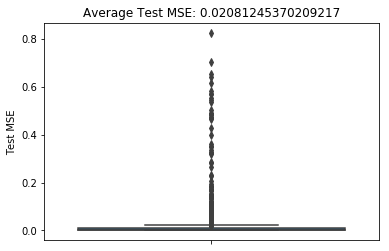

In [10]:
sns.boxplot(y=test_mse_list)
plt.ylabel('Test MSE')
plt.title('Average Test MSE: {}'.format(np.mean(test_mse_list)))

In [11]:
pd.DataFrame(test_mse_list, columns=['Test MSE']).describe()

,Test MSE
count,1.329000e+03
mean,2.081245e-02
std,7.642061e-02
min,1.454309e-12
25%,6.720464e-05
50%,9.110521e-04
75%,8.378627e-03
max,8.253579e-01
